In [1]:
%reset 

# clears variables in workspace
# note on resetting:
# especially while you're debugging, you want to clear your variables between attempts to solve. Why?
# A) you may have noticed that pyomo doesn't like things being redefined
# more importantly, B) the variables keep their values, so an infeasible solution becomes an infeasible guess. 

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np
import pandas as pd
sym.init_printing()
from IPython.display import display #for pretty
import log

#plotting
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

gait_name = "ThreeD_jup_step_up"
path = "/Users/Marethe/Documents/GitHub/Masters/3D_gait_generation/results/"

logger = log.setup_custom_logger(log_level = "INFO", log_path="C:"+path)
logger.info("-------------------------------------------------------")
logger.info(f"Gait name: {gait_name}")
logger.info("3D SS walk - initial and final positions the same")
logger.info("No C matrix")
logger.info(">< body configuration enforced")
logger.info("-------------------------------------------------------") 

# create the model
m = ConcreteModel()
m.clear()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


[2023-09-18T22:34:05+0200.0950][INFO ][<ipython-input-1-9baa091d5d33>] - -------------------------------------------------------
[2023-09-18T22:34:05+0200.0966][INFO ][<ipython-input-1-9baa091d5d33>] - Gait name: ThreeD_jup_step_up
[2023-09-18T22:34:05+0200.0966][INFO ][<ipython-input-1-9baa091d5d33>] - 3D SS walk - initial and final positions the same
[2023-09-18T22:34:05+0200.0971][INFO ][<ipython-input-1-9baa091d5d33>] - No C matrix
[2023-09-18T22:34:05+0200.0971][INFO ][<ipython-input-1-9baa091d5d33>] - >< body configuration enforced
[2023-09-18T22:34:05+0200.0971][INFO ][<ipython-input-1-9baa091d5d33>] - -------------------------------------------------------


## Variables

In [2]:
#Node Points
N = 40
cN = 3

#Mass
FemurMass = 0.2 #kg
TibiaMass = 0.3 #kg          #CALLEN checking if scaling is the problem    
BodyMass = 1.0 #kg

#Lengths
FemurLength = 0.115 #m
TibiaLength = 0.12 #m
BodyLength = 0.335 #m
BodyWidth = 0.172 #m
LegRadius = 0.06 #m

#Servo Motor Specs
m.Tmax = 6.864655 #Nm, corresponding to a 8V input                 #CALLEN changed this back, maybe high values is wrong
m.Wmax = 8.055366 #rad/s, corresponding to a 8V input

#Time Bounds
tmax = 0.1 #s 
tmin = 0.01 #s
hm = 1 #factor

#Travel distance
m.distance =0.01# 0.07 #m
m.vel = 0.1 #m/s

pi=np.pi

logger.info(f" m.distance = {m.distance}m, max travel dist*2")
logger.info(f" stepping height clearance: 1.5*step_height")
logger.info(f"Nodes = {N}, time variable {tmin}-{tmax}")

[2023-09-18T22:34:06+0200.0003][INFO ][<ipython-input-2-0b642ae462f3>] -  m.distance = 0.01m, max travel dist*2
[2023-09-18T22:34:06+0200.0003][INFO ][<ipython-input-2-0b642ae462f3>] -  stepping height clearance: 1.5*step_height
[2023-09-18T22:34:06+0200.0003][INFO ][<ipython-input-2-0b642ae462f3>] - Nodes = 40, time variable 0.01-0.1


## Symbolic Equations

In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4 = sym.symbols(['m_{body}','m_{femur1}','m_{tibia1}','m_{femur2}','m_{tibia2}','m_{femur3}','m_{tibia3}','m_{femur4}','m_{tibia4}']) # mass of links 
r,w_b,l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4 = sym.symbols(['r_{leg}','w_{body}','l_{body}','l_{femur1}','l_{tibia1}','l_{femur2}','l_{tibia2}','l_{femur3}','l_{tibia3}','l_{femur4}','l_{tibia4}']) # length of links
In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz = sym.symbols(['In_{bx}','In_{by}','In_{bz}','In_{femurXY}','In_{tibiaXY}','In_{femurZ}','In_{tibiaZ}'])

# generalized coordinates
x,y,z,th_by,th_bx,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4 = sym.symbols(['x','y','z','theta_{bodyy}','theta_{bodyx}','theta_{bodyz}','theta_{hip1}','theta_{knee1}','theta_{hip2}','theta_{knee2}','theta_{hip3}','theta_{knee3}','theta_{hip4}','theta_{knee4}']) #position
dx,dy,dz,dth_by,dth_bx,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4 = sym.symbols(['\dot{x}','\dot{y}','\dot{z}','\dot{\\theta}_{bodyy}','\dot{\\theta}_{bodyx}','\dot{\\theta}_{bodyz}','\dot{\\theta}_{hip1}','\dot{\\theta}_{knee1}','\dot{\\theta}_{hip2}','\dot{\\theta}_{knee2}','\dot{\\theta}_{hip3}','\dot{\\theta}_{knee3}','\dot{\\theta}_{hip4}','\dot{\\theta}_{knee4}']) #velocity
ddx,ddy,ddz,ddth_by,ddth_bx,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4 = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{z}','\ddot{\\theta}_{bodyy}','\ddot{\\theta}_{bodyx}','\ddot{\\theta}_{bodyz}','\ddot{\\theta}_{hip1}','\ddot{\\theta}_{knee1}','\ddot{\\theta}_{hip2}','\ddot{\\theta}_{knee2}','\ddot{\\theta}_{hip3}','\ddot{\\theta}_{knee3}','\ddot{\\theta}_{hip4}','\ddot{\\theta}_{knee4}']) #acceleration

q = sym.Matrix([[x],[y],[z],[th_by],[th_bx],[th_bz],[th_h1],[th_k1],[th_h2],[th_k2],[th_h3],[th_k3],[th_h4],[th_k4]]) #group into matrices
dq = sym.Matrix([[dx],[dy],[dz],[dth_by],[dth_bx],[dth_bz],[dth_h1],[dth_k1],[dth_h2],[dth_k2],[dth_h3],[dth_k3],[dth_h4],[dth_k4]])
ddq = sym.Matrix([[ddx],[ddy],[ddz],[ddth_by],[ddth_bx],[ddth_bz],[ddth_h1],[ddth_k1],[ddth_h2],[ddth_k2],[ddth_h3],[ddth_k3],[ddth_h4],[ddth_k4]])

# forces
tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z = sym.symbols(['\\tau_{hip1}','\\tau_{knee1}','\\tau_{hip2}','\\tau_{knee2}','\\tau_{hip3}','\\tau_{knee3}','\\tau_{hip4}','\\tau_{knee4}','G1_x','G1_y','G1_z','G2_x','G2_y','G2_z','G3_x','G3_y','G3_z','G4_x','G4_y','G4_z']) 

print('Done')

Done


In [4]:
#Euler Rotation Theorem
Rx=[[1, 0, 0], [0, sym.cos(th_bx), -sym.sin(th_bx)], [0, sym.sin(th_bx), sym.cos(th_bx)]]
Ry=[[sym.cos(th_by), 0, sym.sin(th_by)], [0, 1, 0], [-sym.sin(th_by), 0, sym.cos(th_by)]]
Rz=[[sym.cos(th_bz), -sym.sin(th_bz), 0], [sym.sin(th_bz), sym.cos(th_bz), 0], [0, 0, 1]]
Rxz=np.matmul(Rx,Rz)
Rxyz=np.matmul(Rxz,Ry)

hip11=[[l_b/2],[w_b/2],[0]]
hip22=[[l_b/2],[-w_b/2],[0]]
hip33=[[-l_b/2],[w_b/2],[0]]
hip44=[[-l_b/2],[-w_b/2],[0]]

femur11=[[l_b/2+l_f1/2*sym.sin(th_h1)],[w_b/2],[-l_f1/2*sym.cos(th_h1)]]
femur22=[[l_b/2+l_f1/2*sym.sin(th_h2)],[-w_b/2],[-l_f1/2*sym.cos(th_h2)]]
femur33=[[-l_b/2+l_f1/2*sym.sin(th_h3)],[w_b/2],[-l_f1/2*sym.cos(th_h3)]]
femur44=[[-l_b/2+l_f1/2*sym.sin(th_h4)],[-w_b/2],[-l_f1/2*sym.cos(th_h4)]]

knee11=[[l_b/2+l_f1*sym.sin(th_h1)],[w_b/2],[-l_f1*sym.cos(th_h1)]]
knee22=[[l_b/2+l_f1*sym.sin(th_h2)],[-w_b/2],[-l_f1*sym.cos(th_h2)]]
knee33=[[-l_b/2+l_f1*sym.sin(th_h3)],[w_b/2],[-l_f1*sym.cos(th_h3)]]
knee44=[[-l_b/2+l_f1*sym.sin(th_h4)],[-w_b/2],[-l_f1*sym.cos(th_h4)]]


#CALLEN: note you are using l_t1 for all, and not l_t2, l_t3 etc (same for l_f). Shouldnt make a difference though


tibia11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1/2*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1/2*sym.cos(th_k1)]]
tibia22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1/2*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1/2*sym.cos(th_k2)]]
tibia33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1/2*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1/2*sym.cos(th_k3)]]
tibia44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1/2*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1/2*sym.cos(th_k4)]]

foot11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1*sym.cos(th_k1)]]
foot22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1*sym.cos(th_k2)]]
foot33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1*sym.cos(th_k3)]]
foot44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1*sym.cos(th_k4)]]

print('Done')

Done


In [5]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

com_b = sym.Matrix([[x],[y],[z]])

com_h1 = sym.Matrix(com_b + np.matmul(Rxyz,hip11))
com_h2 = sym.Matrix(com_b + np.matmul(Rxyz,hip22))
com_h3 = sym.Matrix(com_b + np.matmul(Rxyz,hip33))
com_h4 = sym.Matrix(com_b + np.matmul(Rxyz,hip44))

com_f1 = sym.Matrix(com_b + np.matmul(Rxyz,femur11))
com_f2 = sym.Matrix(com_b + np.matmul(Rxyz,femur22))
com_f3 = sym.Matrix(com_b + np.matmul(Rxyz,femur33))
com_f4 = sym.Matrix(com_b + np.matmul(Rxyz,femur44))

com_k1 = sym.Matrix(com_b + np.matmul(Rxyz,knee11))
com_k2 = sym.Matrix(com_b + np.matmul(Rxyz,knee22))
com_k3 = sym.Matrix(com_b + np.matmul(Rxyz,knee33))
com_k4 = sym.Matrix(com_b + np.matmul(Rxyz,knee44))

com_t1 = sym.Matrix(com_b + np.matmul(Rxyz,tibia11))
com_t2 = sym.Matrix(com_b + np.matmul(Rxyz,tibia22))
com_t3 = sym.Matrix(com_b + np.matmul(Rxyz,tibia33))
com_t4 = sym.Matrix(com_b + np.matmul(Rxyz,tibia44))

foot1_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot11))
foot1x = sym.Matrix([foot1_pos[0]])
foot1y = sym.Matrix([foot1_pos[1]])
foot1z = sym.Matrix([foot1_pos[2]])
foot1z = foot1z[0].simplify()
foot2_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot22))
foot2x = sym.Matrix([foot2_pos[0]])
foot2y = sym.Matrix([foot2_pos[1]])
foot2z = sym.Matrix([foot2_pos[2]])
foot2z = foot2z[0].simplify()
foot3_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot33))
foot3x = sym.Matrix([foot3_pos[0]])
foot3y = sym.Matrix([foot3_pos[1]])
foot3z = sym.Matrix([foot3_pos[2]])
foot3z = foot3z[0].simplify()
foot4_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot44))
foot4x = sym.Matrix([foot4_pos[0]])
foot4y = sym.Matrix([foot4_pos[1]])
foot4z = sym.Matrix([foot4_pos[2]])
foot4z = foot4z[0].simplify()
print('Done')

Done


In [6]:
# STEP 2: generate expressions for the system space velocities
v_b = com_b.jacobian(q)*dq

v_f1 = com_f1.jacobian(q)*dq
v_t1 = com_t1.jacobian(q)*dq

v_f2 = com_f2.jacobian(q)*dq
v_t2 = com_t2.jacobian(q)*dq

v_f3 = com_f3.jacobian(q)*dq
v_t3 = com_t3.jacobian(q)*dq

v_f4 = com_f4.jacobian(q)*dq
v_t4 = com_t4.jacobian(q)*dq

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()
foot1dy = foot1y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dy = foot1dy[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()
foot2dy = foot2y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dy = foot2dy[0].simplify()

foot3dx = foot3x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dx = foot3dx[0].simplify()
foot3dy = foot3y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dy = foot3dy[0].simplify()

foot4dx = foot4x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dx = foot4dx[0].simplify()
foot4dy = foot4y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dy = foot4dy[0].simplify()

foot1x = foot1x[0].simplify()
foot2x = foot2x[0].simplify()
foot3x = foot3x[0].simplify()
foot4x = foot4x[0].simplify()

print('Done')

Done


In [7]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M_b = sym.Matrix([[m_b,m_b,m_b]])
M_f1 = sym.Matrix([[m_f1,m_f1,m_f1]])
M_t1 = sym.Matrix([[m_t1,m_t1,m_t1]])
M_f2 = sym.Matrix([[m_f2,m_f2,m_f2]])
M_t2 = sym.Matrix([[m_t2,m_t2,m_t2]])
M_f3 = sym.Matrix([[m_f3,m_f3,m_f3]])
M_t3 = sym.Matrix([[m_t3,m_t3,m_t3]])
M_f4 = sym.Matrix([[m_f4,m_f4,m_f4]])
M_t4 = sym.Matrix([[m_t4,m_t4,m_t4]])

I_b=sym.Matrix([[In_bx,In_by,In_bz]])
I_f=sym.Matrix([[In_fxy,In_fxy,In_fz]])
I_t=sym.Matrix([[In_txy,In_txy,In_tz]])

W_b=sym.Matrix([[dth_bx],[dth_by],[dth_bz]])   
W_h1=sym.Matrix([[dth_bx],[dth_h1+dth_by],[dth_bz]])
W_k1=sym.Matrix([[dth_bx],[dth_k1+dth_by],[dth_bz]])
W_h2=sym.Matrix([[dth_bx],[dth_h2+dth_by],[dth_bz]])
W_k2=sym.Matrix([[dth_bx],[dth_k2+dth_by],[dth_bz]])
W_h3=sym.Matrix([[dth_bx],[dth_h3+dth_by],[dth_bz]])
W_k3=sym.Matrix([[dth_bx],[dth_k3+dth_by],[dth_bz]])
W_h4=sym.Matrix([[dth_bx],[dth_h4+dth_by],[dth_bz]])
W_k4=sym.Matrix([[dth_bx],[dth_k4+dth_by],[dth_bz]])

# linear kinetic energy:
Tl = 0.5*M_b*sym.matrix_multiply_elementwise(v_b,v_b) + 0.5*M_f1*sym.matrix_multiply_elementwise(v_f1,v_f1) + 0.5*M_t1*sym.matrix_multiply_elementwise(v_t1,v_t1) + 0.5*M_f2*sym.matrix_multiply_elementwise(v_f2,v_f2) + 0.5*M_t2*sym.matrix_multiply_elementwise(v_t2,v_t2) + 0.5*M_f3*sym.matrix_multiply_elementwise(v_f3,v_f3) + 0.5*M_t3*sym.matrix_multiply_elementwise(v_t3,v_t3) + 0.5*M_f4*sym.matrix_multiply_elementwise(v_f4,v_f4) + 0.5*M_t4*sym.matrix_multiply_elementwise(v_t4,v_t4)
# angular kinetic energy:
Tw =  0.5*I_b*sym.matrix_multiply_elementwise(W_b,W_b) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h1,W_h1) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k1,W_k1) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h2,W_h2) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k2,W_k2) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h3,W_h3) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k3,W_k3) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h4,W_h4) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k4,W_k4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m_b*g*com_b[2] + m_f1*g*com_f1[2] + m_t1*g*com_t1[2] + m_f2*g*com_f2[2] + m_t2*g*com_t2[2] + m_f3*g*com_f3[2] + m_t3*g*com_t3[2] + m_f4*g*com_f4[2] + m_t4*g*com_t4[2]   
print('Done')

Done


In [8]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

#C  = sym.zeros(len(q),len(q))  
#for i in range(len(q)):                                             
#    for j in range(len(q)):
#        for n in range(len(q)):
#            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)  
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);  
 
 
Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #y
Q[2]=0                 #z
Q[3]=0    #th x
Q[4]=-tau_h1-tau_h2-tau_h3-tau_h4-tau_k1-tau_k2-tau_k3-tau_k4                           #th y
Q[5]=0                          #th z
Q[6]=tau_h1              #th hip 1
Q[7]=tau_k1                     #th knee 1
Q[8]=tau_h2              #th hip 2
Q[9]=tau_k2                     #th knee 2
Q[10]=tau_h3              #th hip 3
Q[11]=tau_k3                     #th knee 3
Q[12]=tau_h4              #th hip 4
Q[13]=tau_k4                    #th knee 4

J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1y],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2y],[GRF2z]])

J3=foot3_pos.jacobian(q)
GRF_3 = J3.transpose()*sym.Matrix([[GRF3x],[GRF3y],[GRF3z]]) 

J4=foot4_pos.jacobian(q)
GRF_4 = J4.transpose()*sym.Matrix([[GRF4x],[GRF4y],[GRF4z]])

EOM=M*ddq+G-Q-GRF_1-GRF_2-GRF_3-GRF_4#C*dq+


#CALLEN REmoved C matrix




EOMs = sym.zeros(len(q),1)
EOMcounter = 0
print(f"EOM simplification starts")
for j in range(len(q)):
    EOMs[j] = EOM[j]#.simplify()  #--> Helps to make simulation faster for bigger problems
#     print(f"EOM loop counter: {j}")
    EOMcounter = EOMcounter + 1
    
    

print('Done')

EOM simplification starts
Done


## Pyomo Stuff Starts

In [9]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4,
            l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4,w_b,r,
            In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz,
            x,y,z,th_bx,th_by,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4,
            dx,dy,dz,dth_bx,dth_by,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4,
            ddx,ddy,ddz,ddth_bx,ddth_by,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4,
            tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,
            GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_z = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th_bx = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th_by = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th_bz = sym.lambdify(sym_list,EOMs[5],modules = [func_map])
lambEOM_th_h1 = sym.lambdify(sym_list,EOMs[6],modules = [func_map])
lambEOM_th_k1 = sym.lambdify(sym_list,EOMs[7],modules = [func_map])
lambEOM_th_h2 = sym.lambdify(sym_list,EOMs[8],modules = [func_map])
lambEOM_th_k2 = sym.lambdify(sym_list,EOMs[9],modules = [func_map])
lambEOM_th_h3 = sym.lambdify(sym_list,EOMs[10],modules = [func_map])
lambEOM_th_k3 = sym.lambdify(sym_list,EOMs[11],modules = [func_map])
lambEOM_th_h4 = sym.lambdify(sym_list,EOMs[12],modules = [func_map])
lambEOM_th_k4 = sym.lambdify(sym_list,EOMs[13],modules = [func_map])

lamb_foot1x = sym.lambdify(sym_list,foot1x,modules = [func_map])
lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])
lamb_foot1dy = sym.lambdify(sym_list,foot1dy,modules = [func_map])

lamb_foot2x = sym.lambdify(sym_list,foot2x,modules = [func_map])
lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])
lamb_foot2dy = sym.lambdify(sym_list,foot2dy,modules = [func_map])

lamb_foot3x = sym.lambdify(sym_list,foot3x,modules = [func_map])
lamb_foot3z = sym.lambdify(sym_list,foot3z,modules = [func_map])
lamb_foot3dx = sym.lambdify(sym_list,foot3dx,modules = [func_map])
lamb_foot3dy = sym.lambdify(sym_list,foot3dy,modules = [func_map])

lamb_foot4x = sym.lambdify(sym_list,foot4x,modules = [func_map])
lamb_foot4z = sym.lambdify(sym_list,foot4z,modules = [func_map])
lamb_foot4dx = sym.lambdify(sym_list,foot4dx,modules = [func_map])
lamb_foot4dy = sym.lambdify(sym_list,foot4dy,modules = [func_map])

print('Done')

Done


In [10]:
# ConcreteModel SETS -------------------------------------------------------------------------------
m.N = RangeSet(N)
m.cN = RangeSet(cN)

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('bodyWidth',1),('legRadius',1),('femur',1),('tibia',1),('femur',2),('tibia',2),('femur',3),('tibia',3),('femur',4),('tibia',4)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','z','theta_bx','theta_by','theta_bz','theta_h1','theta_k1','theta_h2','theta_k2','theta_h3','theta_k3','theta_h4','theta_k4']
m.DOF = Set(initialize = DOFs) # the coordinates for each link

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N, bounds = (0,10))

m.h = Var(m.N, bounds =(tmin,tmax))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [11]:
# Substituting variables into ConcreteModel-----------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81) 

# mass of links
def get_m(n, lb, ln):
    if lb == 'femur':
        return FemurMass
    elif lb == 'body':
        return BodyMass
    else: return TibiaMass
m.m = Param(m.L, initialize = get_m)

mbody = sum(m.m[l] for l in links)
mBW = mbody*m.g.value
# m.m.pprint()
print(f'total body mass: {mbody}')
print(f'total body weight: {mBW}')

# length of links
def get_len(n, lb, ln):
    if lb == 'femur':
        return FemurLength
    elif lb == 'body':
        return BodyLength
    elif lb == 'bodyWidth':
        return BodyWidth
    elif lb == 'legRadius':
        return LegRadius
    else: return TibiaLength
m.l = Param(m.L, initialize = get_len) 
# m.l.pprint()

#Inertia
def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.l[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

#Body inertia
m.inbx = 1/12*m.m[('body',1)]*m.l[('body',1)]**2
m.inby = 1/12*m.m[('body',1)]*m.l[('bodyWidth',1)]**2
m.inbz = 1/12*m.m[('body',1)]*(m.l[('body',1)]**2+m.l[('bodyWidth',1)]**2)
m.infxy = m.m[('femur',1)]*m.l[('femur',1)]**2/12
m.intxy = m.m[('tibia',1)]*m.l[('tibia',1)]**2/12
m.infz = m.m[('femur',1)]*m.l[('legRadius',1)]**2/2
m.intz = m.m[('tibia',1)]*m.l[('legRadius',1)]**2/2
    
    
    #CALLEN: maybe print out the inertia values and see if they are reasonable values
    
    
print("Done")

total body mass: 3.6
total body weight: 35.316
Done


In [12]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [13]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [14]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Y','Z','THETAbx','THETAby','THETAbz', 'THETAh1','THETAk1', 'THETAh2','THETAk2', 'THETAh3','THETAk3','THETAh4','THETAk4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates

#CALLEN: double check the values below, I increased to 600 to give the optimizer some more wiggle room to find a sol 

m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*mBW
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF3 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF4 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [15]:
# SLACK VARIABLES
#CALLEN hopefully a bunch of these will not be required 


m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_3 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_3x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_3y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_3      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_4 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_4x   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_4y   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_4      = Var(m.N, m.cN, bounds = (0.0,None)) 

print('Done')

Done


In [16]:
# # CALLENS CODE TO MAKE THE STEP UP
step_length=0.05      #FAR TOO LONG I RATE
distance_from_step=0.1   #BodyLength=0.335 m
stair_height=0.05
logger.info(f"step_length = {step_length}, dist_from _step = {distance_from_step}, stair_height = {stair_height}")

stairs_1=np.zeros(N+1)
stairs_2=np.zeros(N+1)
stairs_3=np.zeros(N+1)
stairs_4=np.zeros(N+1)

for i in range(N+1):
    if i>=(N/4):
        stairs_1[i]=stair_height
    if i>=(3*N/4):
        stairs_2[i]=stair_height

# force robot to achieve distance of 2 cm half way through the trajectory (should have foot above step at this point)
# force robot to achieve distance of 4 cm at end of the trajectory (should have foot on step at this point)
def midXMin(m,n):
    if (n==N/2) :
        return m.q0[n,'x'] >= m.distance/2
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.midXMin = Constraint(m.N, rule = midXMin)

[2023-09-18T22:38:47+0200.0119][INFO ][<ipython-input-16-509da3167e4b>] - step_length = 0.05, dist_from _step = 0.1, stair_height = 0.05


In [17]:
print(0.5*BodyLength+distance_from_step+step_length)

0.3175


In [18]:
# ------------FOOT POSITIONS----------------------------
# -----------------Foot 1-------------------------------
def step_1_max(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                   m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                   m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                   m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                   m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                   m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                   m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                   m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                   m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n<=N):
        return lamb_foot1x(*var_list) <=0.5*BodyLength+distance_from_step+step_length
    else:
        return Constraint.Skip
m.foot_1_step_max = Constraint(m.N, m.cN, rule = step_1_max)

def step_1_min(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                   m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                   m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                   m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                   m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                   m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                   m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                   m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                   m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n==N/4):
        return lamb_foot1x(*var_list) >= 0.5*BodyLength+distance_from_step
    else:
        return Constraint.Skip
m.foot_1_step_min = Constraint(m.N, m.cN, rule = step_1_min)

def step_1_height(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n<2):
        return lamb_foot1z(*var_list) <=0.01
    if (n==N/4):
        return lamb_foot1z(*var_list) >=1.5*stairs_1[n]
    if (n==N/2):
        return lamb_foot1z(*var_list) <=stairs_1[n]+0.01
    else:
        return Constraint.Skip
m.step_1_height = Constraint(m.N, m.cN, rule = step_1_height)


# -----------------Foot 2-------------------------------
def step_2_max(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                   m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                   m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                   m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                   m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                   m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                   m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                   m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                   m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n<=N):
        return lamb_foot2x(*var_list) <=0.5*BodyLength+distance_from_step+step_length
    else:
        return Constraint.Skip
m.foot_2_step_max = Constraint(m.N, m.cN, rule = step_2_max)

def step_2_min(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                   m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                   m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                   m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                   m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                   m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                   m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                   m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                   m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n==3*N/4):
        return lamb_foot2x(*var_list) >= 0.5*BodyLength+distance_from_step
    else:
        return Constraint.Skip
m.foot_2_step_min = Constraint(m.N, m.cN, rule = step_2_min)

def step_2_height(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n<N/2):
        return lamb_foot2z(*var_list) <=0.01
    if (n==3*N/4):
        return lamb_foot2z(*var_list) >=1.5*stairs_2[n]
    if (n==N):
        return lamb_foot2z(*var_list) <=stairs_2[n]+0.01
    else:
        return Constraint.Skip
m.step_2_height = Constraint(m.N, m.cN, rule = step_2_height)

# -----------------Foot 1-------------------------------
def contact_order_1(m,n,c):
    if (n>N/2):
        return m.GRF1[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

# -----------------Foot 2-------------------------------
def contact_order_2(m,n,c):
    if (n<N/2):
        return m.GRF2[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# -----------------Foot 3-------------------------------
def contact_order_3(m,n,c):
#     if (n<=3):
    return m.GRF3[n,c,'Z','ps'] >=5 
#     else:
#         return Constraint.Skip
m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)

# -----------------Foot 4-------------------------------
def contact_order_4(m,n,c):
#     if (n<=3):
    return m.GRF4[n,c,'Z','ps'] >=5 
#     else:
#         return Constraint.Skip
m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

logger.info(f"Foot 3 and 4 forced to ground for entire gait")

[2023-09-18T22:38:47+0200.0449][INFO ][<ipython-input-18-524ffad9f1f0>] - Foot 3 and 4 forced to ground for entire gait


In [19]:
# # CALLENS CODE TO MAKE THE STEP UP
# step_length=0.15      #FAR TOO LONG I RATE
# distance_from_step=BodyLength/2+0.02   #BodyLength=0.335 m
# stair_height=0.05

# # force robot to achieve distance of 2 cm half way through the trajectory (should have foot above step at this point)
# # force robot to achieve distance of 4 cm at end of the trajectory (should have foot on step at this point)
# def midXMin(m,n):
#     if (n==N/2) :
#         return m.q0[n,'x'] >= 0.02
#     if (n==N) :
#         return m.q0[n,'x'] >= 0.04
#     return Constraint.Skip
# m.midXMin = Constraint(m.N, rule = midXMin)





# #FIRST LEFT STEP UP
# def step_mid_height(m,n,c):       
#     var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                     m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                     m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                     m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                     m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                     m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                     m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                     m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                     m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<2):
#         return lamb_foot2z(*var_list) <=0.01
#     if (n==N/4):
#         return lamb_foot2z(*var_list) >=1.5*stair_height
#     if (n==N/2):
#         return lamb_foot2z(*var_list) <=stair_height+0.01
#     return Constraint.Skip
# m.step_mid_height = Constraint(m.N, m.cN, rule = step_mid_height)

# def step_mid_distance(m,n,c):       
#     var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                     m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                     m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                     m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                     m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                     m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                     m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                     m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                     m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n==N/4):
#         return lamb_foot2x(*var_list) >=distance_from_step
#     if (n==N/2):
#         return lamb_foot2x(*var_list) >=distance_from_step+0.03
#     return Constraint.Skip
# m.step_mid_distance = Constraint(m.N, m.cN, rule = step_mid_distance)




# #SECOND STEP UP
# def step_mid_height_2(m,n,c):       
#     var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                     m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                     m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                     m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                     m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                     m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                     m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                     m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                     m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<N/2):
#         return lamb_foot1z(*var_list) <=0.01
#     if (n==3*N/4):
#         return lamb_foot1z(*var_list) >=1.5*stair_height
#     if (n==N):
#         return lamb_foot1z(*var_list) <=stair_height+0.01
#     return Constraint.Skip
# m.step_mid_height_2 = Constraint(m.N, m.cN, rule = step_mid_height_2)

# def step_mid_distance_2(m,n,c):       
#     var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                     m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                     m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                     m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                     m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                     m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                     m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                     m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                     m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n==3*N/4):
#         return lamb_foot1x(*var_list) >=distance_from_step
#     if (n==N):
#         return lamb_foot1x(*var_list) >=distance_from_step+0.03
#     return Constraint.Skip
# m.step_mid_distance_2 = Constraint(m.N, m.cN, rule = step_mid_distance_2)















# # force other feet to stay on the ground
# # def contact_order_1(m,n,c):
# #     if (n<N/2):
# #         return m.GRF1[n,c,'Z','ps'] >=5 
# #     return Constraint.Skip
# # m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)
# # def contact_order_2(m,n,c):
# #     if (n>N/2):
# #         return m.GRF2[n,c,'Z','ps'] >=5 
# #     return Constraint.Skip
# # m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# def contact_order_3(m,n,c):
#     return m.GRF3[n,c,'Z','ps'] >=5 
# m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
# def contact_order_4(m,n,c):
#     return m.GRF4[n,c,'Z','ps'] >=5 
# m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)


# # define the vectors for the contact model
# stairs_1=np.zeros(N+1)
# stairs_2=np.zeros(N+1)
# stairs_3=np.zeros(N+1)
# stairs_4=np.zeros(N+1)

# for i in range(N+1):
#     if i>N/4:
#         stairs_2[i]=stair_height
#     if i>3*N/4:
#         stairs_1[i]=stair_height

# print('Done')


In [20]:
#step_length=0.15
#distance_from_step=BodyLength/2+0.02   #BodyLength=0.335 m

#stair_height=0.05
#stairs_1=np.zeros(N+1)
#stairs_2=np.zeros(N+1)
#stairs_3=np.zeros(N+1)
#stairs_4=np.zeros(N+1)

#for i in range(N+1):
#     if i>(segment_nodes*1):
#         stairs_1[i]=stair_height
#    if i>9:
#        stairs_2[i]=stair_height
#     if i>35:
#         stairs_3[i]=stair_height
#     if i>55:
#         stairs_4[i]=stair_height

In [21]:
# ------------FOOT POSITIONS----------------------------
# -----------------Foot 1-------------------------------
#def step_1_max(m,n,c):       
#    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#    if (n<segment_nodes*2):
#        return lamb_foot1x(*var_list) <=distance_from_step+0.02
#    else:
#        return Constraint.Skip
#m.foot_1_step_max = Constraint(m.N, m.cN, rule = step_1_max)

#def step_2_max(m,n,c):       
#    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#    if (n>15):
#        return lamb_foot2x(*var_list) <=distance_from_step+step_length
#    elif (n<5):
#        return lamb_foot2x(*var_list) <=distance_from_step
#    else:
#        return Constraint.Skip
#m.foot_2_step_max = Constraint(m.N, m.cN, rule = step_2_max)

#def step_2_min(m,n,c):       
#    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
#                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
#                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
#                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
#                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
#                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
#                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
#                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
#                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
#                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#    if (n>15):
#        return lamb_foot2x(*var_list) >=distance_from_step
#    else:
#        return Constraint.Skip
#m.foot_2_step_min = Constraint(m.N, m.cN, rule = step_2_min)


In [22]:
# # CONTACTS
# # Leg 1 --------------------------------------------------------------------------------------------------------------

# #CALLEN allows foot to make and break contact 
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)-stairs_1[n]
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)

def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

#condition
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)-stairs_2[n]
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)

def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

#condition
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_contact_3(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_3[n,c] == lamb_foot3z(*var_list)-stairs_3[n]
m.def_a_contact_3 = Constraint(m.N, m.cN, rule = def_a_contact_3)

def def_b_contact_3(m,n,c):   
    return m.b_contact_3[n,c] == m.GRF3[n,c,'Z','ps']
m.def_b_contact_3 = Constraint(m.N, m.cN, rule = def_b_contact_3)

#condition
def def_contact_3_pr(m,n):
    a_contact_3_pr = m.a_contact_3[n,1] + m.a_contact_3[n,2] + m.a_contact_3[n,3] 
    b_contact_3_pr = m.b_contact_3[n,1] + m.b_contact_3[n,2] + m.b_contact_3[n,3]  
    return a_contact_3_pr*b_contact_3_pr <= m.eps
m.def_contact_3_pr = Constraint(m.N, rule = def_contact_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_contact_4(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_4[n,c] == lamb_foot4z(*var_list)-stairs_4[n]
m.def_a_contact_4 = Constraint(m.N, m.cN, rule = def_a_contact_4)

def def_b_contact_4(m,n,c):   
    return m.b_contact_4[n,c] == m.GRF4[n,c,'Z','ps']
m.def_b_contact_4 = Constraint(m.N, m.cN, rule = def_b_contact_4)

#condition
def def_contact_4_pr(m,n):
    a_contact_4_pr = m.a_contact_4[n,1] + m.a_contact_4[n,2] + m.a_contact_4[n,3] 
    b_contact_4_pr = m.b_contact_4[n,1] + m.b_contact_4[n,2] + m.b_contact_4[n,3]  
    return a_contact_4_pr*b_contact_4_pr <= m.eps
m.def_contact_4_pr = Constraint(m.N, rule = def_contact_4_pr)

print('Done')

Done


In [23]:
# FRICTION CONE
# Leg 1 -------------------------------------------------------------------------------------------------------------
def def_a_friction_1(m,n,c):   
    return (m.mu*m.GRF1[n,c,'Z','ps'])**2 >= ((m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])**2+(m.GRF1[n,c,'Y','ps'] + m.GRF1[n,c,'Y','ng'])**2)
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_friction_2(m,n,c):   
    return  (m.mu*m.GRF2[n,c,'Z','ps'])**2 >= ((m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])**2+(m.GRF2[n,c,'Y','ps'] + m.GRF2[n,c,'Y','ng'])**2)
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_friction_3(m,n,c):   
    return (m.mu*m.GRF3[n,c,'Z','ps'])**2 >= ((m.GRF3[n,c,'X','ps'] + m.GRF3[n,c,'X','ng'])**2+(m.GRF3[n,c,'Y','ps'] + m.GRF3[n,c,'Y','ng'])**2)
m.def_a_friction_3 = Constraint(m.N, m.cN, rule = def_a_friction_3)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_friction_4(m,n,c):   
    return (m.mu*m.GRF4[n,c,'Z','ps'])**2 >= ((m.GRF4[n,c,'X','ps'] + m.GRF4[n,c,'X','ng'])**2+(m.GRF4[n,c,'Y','ps'] + m.GRF4[n,c,'Y','ng'])**2)
m.def_a_friction_4 = Constraint(m.N, m.cN, rule = def_a_friction_4)


logger.info("Friction is not a slack variable anymore, slip constraints removed")

[2023-09-18T22:38:47+0200.0975][INFO ][<ipython-input-23-23998bfa35e5>] - Friction is not a slack variable anymore, slip constraints removed


In [24]:
def def_F1_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dx(*var_list)*lamb_foot1dx(*var_list)<= m.eps/1
m.def_F1_x = Constraint(m.N, m.cN, rule = def_F1_x)
def def_F1_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dy(*var_list)*lamb_foot1dy(*var_list)<= m.eps/1
m.def_F1_y = Constraint(m.N, m.cN, rule = def_F1_y)






def def_F2_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dx(*var_list)*lamb_foot2dx(*var_list)<= m.eps/1
m.def_F2_x = Constraint(m.N, m.cN, rule = def_F2_x)
def def_F2_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dy(*var_list)*lamb_foot2dy(*var_list)<= m.eps/1
m.def_F2_y = Constraint(m.N, m.cN, rule = def_F2_y)





def def_F3_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dx(*var_list)*lamb_foot3dx(*var_list)<= m.eps/1
m.def_F3_x = Constraint(m.N, m.cN, rule = def_F3_x)
def def_F3_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dy(*var_list)*lamb_foot3dy(*var_list)<= m.eps/1
m.def_F3_y = Constraint(m.N, m.cN, rule = def_F3_y)



def def_F4_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dx(*var_list)*lamb_foot4dx(*var_list)<= m.eps/1
m.def_F4_x = Constraint(m.N, m.cN, rule = def_F4_x)
def def_F4_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dy(*var_list)*lamb_foot4dy(*var_list)<= m.eps/1
m.def_F4_y = Constraint(m.N, m.cN, rule = def_F4_y)

print('Done')

Done


In [25]:
m.tau_h1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_1
m.tau_k1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_1
m.tau_h2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_2
m.tau_k2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_2
m.tau_h3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_3
m.tau_k3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_3
m.tau_h4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_4
m.tau_k4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_4

# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_hip1_motor_model_p(m,n):
    return  m.tau_h1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_h1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee1_motor_model_p(m,n):
    return  m.tau_k1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_p = Constraint(m.N, rule = def_knee1_motor_model_p)
def def_knee1_motor_model_n(m,n):
    return  m.tau_k1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_n = Constraint(m.N, rule = def_knee1_motor_model_n)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_hip2_motor_model_p(m,n):
    return  m.tau_h2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_p = Constraint(m.N, rule = def_hip2_motor_model_p)
def def_hip2_motor_model_n(m,n):
    return  m.tau_h2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_n = Constraint(m.N, rule = def_hip2_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_k2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_k2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_hip3_motor_model_p(m,n):
    return  m.tau_h3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_h3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee3_motor_model_p(m,n):
    return  m.tau_k3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_p = Constraint(m.N, rule = def_knee3_motor_model_p)
def def_knee3_motor_model_n(m,n):
    return  m.tau_k3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_n = Constraint(m.N, rule = def_knee3_motor_model_n)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_hip4_motor_model_p(m,n):
    return  m.tau_h4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_p = Constraint(m.N, rule = def_hip4_motor_model_p)
def def_hip4_motor_model_n(m,n):
    return  m.tau_h4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_n = Constraint(m.N, rule = def_hip4_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_k4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_k4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [26]:

#CALLEN: simplified the substitution for the below functions, trying to speed up the optimizer 


def EOM_x(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_z(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_th_bx(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bx(*var_list) == 0
m.EOM_th_bx = Constraint(m.N, m.cN, rule = EOM_th_bx)

def EOM_th_by(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_by(*var_list) == 0
m.EOM_th_by = Constraint(m.N, m.cN, rule = EOM_th_by)

def EOM_th_bz(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bz(*var_list) == 0
m.EOM_th_bz = Constraint(m.N, m.cN, rule = EOM_th_bz)

def EOM_th_h1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h1(*var_list) == 0
m.EOM_th_h1 = Constraint(m.N, m.cN, rule = EOM_th_h1)

def EOM_th_k1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k1(*var_list) == 0
m.EOM_th_k1 = Constraint(m.N, m.cN, rule = EOM_th_k1)

def EOM_th_h2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h2(*var_list) == 0
m.EOM_th_h2 = Constraint(m.N, m.cN, rule = EOM_th_h2)

def EOM_th_k2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k2(*var_list) == 0
m.EOM_th_k2 = Constraint(m.N, m.cN, rule = EOM_th_k2)

def EOM_th_h3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h3(*var_list) == 0
m.EOM_th_h3 = Constraint(m.N, m.cN, rule = EOM_th_h3)

def EOM_th_k3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k3(*var_list) == 0
m.EOM_th_k3 = Constraint(m.N, m.cN, rule = EOM_th_k3)

def EOM_th_h4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h4(*var_list) == 0
m.EOM_th_h4 = Constraint(m.N, m.cN, rule = EOM_th_h4)

def EOM_th_k4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k4(*var_list) == 0
m.EOM_th_k4 = Constraint(m.N, m.cN, rule = EOM_th_k4)

print('Done')

Done


In [27]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setyBounds(m,n): 
    return (-1.0, m.q0[n,'y'], 1.0)    #CALLEN changed
m.setyBounds = Constraint(m.N, rule=setyBounds)
def setzBounds(m,n):
    return (0, m.q0[n,'z'], 5)    #CALLEN changed
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth_bx_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bx'], 0.785)
m.setth_bx_Bounds = Constraint(m.N, rule=setth_bx_Bounds)
def setth_by_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_by'], 0.785)
m.setth_by_Bounds = Constraint(m.N, rule=setth_by_Bounds)
def setth_bz_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bz'], 0.785)
m.setth_bz_Bounds = Constraint(m.N, rule=setth_bz_Bounds)




    #CALLEN changed-> made them larger to give wiggle room, they were +-1, but change them to the correct values
def setth_h1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h1'],1.5)
m.setth_h1_Bounds = Constraint(m.N, rule=setth_h1_Bounds)
def setth_k1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k1'], 1.5)
m.setth_k1_Bounds = Constraint(m.N, rule=setth_k1_Bounds)
def setth_h2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h2'],1.5)
m.setth_h2_Bounds = Constraint(m.N, rule=setth_h2_Bounds)
def setth_k2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k2'],1.5)
m.setth_k2_Bounds = Constraint(m.N, rule=setth_k2_Bounds)
def setth_h3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h3'], 1.5)
m.setth_h3_Bounds = Constraint(m.N, rule=setth_h3_Bounds)
def setth_k3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k3'], 1.5)
m.setth_k3_Bounds = Constraint(m.N, rule=setth_k3_Bounds)
def setth_h4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h4'], 1.5)
m.setth_h4_Bounds = Constraint(m.N, rule=setth_h4_Bounds)
def setth_k4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k4'], 1.5)
m.setth_k4_Bounds = Constraint(m.N, rule=setth_k4_Bounds)

def setdxBounds(m,n):
    return (-10, m.dq0[n,'x'],10.0)    #CALLEN changed
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdyBounds(m,n):
    return (-10, m.dq0[n,'y'],10)
m.setdyBounds = Constraint(m.N, rule=setdyBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdth_bx_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bx'],4*m.Wmax)
m.setdth_bx_Bounds = Constraint(m.N, rule=setdth_bx_Bounds)
def setdth_by_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_by'],4*m.Wmax)
m.setdth_by_Bounds = Constraint(m.N, rule=setdth_by_Bounds)
def setdth_bz_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bz'],4*m.Wmax)
m.setdth_bz_Bounds = Constraint(m.N, rule=setdth_bz_Bounds)
def setdth_h1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h1'],4*m.Wmax)
m.setdth_h1_Bounds = Constraint(m.N, rule=setdth_h1_Bounds)
def setdth_k1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k1'], 4*m.Wmax)
m.setdth_k1_Bounds = Constraint(m.N, rule=setdth_k1_Bounds)
def setdth_h2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h2'],4*m.Wmax)
m.setdth_h2_Bounds = Constraint(m.N, rule=setdth_h2_Bounds)
def setdth_k2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k2'], 4*m.Wmax)
m.setdth_k2_Bounds = Constraint(m.N, rule=setdth_k2_Bounds)
def setdth_h3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h3'],4*m.Wmax)
m.setdth_h3_Bounds = Constraint(m.N, rule=setdth_h3_Bounds)
def setdth_k3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k3'], 4*m.Wmax)
m.setdth_k3_Bounds = Constraint(m.N, rule=setdth_k3_Bounds)
def setdth_h4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h4'],4*m.Wmax)
m.setdth_h4_Bounds = Constraint(m.N, rule=setdth_h4_Bounds)
def setdth_k4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k4'], 4*m.Wmax)
m.setdth_k4_Bounds = Constraint(m.N, rule=setdth_k4_Bounds)

print('Done')

Done


In [28]:
#Relative Knee Angle Constraints
#Knee 1
def relative_th_k1a(m,n):
    return m.q0[n,'theta_k1']-m.q0[n,'theta_h1'] >= 0.1
m.relative_th_k1a = Constraint(m.N, rule = relative_th_k1a)

def th_h1_constraint(m,n):
    return m.q0[n,'theta_h1'] >= -30/180*pi
m.th_h1_constraint = Constraint(m.N, rule = th_h1_constraint)

#Knee 2
def relative_th_k2a(m,n):
    return m.q0[n,'theta_k2']-m.q0[n,'theta_h2'] >= 0.1 
m.relative_th_k2a = Constraint(m.N, rule = relative_th_k2a)

def th_h2_constraint(m,n):
    return m.q0[n,'theta_h2'] >= -30/180*pi
m.th_h2_constraint = Constraint(m.N, rule = th_h2_constraint)

#Knee 3
def relative_th_k3a(m,n):
    return m.q0[n,'theta_k3']-m.q0[n,'theta_h3'] <= -0.1
m.relative_th_k3a = Constraint(m.N, rule = relative_th_k3a)

def th_h3_constraint(m,n):
    return m.q0[n,'theta_h3'] <= 30/180*pi
m.th_h3_constraint = Constraint(m.N, rule = th_h3_constraint)

#Knee 4
def relative_th_k4a(m,n):
    return m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] <= -0.1
m.relative_th_k4a = Constraint(m.N, rule = relative_th_k4a)

def th_h4_constraint(m,n):
    return m.q0[n,'theta_h4'] <= 30/180*pi
m.th_h4_constraint = Constraint(m.N, rule = th_h4_constraint)

print('Done')

Done


In [29]:
movement = pd.read_csv(r'C:\Users\Marethe\OneDrive\Masters_2.0\Quad_simulations\3D\Mine8\3D_col_ros.csv')
end = movement.iloc[0,:] 
print(end)

R = 1.0
D = 5.0
logger.info("Randomised seed")

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'y'].value = 0.01         
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_bx'].value = np.random.uniform(np.pi/4,3*np.pi/4)   #end[3]
        m.q[n,c,'theta_by'].value = np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_bz'].value = np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_h1'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k1'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h2'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k2'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h3'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k3'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h4'].value = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k4'].value = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
        m.GRF3[n,c,'Z','ps'].value = 0.01
        m.GRF3[n,c,'X','ps'].value = 0.01 
        m.GRF3[n,c,'X','ng'].value = 0.01 
        
        m.GRF4[n,c,'Z','ps'].value = 0.01
        m.GRF4[n,c,'X','ps'].value = 0.01 
        m.GRF4[n,c,'X','ng'].value = 0.01
        
print('Done')

[2023-09-18T22:39:17+0200.0505][INFO ][<ipython-input-29-4a969ad634ff>] - Randomised seed


X Position      0.000000
Y Position      0.000000
Z Position      0.217719
Body Angle x    0.000000
Body Angle y    0.018326
Body Angle z    0.000000
Hip 1 Angle    -0.360531
Knee 1 Angle    0.481889
Hip 2 Angle     0.014251
Knee 2 Angle    0.640105
Hip 3 Angle     0.479315
Knee 3 Angle   -0.203286
Hip 4 Angle     0.150306
Knee 4 Angle   -0.456158
m.tt            0.003333
Name: 0, dtype: float64
Done


In [30]:
#---------WALKING GAIT MOVING ONE LEG AT A TIME-----------
#For 50 NODES
#Enforce contact order 

#Leg 1
#def contact_order_1(m,n,c):
#    if n<segment_nodes*2:
#        return m.GRF1[n,c,'Z','ps'] >=5 
#     if (n>segment_nodes and n<segment_nodes*2):
#         return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
#    else:
#        return Constraint.Skip
#m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

#Leg 2
#def contact_order_2(m,n,c):
#    if(n<4 or n>16):
#        return m.GRF2[n,c,'Z','ps'] >=5
#    if((n>7 and n<14)):
#        return m.GRF2[n,c,'Z','ps'] == 0 
#    else:
#        return Constraint.Skip
#m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

#Leg 3
#def contact_order_3(m,n,c):
#    if n<segment_nodes*2:
#        return m.GRF3[n,c,'Z','ps'] >= 5
#     if ((n>segment_nodes*4 and n<segment_nodes*5)):
#         return m.GRF3[n,c,'Z','ps'] == 0 
#    else:
#        return Constraint.Skip
#m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
#Leg 4
#def contact_order_4(m,n,c):
#    if (n<segment_nodes*2):
#        return m.GRF4[n,c,'Z','ps'] >= 5
#     if((n>segment_nodes*2 and n<3*segment_nodes)):
#         return m.GRF4[n,c,'Z','ps'] == 0 
#    else:
#        return Constraint.Skip
#m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

print('Done')







Done


In [31]:
# #----------WALKING TROT GAIT---------------
# #For 40 NODES
# #Enforce contact order

# #Leg 1
# def contact_order_1(m,n,c):
#     if ((n>1 and n<6) or n>21):
#         return m.GRF1[n,c,'Z','ps'] >=5
#         #return lamb_foot1z(*var_list)==0  #Forces foot to ground    
#     if (n>8 and n<19):
#         return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
#     else:
#         return Constraint.Skip
# m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

# #Leg 2
# def contact_order_2(m,n,c):
#     if(n<26):
#         return m.GRF2[n,c,'Z','ps'] >=5
#         #return lamb_foot2z(*var_list)==0  #Forces foot to ground 
#     if(n>28):
#         return m.GRF2[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# #Leg 3
# def contact_order_3(m,n,c):
#     if(n<26):
#         return m.GRF3[n,c,'Z','ps'] >= 5
#         #return lamb_foot3z(*var_list)==0  #Forces foot to ground 
#     if(n>28):
#         return m.GRF3[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
# #Leg 4
# def contact_order_4(m,n,c):
#     if ((n>1 and n<6) or n>21):
#         return m.GRF4[n,c,'Z','ps'] >= 5
#         #return lamb_foot4z(*var_list)==0  #Forces foot to ground 
#     if (n>8 and n<19):
#         return m.GRF4[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

# print('Done')

In [32]:
# #---------WALKING GAIT MOVING ONE LEG AT A TIME - 2 STEPS-----------
# #For 80 NODES
# #Enforce contact order 

# #Leg 1
# def contact_order_1(m,n,c):
#     if ((n>10 and n<40) or n>50):
#         return m.GRF1[n,c,'Z','ps'] >=5
#         #return lamb_foot1z(*var_list)==0  #Forces foot to ground    
#     if (n<10 or (n>40 and n<50)):
#         return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
#     else:
#         return Constraint.Skip
# m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

# #Leg 2
# def contact_order_2(m,n,c):
#     if(n<20 or (n>30 and n<60) or n>70):
#         return m.GRF2[n,c,'Z','ps'] >=5
#         #return lamb_foot2z(*var_list)==0  #Forces foot to ground 
#     if((n>20 and n<30) or (n>60 and n<70)):
#         return m.GRF2[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# #Leg 3
# def contact_order_3(m,n,c):
#     if(n<30 or (n>40 and n<70)):
#         return m.GRF3[n,c,'Z','ps'] >= 5
#         #return lamb_foot3z(*var_list)==0  #Forces foot to ground 
#     if((n>30 and n<40) or n>70):
#         return m.GRF3[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
# #Leg 4
# def contact_order_4(m,n,c):
#     if (n<10 or (n>20 and n<50) or n>60):
#         return m.GRF4[n,c,'Z','ps'] >= 5
#         #return lamb_foot4z(*var_list)==0  #Forces foot to ground 
#     if ((n>10 and n<20) or (n>50 and n<60)):
#         return m.GRF4[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

# print('Done')

In [33]:
#Steady State
#--------------------------------------------------------------
    
# def velocity(m,n):
#     if (n==N):
#         return m.vel>=m.q0[n,'x']/duration
#     else:
#         return Constraint.Skip
# m.velocity = Constraint(m.N, rule = velocity)

def minimum_z(m,n):
    return m.q0[n,'z'] <= 9.8*(FemurLength+TibiaLength)/10 + stairs_1[n]
# m.minimum_z = Constraint(m.N, rule = minimum_z)

#initial variables
logger.info(f"Removed initial -m.q[1,1,'x'].value = 0.0- for step up")
# m.q[1,1,'x'].value = 0.0    
# m.q[1,1,'x'].fixed = True
m.q[1,1,'y'].value = 0.0
m.q[1,1,'y'].fixed = True
m.q[1,1,'z'].value = end[2]
m.q[1,1,'z'].fixed = True
m.q[1,1,'theta_bx'].value = end[3]
m.q[1,1,'theta_bx'].fixed = True
m.q[1,1,'theta_by'].value = end[4]
m.q[1,1,'theta_by'].fixed = True
m.q[1,1,'theta_bz'].value = end[5]
m.q[1,1,'theta_bz'].fixed = True
m.q[1,1,'theta_h1'].value = end[6]#-pi/8
m.q[1,1,'theta_h1'].fixed = True
m.q[1,1,'theta_k1'].value = end[7]#pi/8
m.q[1,1,'theta_k1'].fixed = True
m.q[1,1,'theta_h2'].value = end[8]#-pi/8
m.q[1,1,'theta_h2'].fixed = True
m.q[1,1,'theta_k2'].value = end[9]#pi/8
m.q[1,1,'theta_k2'].fixed = True
m.q[1,1,'theta_h3'].value = end[10]#pi/8
m.q[1,1,'theta_h3'].fixed = True
m.q[1,1,'theta_k3'].value = end[11]#-pi/8
m.q[1,1,'theta_k3'].fixed = True
m.q[1,1,'theta_h4'].value = end[12]#pi/8
m.q[1,1,'theta_h4'].fixed = True
m.q[1,1,'theta_k4'].value = end[13]#-pi/8
m.q[1,1,'theta_k4'].fixed = True

# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'y'].value = 0.0
# m.dq[1,1,'y'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True

#---------Final position constraints-------------
#def finalXMin(m,n):
#    if (n==N) :
#        return m.q0[n,'x'] >= m.distance
#    else:
#        return Constraint.Skip
#m.finalXMin = Constraint(m.N, rule = finalXMin)

# def finalXMax(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] <= m.distance*3
#     else:
#         return Constraint.Skip
# m.finalXMax = Constraint(m.N, rule = finalXMax)

# def finalY(m,n):
#     if (n==N) :
#         return m.q0[n,'y'] == m.q0[1,'y']
#     else:
#         return Constraint.Skip
# m.finalY = Constraint(m.N, rule = finalY)

# def finalZ(m,n):
#     if (n==N) :
#         return m.q0[n,'z'] == m.q0[1,'z'] #FemurLength+TibiaLength
#     else:
#         return Constraint.Skip
# m.finalZ = Constraint(m.N, rule = finalZ)

# def finalthbx(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_bx'] == m.q0[1,'theta_bx']
#     else:
#         return Constraint.Skip
# m.finalthbx = Constraint(m.N, rule = finalthbx)

# def finalthby(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_by'] == m.q0[1,'theta_by']
#     else:
#         return Constraint.Skip
# m.finalthby = Constraint(m.N, rule = finalthby)

# def finalthbz(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_bz'] == m.q0[1,'theta_bz']
#     else:
#         return Constraint.Skip
# m.finalthbz = Constraint(m.N, rule = finalthbz)

# def finalthh1(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_h1'] == m.q0[1,'theta_h1']
#     else:
#         return Constraint.Skip
# m.finalthh1 = Constraint(m.N, rule = finalthh1)

# def finalthk1(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_k1'] == m.q0[1,'theta_k1']
#     else:
#         return Constraint.Skip
# m.finalthk1 = Constraint(m.N, rule = finalthk1)

# def finalthh2(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_h2'] == m.q0[1,'theta_h2']
#     else:
#         return Constraint.Skip
# m.finalthh2 = Constraint(m.N, rule = finalthh2)

# def finalthk2(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_k2'] == m.q0[1,'theta_k2']
#     else:
#         return Constraint.Skip
# m.finalthk2 = Constraint(m.N, rule = finalthk2)

# def finalthh3(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_h3'] == m.q0[1,'theta_h3']
#     else:
#         return Constraint.Skip
# m.finalthh3 = Constraint(m.N, rule = finalthh3)

# def finalthk3(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_k3'] == m.q0[1,'theta_k3']
#     else:
#         return Constraint.Skip
# m.finalthk3 = Constraint(m.N, rule = finalthk3)

# def finalthh4(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_h4'] == m.q0[1,'theta_h4']
#     else:
#         return Constraint.Skip
# m.finalthh4 = Constraint(m.N, rule = finalthh4)

# def finalthk4(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_k4'] == m.q0[1,'theta_k4']
#     else:
#         return Constraint.Skip
# m.finalthk4 = Constraint(m.N, rule = finalthk4)

# # Final Velocities
# def finaldX(m,n):
#     if (n==N) :
#         return m.dq0[n,'x'] == m.dq0[1,'x']
#     else:
#         return Constraint.Skip
# m.finaldX = Constraint(m.N, rule = finaldX)

# def finaldZ(m,n):
#     if (n==N) :
#         return m.dq0[n,'z'] == m.dq0[1,'z']
#     else:
#         return Constraint.Skip
# m.finaldZ = Constraint(m.N, rule = finaldZ)

# def finaldthh1(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_h1'] == m.dq0[1,'theta_h1']
#     else:
#         return Constraint.Skip
# m.finaldthh1 = Constraint(m.N, rule = finaldthh1)

# def finaldthk1(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_k1'] == m.dq0[1,'theta_k1']
#     else:
#         return Constraint.Skip
# m.finaldthk1 = Constraint(m.N, rule = finaldthk1)

# def finaldthh2(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_h2'] == m.dq0[1,'theta_h2']
#     else:
#         return Constraint.Skip
# m.finaldthh2 = Constraint(m.N, rule = finaldthh2)

# def finaldthk2(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_k2'] == m.dq0[1,'theta_k2']
#     else:
#         return Constraint.Skip
# m.finaldthk2 = Constraint(m.N, rule = finaldthk2)

# def finaldthh3(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_h3'] == m.dq0[1,'theta_h3']
#     else:
#         return Constraint.Skip
# m.finaldthh3 = Constraint(m.N, rule = finaldthh3)

# def finaldthk3(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_k3'] == m.dq0[1,'theta_k3']
#     else:
#         return Constraint.Skip
# m.finaldthk3 = Constraint(m.N, rule = finaldthk3)

# def finaldthh4(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_h4'] == m.dq0[1,'theta_h4']
#     else:
#         return Constraint.Skip
# m.finaldthh4 = Constraint(m.N, rule = finaldthh4)

# def finaldthk4(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_k4'] == m.dq0[1,'theta_k4']
#     else:
#         return Constraint.Skip
# m.finaldthk4 = Constraint(m.N, rule = finaldthk4)

print('Done')

[2023-09-18T22:39:17+0200.0630][INFO ][<ipython-input-33-b0f1eff7aba4>] - Removed initial -m.q[1,1,'x'].value = 0.0- for step up


Done


In [34]:
# opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt = SolverFactory('ipopt')#, executable=r"C:\Users\maret\anaconda3\pkgs\ipopt-3.11.1-2\Library\bin\ipopt.exe")
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
# solver.options['output_file'] = "C:\Users\maret\my_ipopt_log.txt"
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
logger.info(f"Eps value: {m.eps.value}")
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(m.h[n] for n in range(1,N+1))/(m.q0[N,'x']-m.q0[1,'x'])
#    return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)*m.h[n]) for n in range(1,N+1))/m.q0[n,'x'] #Minimum total actuator force and torque
#     return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#     return sum(m.h[n]/(m.q0[n+1,'x']-m.q0[n,'x']) for n in range(1,N))
m.Cost = Objective(rule = CostFun)

logger.info("Cost func = return sum(m.h[n] for n in range(1,N+1))/(m.q0[N,'x']-m.q0[1,'x'])")

for i in range(0,5):
    logger.info(f"Eps value: {m.eps.value}")
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

[2023-09-18T22:39:17+0200.0662][INFO ][<ipython-input-34-70f37ae3ffa4>] - Eps value: 1000.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71668
Number of nonzeros in inequality constraint Jacobian.:    19405
Number of nonzeros in Lagrangian Hessian.............:    58947

Total number of variables............................:    10027
                     variables with only lower bounds:      960
    

  71 1.0000000e+000 2.42e+001 7.63e+003  -1.0 8.72e+002  -1.3 2.49e-003 2.30e-003h  1
  72 1.0000000e+000 2.41e+001 7.90e+003  -1.0 1.03e+003  -1.8 3.56e-003 1.33e-003f  1
  73 1.0000000e+000 2.41e+001 7.79e+003  -1.0 8.29e+002  -1.4 7.51e-004 1.07e-003f  1
  74 1.0000000e+000 2.41e+001 7.81e+003  -1.0 9.36e+002  -1.8 1.05e-003 7.00e-004f  1
  75 1.0000000e+000 2.40e+001 8.37e+003  -1.0 8.89e+002  -1.4 3.86e-003 2.09e-003f  1
  76 1.0000000e+000 2.40e+001 7.49e+003  -1.0 8.01e+002  -1.0 1.57e-003 2.68e-003h  1
  77 1.0000000e+000 2.39e+001 7.65e+003  -1.0 8.34e+002  -1.5 1.64e-003 9.83e-004f  1
  78 1.0000000e+000 2.39e+001 7.37e+003  -1.0 8.80e+002  -1.0 7.66e-004 1.13e-003h  1
  79 1.0000000e+000 2.39e+001 7.32e+003  -1.0 7.83e+002  -1.5 1.27e-003 1.45e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0000000e+000 2.39e+001 9.71e+003  -1.0 1.44e+003  -1.1 1.20e-003 4.78e-005h  1
  81 1.0000000e+000 2.38e+001 5.94e+003  -1.0 2.00e+003  -1

 159 1.0000000e+000 1.57e+001 5.75e+003  -1.0 2.26e+002  -1.4 2.02e-003 4.54e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.0000000e+000 1.57e+001 5.75e+003  -1.0 1.23e+003  -1.9 1.67e-003 1.38e-003f  1
 161 1.0000000e+000 1.56e+001 4.85e+003  -1.0 2.29e+002  -1.4 3.21e-003 7.43e-003f  1
 162 1.0000000e+000 1.56e+001 8.28e+003  -1.0 1.86e+002  -0.1 1.68e-003 5.09e-004h  1
 163 1.0000000e+000 1.55e+001 6.36e+003  -1.0 2.06e+002  -0.6 2.11e-003 3.73e-003h  1
 164 1.0000000e+000 1.55e+001 1.20e+004  -1.0 1.91e+002  -0.2 2.91e-003 9.30e-004h  1
 165 1.0000000e+000 1.54e+001 8.03e+003  -1.0 3.32e+002  -0.6 2.55e-003 6.25e-003h  1
 166 1.0000000e+000 1.53e+001 7.03e+003  -1.0 3.42e+002  -1.1 6.33e-004 3.16e-003f  1
 167 1.0000000e+000 1.53e+001 1.97e+004  -1.0 1.82e+002   0.2 2.76e-003 7.70e-004h  1
 168 1.0000000e+000 1.53e+001 5.47e+004  -1.0 2.14e+002   0.6 2.04e-003 2.61e-004h  1
 169 1.0000000e+000 1.53e+001 7.34e+004  -1.0 2.65e+002   0

 246 1.0000000e+000 1.15e+001 6.28e+001  -1.0 4.51e+003    -  5.49e-003 2.00e-002f  1
 247 1.0000000e+000 1.12e+001 5.44e+001  -1.0 3.24e+003    -  1.55e-002 2.63e-002f  1
 248 1.0000000e+000 1.09e+001 5.40e+001  -1.0 2.69e+003    -  2.83e-002 2.63e-002f  1
 249 1.0000000e+000 1.04e+001 9.79e+001  -1.0 2.26e+003    -  4.19e-002 5.27e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.0000000e+000 1.02e+001 6.44e+001  -1.0 1.72e+003    -  3.94e-002 1.57e-002f  1
 251 1.0000000e+000 1.02e+001 1.08e+002  -1.0 1.59e+003    -  1.03e-002 4.16e-003f  1
 252 1.0000000e+000 9.85e+000 1.04e+002  -1.0 1.41e+003    -  1.09e-002 3.03e-002f  1
 253 1.0000000e+000 9.71e+000 1.16e+002  -1.0 2.18e+003    -  2.27e-002 1.37e-002f  1
 254 1.0000000e+000 9.58e+000 2.31e+002  -1.0 2.40e+003    -  4.96e-002 1.46e-002f  1
 255 1.0000000e+000 9.46e+000 3.15e+002  -1.0 1.92e+003    -  2.59e-002 1.26e-002f  1
 256 1.0000000e+000 9.45e+000 4.43e+002  -1.0 2.12e+001   2

 333 1.0000000e+000 7.55e+000 2.28e+003  -1.0 1.35e+003  -2.9 3.85e-003 2.92e-003f  1
 334 1.0000000e+000 7.54e+000 1.88e+003  -1.0 1.77e+002   0.2 7.95e-004 8.08e-005h  1
 335 1.0000000e+000 7.54e+000 6.89e+003  -1.0 1.84e+002   0.6 5.13e-004 1.73e-004h  1
 336 1.0000000e+000 7.54e+000 4.41e+003  -1.0 2.12e+002   0.1 5.76e-004 9.69e-004h  1
 337 1.0000000e+000 7.53e+000 4.74e+003  -1.0 2.37e+002  -0.3 1.23e-003 1.08e-003h  1
 338 1.0000000e+000 7.51e+000 3.34e+003  -1.0 2.58e+002  -0.8 6.25e-004 2.68e-003f  1
 339 1.0000000e+000 7.51e+000 7.06e+003  -1.0 2.24e+002  -0.4 2.20e-003 4.16e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.0000000e+000 7.50e+000 1.52e+004  -1.0 2.08e+002   0.0 2.92e-003 1.10e-003h  1
 341 1.0000000e+000 7.48e+000 1.66e+004  -1.0 2.37e+002  -0.4 3.38e-003 2.42e-003h  1
 342 1.0000000e+000 7.48e+000 1.73e+004  -1.0 3.03e+002  -0.9 1.76e-003 2.25e-004h  1
 343 1.0000000e+000 7.48e+000 1.70e+004  -1.0 1.75e+003  -0

 421 1.0000000e+000 6.30e+000 2.13e+005  -1.0 1.15e+002   1.1 2.10e-003 8.88e-004h  1
 422 1.0000000e+000 6.27e+000 3.39e+004  -1.0 1.10e+002   1.6 1.04e-003 4.48e-003h  1
 423 1.0000000e+000 6.27e+000 3.15e+004  -1.0 3.41e+002   1.1 5.22e-004 7.37e-004h  1
 424 1.0000000e+000 6.26e+000 2.75e+005  -1.0 1.10e+002   1.5 6.02e-003 5.77e-004h  1
 425 1.0000000e+000 6.22e+000 2.22e+005  -1.0 1.19e+002   1.0 1.97e-003 6.42e-003h  1
 426 1.0000000e+000 6.22e+000 4.07e+005  -1.0 1.09e+002   1.5 5.57e-003 9.31e-004h  1
 427 1.0000000e+000 6.15e+000 3.27e+005  -1.0 1.20e+002   1.0 2.15e-003 1.04e-002h  1
 428 1.0000000e+000 6.15e+000 4.69e+005  -1.0 1.08e+002   1.4 4.46e-003 1.14e-004h  1
 429 1.0000000e+000 6.14e+000 4.74e+005  -1.0 1.44e+002   0.9 1.62e-003 1.10e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.0000000e+000 6.14e+000 6.82e+005  -1.0 1.64e+002   1.4 6.08e-003 9.15e-004h  1
 431 1.0000000e+000 6.12e+000 6.60e+005  -1.0 1.39e+002   0

 509 1.0000000e+000 3.67e+000 2.36e+003  -1.0 1.01e+001   1.9 9.10e-003 5.47e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 1.0000000e+000 3.66e+000 3.56e+003  -1.0 1.16e+001   1.5 1.18e-002 4.20e-003h  1
 511 1.0000000e+000 3.65e+000 8.58e+003  -1.0 1.22e+001   1.9 1.27e-002 1.68e-003h  1
 512 1.0000000e+000 3.63e+000 1.07e+004  -1.0 1.46e+001   1.4 1.72e-002 5.64e-003h  1
 513 1.0000000e+000 3.61e+000 1.67e+004  -1.0 1.52e+001   1.8 1.80e-002 5.27e-003h  1
 514 1.0000000e+000 3.59e+000 2.39e+004  -1.0 1.68e+001   1.4 4.02e-002 6.76e-003h  1
 515 1.0000000e+000 3.57e+000 2.22e+004  -1.0 1.65e+001   1.8 3.72e-003 5.24e-003h  1
 516 1.0000000e+000 3.52e+000 1.95e+004  -1.0 1.76e+001   1.3 1.01e-003 1.32e-002h  1
 517 1.0000000e+000 3.52e+000 5.39e+004  -1.0 1.64e+001   1.7 3.49e-002 5.23e-004h  1
 518 1.0000000e+000 3.44e+000 5.59e+004  -1.0 1.79e+001   1.3 2.93e-002 2.14e-002h  1
 519 1.0000000e+000 3.43e+000 1.40e+005  -1.0 1.75e+001   1

 596 1.0000000e+000 1.62e+000 8.72e+006  -1.0 1.69e+001   3.8 4.08e-005 5.86e-003h  1
 597 1.0000000e+000 1.59e+000 8.93e+006  -1.0 1.74e+001   3.3 2.55e-003 1.88e-002h  1
 598 1.0000000e+000 1.57e+000 7.91e+006  -1.0 1.68e+001   3.7 5.42e-002 8.72e-003h  1
 599 1.0000000e+000 1.56e+000 8.17e+006  -1.0 2.52e+001   3.3 1.82e-003 1.00e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 1.0000000e+000 1.56e+000 7.77e+006  -1.0 1.67e+001   3.7 1.97e-002 3.23e-004h  1
 601 1.0000000e+000 1.55e+000 7.75e+006  -1.0 6.86e+001   3.2 4.35e-003 3.98e-003h  1
 602 1.0000000e+000 1.54e+000 8.11e+006  -1.0 1.68e+001   3.6 1.08e-002 3.71e-003h  1
 603 1.0000000e+000 1.54e+000 7.82e+006  -1.0 1.64e+001   4.1 1.22e-003 3.18e-003h  1
 604 1.0000000e+000 1.53e+000 7.83e+006  -1.0 1.67e+001   3.6 5.33e-003 4.34e-003h  1
 605 1.0000000e+000 1.53e+000 9.48e+006  -1.0 1.60e+001   4.0 1.65e-002 1.09e-004h  1
 606 1.0000000e+000 1.51e+000 8.95e+006  -1.0 1.63e+001   3

 683 1.0000000e+000 8.39e-001 2.40e+007  -1.0 1.21e+001   4.7 1.05e-003 2.08e-003h  1
 684 1.0000000e+000 8.38e-001 2.71e+007  -1.0 1.19e+001   5.1 3.12e-003 1.49e-003h  1
 685 1.0000000e+000 8.37e-001 2.71e+007  -1.0 3.35e+001   4.7 8.69e-005 1.05e-004h  1
 686 1.0000000e+000 8.36e-001 3.63e+007  -1.0 1.19e+001   5.1 6.95e-003 1.59e-003h  1
 687 1.0000000e+000 8.35e-001 3.07e+007  -1.0 1.18e+001   5.5 4.34e-005 1.23e-003h  1
 688 1.0000000e+000 8.33e-001 2.85e+007  -1.0 1.19e+001   5.0 1.18e-003 2.62e-003h  1
 689 1.0000000e+000 8.33e-001 4.32e+007  -1.0 1.18e+001   5.5 3.40e-003 2.75e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 1.0000000e+000 8.33e-001 4.49e+007  -1.0 1.13e+001   5.0 9.65e-004 4.44e-004h  1
 691 1.0000000e+000 8.32e-001 4.74e+007  -1.0 1.12e+001   5.4 1.14e-003 8.26e-004h  1
 692 1.0000000e+000 8.30e-001 4.33e+007  -1.0 1.13e+001   4.9 1.07e-003 2.50e-003h  1
 693 1.0000000e+000 8.30e-001 5.79e+007  -1.0 1.12e+001   5

 771 1.0000000e+000 8.10e-001 7.51e+005  -1.0 9.83e+000   1.7 8.01e-003 6.12e-002f  1
 772 1.0000000e+000 8.07e-001 8.37e+005  -1.0 4.30e+000   2.1 1.04e-001 3.21e-003h  1
 773 1.0000000e+000 7.62e-001 1.40e+006  -1.0 4.28e+000   2.5 1.89e-001 5.55e-002h  1
 774 1.0000000e+000 7.62e-001 1.40e+006  -1.0 2.99e+002   2.0 7.82e-005 3.23e-004f  2
 775 1.0000000e+000 7.38e-001 2.00e+006  -1.0 4.12e+000   2.5 2.40e-001 3.15e-002h  1
 776 1.0000000e+000 6.87e-001 1.78e+006  -1.0 4.17e+000   2.0 1.75e-001 6.93e-002h  1
 777 1.0000000e+000 6.82e-001 1.72e+006  -1.0 3.12e+001   1.5 2.78e-002 6.76e-003h  1
 778 1.0000000e+000 6.19e-001 1.38e+006  -1.0 3.97e+000   1.9 2.94e-001 9.23e-002h  1
 779 1.0000000e+000 6.17e-001 2.13e+006  -1.0 3.57e+000   2.4 1.90e-001 3.04e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 1.0000000e+000 5.72e-001 1.97e+006  -1.0 3.73e+000   1.9 1.06e-002 7.36e-002h  1
 781 1.0000000e+000 5.64e-001 1.92e+006  -1.0 3.35e+000   2

 859 1.0000000e+000 5.84e-002 5.14e+000  -2.5 9.50e+000  -4.2 1.00e+000 4.51e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 1.0000000e+000 1.45e-002 5.79e-002  -2.5 3.54e+000  -3.8 1.00e+000 1.00e+000h  1
 861 1.0000000e+000 4.61e-002 6.07e-001  -2.5 2.82e+001  -4.2 2.50e-001 1.31e-001h  1
 862 1.0000000e+000 2.98e-002 3.93e-002  -2.5 4.77e+000  -3.8 1.00e+000 1.00e+000h  1
 863 1.0000000e+000 2.19e-002 9.91e-002  -2.5 2.28e+000  -3.4 1.00e+000 1.00e+000h  1
 864 1.0000000e+000 2.00e-001 5.52e-001  -2.5 5.58e+001  -3.9 8.39e-002 1.21e-001h  1
 865 1.0000000e+000 3.45e-002 5.93e-001  -2.5 4.30e+000  -3.4 1.00e+000 1.00e+000h  1
 866 1.0000000e+000 2.36e-002 1.09e-001  -2.5 4.97e+000  -3.9 1.00e+000 1.00e+000h  1
 867 1.0000000e+000 5.86e-002 6.53e-001  -2.5 1.70e+001  -4.4 1.00e+000 7.27e-001h  1
 868 1.0000000e+000 5.22e-001 6.99e+000  -2.5 7.67e+001  -4.9 1.00e+000 3.38e-001h  1
 869 1.0000000e+000 4.29e-001 4.26e+000  -2.5 1.20e+001  -4

 946 1.0000000e+000 1.27e+001 4.27e-001  -2.5 2.96e+003  -7.8 4.69e-001 3.05e-001h  1
 947 1.0000000e+000 2.26e+001 2.90e-001  -2.5 1.26e+003  -7.3 8.76e-001 8.40e-001h  1
 948 1.0000000e+000 6.70e+000 6.71e-001  -2.5 4.07e+003  -7.8 3.75e-001 3.75e-001h  1
 949 1.0000000e+000 6.50e-001 2.94e-001  -2.5 1.49e+002  -6.5 9.59e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 1.0000000e+000 7.47e-001 8.36e-002  -2.5 3.94e+002  -7.0 1.00e+000 1.00e+000h  1
 951 1.0000000e+000 2.11e-001 7.29e-002  -2.5 1.68e+002  -6.5 1.00e+000 1.00e+000h  1
 952 1.0000000e+000 6.15e+000 3.47e-001  -2.5 6.46e+002  -7.0 1.00e+000 1.00e+000H  1
 953 1.0000000e+000 3.42e+000 1.88e+000  -2.5 3.44e+003  -7.5 8.28e-002 1.40e-001h  1
 954 1.0000000e+000 1.96e+002 1.78e+001  -2.5 1.54e+001  -4.4 5.57e-001 1.00e+000h  1
 955 1.0000000e+000 3.31e+000 8.59e-002  -2.5 5.17e+000  -4.8 1.00e+000 1.00e+000h  1
 956 1.0000000e+000 9.10e-003 1.65e-002  -2.5 8.02e+000  -5

[2023-09-18T23:11:41+0200.0048][INFO ][<ipython-input-34-70f37ae3ffa4>] - Cost func = return sum(m.h[n] for n in range(1,N+1))/(m.q0[N,'x']-m.q0[1,'x'])
[2023-09-18T23:11:41+0200.0059][INFO ][<ipython-input-34-70f37ae3ffa4>] - Eps value: 1000.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71668
Number of nonzeros in inequality constraint Jacobian.:    19405
Number of nonzeros in Lagrangian Hessian.............:    59850

Total number of variables............................:    10027
                     variables with only lower bounds:      960
    

  71 5.1613363e-001 4.20e+003 2.31e-002  -3.8 2.03e+003  -9.2 7.28e-001 7.76e-001h  1
  72 5.0933284e-001 4.05e+003 2.99e-001  -3.8 3.14e+003  -8.7 1.00e-001 2.80e-001H  1
  73 5.0841612e-001 6.95e+002 1.61e-001  -3.8 2.85e+002  -8.3 7.05e-001 8.86e-001h  1
  74 5.0704147e-001 5.64e-001 2.67e-002  -3.8 1.35e+002  -7.9 1.00e+000 8.91e-001h  1
  75 5.0773526e-001 6.94e-002 1.18e-003  -3.8 5.08e+001  -7.5 1.00e+000 1.00e+000h  1
  76 5.0697191e-001 1.42e+000 4.97e-003  -3.8 1.56e+002  -7.9 1.00e+000 1.00e+000h  1
  77 5.0697061e-001 1.41e-001 4.73e-004  -3.8 6.24e+001  -7.5 1.00e+000 1.00e+000h  1
  78 5.0675017e-001 1.26e+000 2.17e-003  -3.8 2.13e+002  -8.0 1.00e+000 1.00e+000h  1
  79 5.0633851e-001 3.22e+001 9.01e-003  -3.8 5.18e+002  -8.5 1.00e+000 9.74e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.0610530e-001 3.93e-001 7.04e-003  -3.8 4.00e+002  -8.9 1.00e+000 1.00e+000h  1
  81 5.0610064e-001 3.74e-001 3.90e-003  -3.8 2.85e+002  -8

 159 4.1677649e-001 7.18e-004 1.42e-006  -5.7 2.89e+000  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.1666619e-001 6.21e-003 1.00e-005  -5.7 8.65e+000  -7.2 1.00e+000 1.00e+000h  1
 161 4.1634427e-001 5.41e-002 7.63e-005  -5.7 2.58e+001  -7.6 1.00e+000 1.00e+000h  1
 162 4.1622807e-001 7.42e-003 1.33e-005  -5.7 9.70e+000  -7.2 1.00e+000 1.00e+000h  1
 163 4.1523560e-001 5.30e-001 3.35e-003  -5.7 8.53e+001  -8.2 8.41e-001 1.00e+000h  1
 164 4.1468869e-001 5.49e-001 7.50e-003  -5.7 2.18e+002  -8.7 4.08e-001 2.07e-001h  1
 165 4.1437574e-001 3.97e-001 1.09e-002  -5.7 8.71e+001  -8.2 1.00e+000 3.43e-001h  1
 166 4.1310836e-001 3.49e+001 5.23e-003  -5.7 2.47e+002  -8.7 2.53e-001 4.81e-001h  1
 167 4.1256339e-001 5.86e+000 7.63e-003  -5.7 9.75e+001  -8.3 8.52e-001 5.04e-001h  1
 168 4.1218737e-001 2.95e-002 1.51e-004  -5.7 3.82e+001  -7.9 1.00e+000 1.00e+000h  1
 169 4.1161708e-001 9.10e-002 8.36e-003  -5.7 1.22e+002  -8

 246 3.9689086e-001 4.12e-004 2.34e-007  -5.7 1.06e+001  -7.7 1.00e+000 1.00e+000h  1
 247 3.9688234e-001 5.77e-005 2.27e-007  -5.7 3.96e+000  -7.2 1.00e+000 1.00e+000h  1
 248 3.9685680e-001 5.19e-004 2.96e-007  -5.7 1.19e+001  -7.7 1.00e+000 1.00e+000h  1
 249 3.9684725e-001 7.27e-005 2.28e-007  -5.7 4.46e+000  -7.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.9684366e-001 1.02e-005 2.28e-007  -5.7 1.67e+000  -6.9 1.00e+000 1.00e+000h  1
 251 3.9683292e-001 9.20e-005 2.28e-007  -5.7 5.02e+000  -7.3 1.00e+000 1.00e+000h  1
 252 3.9680078e-001 8.26e-004 4.75e-007  -5.7 1.51e+001  -7.8 1.00e+000 1.00e+000h  1
 253 3.9678876e-001 1.16e-004 2.28e-007  -5.7 5.65e+000  -7.4 1.00e+000 1.00e+000h  1
 254 3.9678426e-001 1.63e-005 2.28e-007  -5.7 2.12e+000  -7.0 1.00e+000 1.00e+000h  1
 255 3.9677075e-001 1.46e-004 1.97e-006  -5.7 6.36e+000  -7.4 1.00e+000 1.00e+000h  1
 256 3.9676569e-001 2.05e-005 2.28e-007  -5.7 2.39e+000  -7

 333 3.9563908e-001 2.64e-004 2.25e-007  -5.7 1.09e+001  -7.7 1.00e+000 1.00e+000h  1
 334 3.9563178e-001 3.67e-005 2.25e-007  -5.7 4.08e+000  -7.3 1.00e+000 1.00e+000h  1
 335 3.9560993e-001 3.27e-004 2.24e-007  -5.7 1.22e+001  -7.7 1.00e+000 1.00e+000h  1
 336 3.9560177e-001 4.55e-005 2.24e-007  -5.7 4.58e+000  -7.3 1.00e+000 1.00e+000h  1
 337 3.9557734e-001 4.05e-004 2.23e-007  -5.7 1.37e+001  -7.8 1.00e+000 1.00e+000h  1
 338 3.9556821e-001 5.62e-005 2.23e-007  -5.7 5.14e+000  -7.4 1.00e+000 1.00e+000h  1
 339 3.9554090e-001 5.01e-004 2.51e-007  -5.7 1.54e+001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 3.9553070e-001 6.94e-005 2.22e-007  -5.7 5.76e+000  -7.4 1.00e+000 1.00e+000h  1
 341 3.9550018e-001 6.18e-004 2.92e-007  -5.7 1.72e+001  -7.9 1.00e+000 1.00e+000h  1
 342 3.9548879e-001 8.56e-005 2.22e-007  -5.7 6.46e+000  -7.5 1.00e+000 1.00e+000h  1
 343 3.9548452e-001 1.20e-005 2.22e-007  -5.7 2.42e+000  -7

 421 3.9390441e-001 1.72e-005 1.90e-007  -5.7 3.21e+000  -7.2 1.00e+000 1.00e+000h  1
 422 3.9389195e-001 1.55e-004 1.94e-007  -5.7 9.62e+000  -7.7 1.00e+000 1.00e+000h  1
 423 3.9388728e-001 2.18e-005 1.90e-007  -5.7 3.61e+000  -7.3 1.00e+000 1.00e+000h  1
 424 3.9387332e-001 1.97e-004 2.43e-007  -5.7 1.08e+001  -7.8 1.00e+000 1.00e+000h  1
 425 3.9386809e-001 2.76e-005 1.90e-007  -5.7 4.05e+000  -7.3 1.00e+000 1.00e+000h  1
 426 3.9385244e-001 2.49e-004 3.04e-007  -5.7 1.21e+001  -7.8 1.00e+000 1.00e+000h  1
 427 3.9384659e-001 3.49e-005 1.89e-007  -5.7 4.54e+000  -7.4 1.00e+000 1.00e+000h  1
 428 3.9382906e-001 3.15e-004 3.78e-007  -5.7 1.36e+001  -7.9 1.00e+000 1.00e+000h  1
 429 3.9382250e-001 4.42e-005 1.89e-007  -5.7 5.10e+000  -7.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 3.9380288e-001 3.99e-004 4.71e-007  -5.7 1.53e+001  -7.9 1.00e+000 1.00e+000h  1
 431 3.9379554e-001 5.60e-005 1.88e-007  -5.7 5.72e+000  -7

 509 3.9268120e-001 7.72e-003 5.07e-006  -5.7 7.29e+001  -8.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 3.9265064e-001 1.09e-003 8.75e-007  -5.7 2.73e+001  -8.2 1.00e+000 1.00e+000h  1
 511 3.9263918e-001 1.52e-004 1.72e-007  -5.7 1.02e+001  -7.8 1.00e+000 1.00e+000h  1
 512 3.9260492e-001 1.34e-003 2.98e-006  -5.7 3.06e+001  -8.3 1.00e+000 1.00e+000h  1
 513 3.9259212e-001 1.87e-004 1.72e-007  -5.7 1.15e+001  -7.8 1.00e+000 1.00e+000h  1
 514 3.9258732e-001 2.63e-005 1.72e-007  -5.7 4.30e+000  -7.4 1.00e+000 1.00e+000h  1
 515 3.9257295e-001 2.35e-004 1.72e-007  -5.7 1.29e+001  -7.9 1.00e+000 1.00e+000h  1
 516 3.9253009e-001 1.92e-003 1.24e-005  -5.7 3.87e+001  -8.4 1.00e+000 1.00e+000h  1
 517 3.9252811e-001 4.78e-006 1.72e-007  -5.7 1.81e+000  -7.0 1.00e+000 1.00e+000h  1
 518 3.9252210e-001 4.32e-005 1.71e-007  -5.7 5.43e+000  -7.5 1.00e+000 1.00e+000h  1
 519 3.9250409e-001 3.61e-004 2.85e-005  -5.7 1.63e+001  -8

 596 3.9109251e-001 1.20e-005 1.62e-007  -5.7 3.36e+000  -7.3 1.00e+000 1.00e+000h  1
 597 3.9108235e-001 1.07e-004 1.62e-007  -5.7 1.01e+001  -7.8 1.00e+000 1.00e+000h  1
 598 3.9099149e-001 8.53e-003 1.39e-005  -5.7 9.01e+001  -8.7 1.00e+000 1.00e+000h  1
 599 3.9089026e-001 1.04e-002 3.25e-006  -5.7 1.01e+002  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 3.9085265e-001 1.53e-003 1.16e-004  -5.7 3.79e+001  -8.4 1.00e+000 1.00e+000h  1
 601 3.9083851e-001 2.18e-004 2.29e-006  -5.7 1.41e+001  -7.9 1.00e+000 1.00e+000h  1
 602 3.9083321e-001 2.99e-005 1.60e-007  -5.7 5.30e+000  -7.5 1.00e+000 1.00e+000h  1
 603 3.9081731e-001 2.63e-004 3.09e-007  -5.7 1.59e+001  -8.0 1.00e+000 1.00e+000h  1
 604 3.9076981e-001 2.34e-003 1.68e-005  -5.7 4.74e+001  -8.5 1.00e+000 1.00e+000h  1
 605 3.9075206e-001 3.32e-004 1.64e-005  -5.7 1.78e+001  -8.0 1.00e+000 1.00e+000h  1
 606 3.9074541e-001 4.83e-005 1.59e-007  -5.7 6.66e+000  -7

 683 3.8980170e-001 1.84e-005 1.50e-007  -5.7 4.10e+000  -7.4 1.00e+000 1.00e+000h  1
 684 3.8978962e-001 1.71e-004 1.50e-007  -5.7 1.23e+001  -7.9 1.00e+000 1.00e+000h  1
 685 3.8978905e-001 3.73e-007 1.50e-007  -5.7 5.76e-001  -6.6 1.00e+000 1.00e+000h  1
 686 3.8978735e-001 3.38e-006 1.50e-007  -5.7 1.73e+000  -7.1 1.00e+000 1.00e+000h  1
 687 3.8978225e-001 3.03e-005 1.50e-007  -5.7 5.19e+000  -7.5 1.00e+000 1.00e+000h  1
 688 3.8978034e-001 4.26e-006 1.50e-007  -5.7 1.94e+000  -7.1 1.00e+000 1.00e+000h  1
 689 3.8977460e-001 3.83e-005 1.50e-007  -5.7 5.83e+000  -7.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 3.8977245e-001 5.38e-006 1.50e-007  -5.7 2.19e+000  -7.2 1.00e+000 1.00e+000h  1
 691 3.8976600e-001 4.84e-005 1.50e-007  -5.7 6.56e+000  -7.6 1.00e+000 1.00e+000h  1
 692 3.8974668e-001 4.42e-004 5.76e-005  -5.7 1.97e+001  -8.1 1.00e+000 1.00e+000h  1
 693 3.8973943e-001 5.99e-005 1.50e-007  -5.7 7.37e+000  -7

 771 3.8900675e-001 2.10e-004 1.46e-007  -5.7 1.25e+001  -7.9 1.00e+000 1.00e+000h  1
 772 3.8900212e-001 2.98e-005 4.25e-006  -5.7 4.69e+000  -7.5 1.00e+000 1.00e+000h  1
 773 3.8900040e-001 4.18e-006 1.46e-007  -5.7 1.76e+000  -7.1 1.00e+000 1.00e+000h  1
 774 3.8899975e-001 5.87e-007 1.46e-007  -5.7 6.59e-001  -6.7 1.00e+000 1.00e+000h  1
 775 3.8899781e-001 5.28e-006 1.46e-007  -5.7 1.98e+000  -7.1 1.00e+000 1.00e+000h  1
 776 3.8899708e-001 7.43e-007 1.46e-007  -5.7 7.42e-001  -6.7 1.00e+000 1.00e+000h  1
 777 3.8899489e-001 6.70e-006 1.46e-007  -5.7 2.23e+000  -7.2 1.00e+000 1.00e+000h  1
 778 3.8898834e-001 6.06e-005 1.46e-007  -5.7 6.68e+000  -7.7 1.00e+000 1.00e+000h  1
 779 3.8896867e-001 5.52e-004 3.65e-007  -5.7 2.00e+001  -8.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 3.8896775e-001 1.18e-006 1.46e-007  -5.7 9.39e-001  -6.8 1.00e+000 1.00e+000h  1
 781 3.8896499e-001 1.10e-005 1.46e-007  -5.7 2.82e+000  -7

 859 3.8836686e-001 3.99e-005 1.46e-007  -5.7 4.34e+000  -7.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 3.8836527e-001 5.61e-006 1.46e-007  -5.7 1.63e+000  -7.0 1.00e+000 1.00e+000h  1
 861 3.8836049e-001 5.07e-005 4.81e-007  -5.7 4.88e+000  -7.5 1.00e+000 1.00e+000h  1
 862 3.8834616e-001 4.61e-004 2.47e-007  -5.7 1.46e+001  -8.0 1.00e+000 1.00e+000h  1
 863 3.8834079e-001 6.50e-005 1.46e-007  -5.7 5.49e+000  -7.6 1.00e+000 1.00e+000h  1
 864 3.8832467e-001 5.93e-004 3.12e-007  -5.7 1.65e+001  -8.1 1.00e+000 1.00e+000h  1
 865 3.8831863e-001 8.36e-005 1.46e-007  -5.7 6.18e+000  -7.6 1.00e+000 1.00e+000h  1
 866 3.8831636e-001 1.18e-005 1.46e-007  -5.7 2.32e+000  -7.2 1.00e+000 1.00e+000h  1
 867 3.8830957e-001 1.07e-004 1.46e-007  -5.7 6.95e+000  -7.7 1.00e+000 1.00e+000h  1
 868 3.8828917e-001 9.75e-004 5.00e-007  -5.7 2.09e+001  -8.2 1.00e+000 1.00e+000h  1
 869 3.8822799e-001 9.14e-003 4.50e-006  -5.7 6.26e+001  -8

 946 3.8734274e-001 2.85e-004 1.56e-007  -5.7 1.18e+001  -7.9 1.00e+000 1.00e+000h  1
 947 3.8733882e-001 4.00e-005 1.43e-007  -5.7 4.44e+000  -7.5 1.00e+000 1.00e+000h  1
 948 3.8733735e-001 5.62e-006 1.43e-007  -5.7 1.66e+000  -7.1 1.00e+000 1.00e+000h  1
 949 3.8733294e-001 5.05e-005 1.43e-007  -5.7 4.99e+000  -7.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 3.8731974e-001 4.53e-004 2.46e-007  -5.7 1.50e+001  -8.0 1.00e+000 1.00e+000h  1
 951 3.8731479e-001 6.35e-005 1.43e-007  -5.7 5.61e+000  -7.6 1.00e+000 1.00e+000h  1
 952 3.8729999e-001 5.71e-004 3.11e-007  -5.7 1.68e+001  -8.1 1.00e+000 1.00e+000h  1
 953 3.8729445e-001 8.00e-005 1.43e-007  -5.7 6.31e+000  -7.6 1.00e+000 1.00e+000h  1
 954 3.8727784e-001 7.19e-004 3.90e-007  -5.7 1.89e+001  -8.1 1.00e+000 1.00e+000h  1
 955 3.8722831e-001 6.45e-003 3.43e-006  -5.7 5.67e+001  -8.6 1.00e+000 1.00e+000h  1
 956 3.8720988e-001 8.99e-004 4.16e-007  -5.7 2.13e+001  -8

1033 3.8650678e-001 3.27e-005 1.42e-007  -5.7 4.08e+000  -7.5 1.00e+000 1.00e+000h  1
1034 3.8650556e-001 4.60e-006 1.42e-007  -5.7 1.53e+000  -7.0 1.00e+000 1.00e+000h  1
1035 3.8650190e-001 4.14e-005 1.42e-007  -5.7 4.59e+000  -7.5 1.00e+000 1.00e+000h  1
1036 3.8649094e-001 3.72e-004 1.45e-007  -5.7 1.38e+001  -8.0 1.00e+000 1.00e+000h  1
1037 3.8648683e-001 5.22e-005 1.42e-007  -5.7 5.16e+000  -7.6 1.00e+000 1.00e+000h  1
1038 3.8647452e-001 4.70e-004 1.86e-007  -5.7 1.55e+001  -8.0 1.00e+000 1.00e+000h  1
1039 3.8647395e-001 1.02e-006 1.42e-007  -5.7 7.25e-001  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040 3.8647222e-001 9.26e-006 1.42e-007  -5.7 2.18e+000  -7.2 1.00e+000 1.00e+000h  1
1041 3.8646703e-001 8.33e-005 1.42e-007  -5.7 6.53e+000  -7.7 1.00e+000 1.00e+000h  1
1042 3.8645149e-001 7.49e-004 2.94e-007  -5.7 1.96e+001  -8.1 1.00e+000 1.00e+000h  1
1043 3.8640486e-001 7.22e-003 6.26e-005  -5.7 5.88e+001  -8

1121 3.8557560e-001 3.53e-006 1.39e-007  -5.7 1.40e+000  -7.0 1.00e+000 1.00e+000h  1
1122 3.8557521e-001 4.96e-007 1.39e-007  -5.7 5.24e-001  -6.6 1.00e+000 1.00e+000h  1
1123 3.8557403e-001 4.47e-006 1.39e-007  -5.7 1.57e+000  -7.1 1.00e+000 1.00e+000h  1
1124 3.8557359e-001 6.29e-007 1.39e-007  -5.7 5.89e-001  -6.6 1.00e+000 1.00e+000h  1
1125 3.8557226e-001 5.66e-006 1.39e-007  -5.7 1.77e+000  -7.1 1.00e+000 1.00e+000h  1
1126 3.8556827e-001 5.11e-005 1.39e-007  -5.7 5.30e+000  -7.6 1.00e+000 1.00e+000h  1
1127 3.8555632e-001 4.62e-004 1.53e-007  -5.7 1.59e+001  -8.1 1.00e+000 1.00e+000h  1
1128 3.8555184e-001 6.48e-005 1.39e-007  -5.7 5.96e+000  -7.6 1.00e+000 1.00e+000h  1
1129 3.8553840e-001 5.88e-004 1.94e-007  -5.7 1.79e+001  -8.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 3.8553778e-001 1.26e-006 1.39e-007  -5.7 8.38e-001  -6.8 1.00e+000 1.00e+000h  1
1131 3.8553589e-001 1.16e-005 1.39e-007  -5.7 2.51e+000  -7

1209 3.8519542e-001 2.85e-005 1.38e-007  -5.7 3.84e+000  -7.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210 3.8518684e-001 2.57e-004 1.38e-007  -5.7 1.15e+001  -7.9 1.00e+000 1.00e+000h  1
1211 3.8518363e-001 3.60e-005 1.38e-007  -5.7 4.32e+000  -7.5 1.00e+000 1.00e+000h  1
1212 3.8518242e-001 5.07e-006 1.38e-007  -5.7 1.62e+000  -7.1 1.00e+000 1.00e+000h  1
1213 3.8518197e-001 7.13e-007 1.38e-007  -5.7 6.07e-001  -6.6 1.00e+000 1.00e+000h  1
1214 3.8518061e-001 6.42e-006 1.38e-007  -5.7 1.82e+000  -7.1 1.00e+000 1.00e+000h  1
1215 3.8517655e-001 5.78e-005 1.38e-007  -5.7 5.46e+000  -7.6 1.00e+000 1.00e+000h  1
1216 3.8516435e-001 5.20e-004 2.32e-007  -5.7 1.64e+001  -8.1 1.00e+000 1.00e+000h  1
1217 3.8512781e-001 3.43e-002 3.69e-006  -5.7 3.14e+002  -8.6 1.00e+000 1.00e+000H  1
1218 3.8511419e-001 6.48e-004 3.01e-007  -5.7 1.84e+001  -8.1 1.00e+000 1.00e+000h  1
1219 3.8510908e-001 9.14e-005 1.37e-007  -5.7 6.89e+000  -7

1296 3.8482654e-001 2.40e-005 1.36e-007  -5.7 3.51e+000  -7.4 1.00e+000 1.00e+000h  1
1297 3.8481881e-001 2.16e-004 1.35e-007  -5.7 1.05e+001  -7.9 1.00e+000 1.00e+000h  1
1298 3.8481845e-001 4.71e-007 1.35e-007  -5.7 4.93e-001  -6.6 1.00e+000 1.00e+000h  1
1299 3.8481736e-001 4.27e-006 1.35e-007  -5.7 1.48e+000  -7.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 3.8481696e-001 6.00e-007 1.35e-007  -5.7 5.54e-001  -6.6 1.00e+000 1.00e+000h  1
1301 3.8481573e-001 5.41e-006 1.35e-007  -5.7 1.66e+000  -7.1 1.00e+000 1.00e+000h  1
1302 3.8481207e-001 4.87e-005 1.35e-007  -5.7 4.99e+000  -7.6 1.00e+000 1.00e+000h  1
1303 3.8480107e-001 4.38e-004 1.61e-007  -5.7 1.50e+001  -8.0 1.00e+000 1.00e+000h  1
1304 3.8479696e-001 6.14e-005 1.35e-007  -5.7 5.61e+000  -7.6 1.00e+000 1.00e+000h  1
1305 3.8478460e-001 5.54e-004 2.00e-007  -5.7 1.68e+001  -8.1 1.00e+000 1.00e+000h  1
1306 3.8477998e-001 7.73e-005 9.35e-006  -5.7 6.30e+000  -7

1383 3.8449613e-001 1.83e-004 1.33e-007  -5.7 9.60e+000  -7.9 1.00e+000 1.00e+000h  1
1384 3.8449352e-001 2.57e-005 1.33e-007  -5.7 3.60e+000  -7.4 1.00e+000 1.00e+000h  1
1385 3.8448569e-001 2.32e-004 1.33e-007  -5.7 1.08e+001  -7.9 1.00e+000 1.00e+000h  1
1386 3.8448533e-001 5.01e-007 1.33e-007  -5.7 5.06e-001  -6.6 1.00e+000 1.00e+000h  1
1387 3.8448423e-001 4.57e-006 1.33e-007  -5.7 1.52e+000  -7.1 1.00e+000 1.00e+000h  1
1388 3.8448381e-001 6.43e-007 1.33e-007  -5.7 5.69e-001  -6.6 1.00e+000 1.00e+000h  1
1389 3.8448258e-001 5.79e-006 1.33e-007  -5.7 1.71e+000  -7.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390 3.8447886e-001 5.22e-005 1.33e-007  -5.7 5.12e+000  -7.6 1.00e+000 1.00e+000h  1
1391 3.8446773e-001 4.70e-004 1.33e-007  -5.7 1.54e+001  -8.1 1.00e+000 1.00e+000h  1
1392 3.8446357e-001 6.57e-005 1.33e-007  -5.7 5.76e+000  -7.6 1.00e+000 1.00e+000h  1
1393 3.8445106e-001 5.94e-004 1.55e-007  -5.7 1.73e+001  -8

1471 3.8313564e-001 5.18e-004 5.22e-007  -7.0 1.29e+001  -7.9 1.00e+000 1.00e+000h  1
1472 3.8309389e-001 3.99e-003 3.59e-006  -7.0 3.86e+001  -8.4 1.00e+000 1.00e+000h  1
1473 3.8307877e-001 5.01e-004 5.83e-007  -7.0 1.45e+001  -7.9 1.00e+000 1.00e+000h  1
1474 3.8307808e-001 1.10e-006 1.71e-007  -7.0 6.78e-001  -6.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 1474

                                   (scaled)                 (unscaled)
Objective...............:  3.8307807699175733e-001   3.8307807699175733e-001
Dual infeasibility......:  1.7100159086455312e-007   1.7100159086455312e-007
Constraint violation....:  8.0499830801272765e-007   1.0987084735347707e-006
Complementarity.........:  9.0909248667374516e-008   9.0909248667374516e-008
Overall NLP error.......:  8.0499830801272765e-007   1.0987084735347707e-006


Number of objective function evaluations             = 1503
Number of objective gradient evaluations             = 1475
Number of equality constraint evaluations    

[2023-09-18T23:50:59+0200.0610][INFO ][<ipython-input-34-70f37ae3ffa4>] - Eps value: 100.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71668
Number of nonzeros in inequality constraint Jacobian.:    19405
Number of nonzeros in Lagrangian Hessian.............:    59850

Total number of variables............................:    10027
                     variables with only lower bounds:      960
    

  71 5.3573252e-001 3.40e+002 2.02e+003  -1.0 2.02e+004  -5.2 4.76e-003 2.45e-003h  1
  72 5.3966326e-001 3.36e+002 2.06e+003  -1.0 3.55e+003  -4.8 1.26e-002 1.03e-002h  1
  73 5.4503835e-001 3.30e+002 2.03e+003  -1.0 5.84e+003  -5.2 1.12e-002 1.17e-002h  1
  74 5.4893747e-001 3.30e+002 2.04e+003  -1.0 3.74e+003  -4.8 1.22e-002 1.07e-002h  1
  75 5.5061475e-001 3.28e+002 2.48e+003  -1.0 1.85e+003  -3.5 1.59e-002 7.12e-003h  1
  76 5.5400950e-001 3.25e+002 2.34e+003  -1.0 2.32e+003  -3.9 7.19e-003 1.11e-002h  1
  77 5.5939031e-001 3.20e+002 2.21e+003  -1.0 5.23e+003  -4.4 5.90e-003 1.40e-002h  1
  78 5.6079640e-001 3.19e+002 2.24e+003  -1.0 3.96e+003  -4.0 5.16e-003 3.86e-003h  1
  79 5.6773319e-001 3.14e+002 2.07e+003  -1.0 5.75e+003  -4.5 2.53e-003 1.49e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.6789006e-001 3.14e+002 2.19e+003  -1.0 2.34e+003  -3.1 2.65e-003 5.33e-004h  1
  81 5.6847686e-001 3.13e+002 1.90e+003  -1.0 1.83e+003  -2

 159 6.5681451e-001 2.43e+002 4.28e+005  -1.0 2.11e+003  -1.1 3.38e-003 1.42e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 6.5791897e-001 2.41e+002 4.19e+005  -1.0 2.01e+003  -1.6 7.51e-004 4.60e-003h  1
 161 6.5795831e-001 2.41e+002 4.61e+005  -1.0 2.13e+003  -1.2 5.66e-003 2.16e-004h  1
 162 6.5905526e-001 2.40e+002 4.52e+005  -1.0 2.18e+003  -1.6 1.57e-003 5.26e-003h  1
 163 6.6024096e-001 2.39e+002 4.84e+005  -1.0 2.13e+003  -1.2 1.15e-002 6.22e-003h  1
 164 6.6037796e-001 2.39e+002 4.80e+005  -1.0 2.09e+003  -0.8 5.95e-004 7.87e-004h  1
 165 6.6051525e-001 2.38e+002 5.02e+005  -1.0 2.17e+003  -1.3 4.52e-003 6.97e-004h  1
 166 6.6054902e-001 2.38e+002 4.99e+005  -1.0 2.23e+003  -0.8 9.68e-005 2.38e-004h  1
 167 6.6231870e-001 2.36e+002 4.45e+005  -1.0 2.30e+003  -1.3 1.86e-003 9.65e-003h  1
 168 6.6245354e-001 2.36e+002 6.18e+005  -1.0 2.25e+003  -0.9 1.07e-002 8.59e-004h  1
 169 6.6249247e-001 2.36e+002 6.17e+005  -1.0 2.22e+003  -1

 246 7.1965366e-001 1.91e+002 4.58e+006  -1.0 5.76e+001   3.6 1.84e-003 7.80e-005h  1
 247 7.1962097e-001 1.91e+002 5.00e+006  -1.0 6.25e+001   3.2 9.73e-004 3.57e-004h  1
 248 7.1961842e-001 1.91e+002 6.45e+006  -1.0 6.43e+001   3.6 7.73e-004 5.62e-005h  1
 249 7.1961687e-001 1.91e+002 6.53e+006  -1.0 8.60e+001   3.1 1.33e-004 3.15e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r7.1961687e-001 1.91e+002 1.00e+003   1.8 0.00e+000   3.5 0.00e+000 4.66e-007R  4
 251r7.2719864e-001 1.71e+002 1.09e+003   1.8 3.91e+004    -  2.10e-004 1.87e-004f  1
 252 7.2776977e-001 1.70e+002 7.57e+002  -1.0 1.76e+004    -  1.06e-001 2.33e-003f  1
 253 7.4010786e-001 1.59e+002 1.06e+003  -1.0 1.43e+004    -  8.58e-002 6.51e-002f  1
 254 7.5289886e-001 1.48e+002 2.26e+003  -1.0 1.36e+004    -  1.61e-001 7.15e-002f  1
 255 7.6943422e-001 1.34e+002 1.98e+003  -1.0 1.27e+004    -  9.43e-002 1.03e-001f  1
 256 7.9001220e-001 1.19e+002 1.65e+003  -1.0 1.17e+004    

 333 1.0637099e+000 5.59e+001 3.70e+007  -1.0 1.58e+002  -0.3 4.28e-002 2.10e-002h  1
 334 1.0654708e+000 5.50e+001 3.70e+007  -1.0 1.51e+002   0.1 2.36e-002 1.55e-002h  1
 335 1.0656255e+000 5.49e+001 3.95e+007  -1.0 1.36e+002   0.5 1.14e-002 1.69e-003h  1
 336 1.0662740e+000 5.46e+001 4.07e+007  -1.0 1.53e+002   0.1 3.80e-002 6.42e-003h  1
 337 1.0704068e+000 5.29e+001 3.97e+007  -1.0 1.52e+002  -0.4 2.54e-002 3.46e-002h  1
 338 1.0705740e+000 5.28e+001 4.18e+007  -1.0 1.50e+002  -0.0 7.25e-002 1.68e-003h  1
 339 1.0740181e+000 5.17e+001 3.91e+007  -1.0 1.47e+002  -0.5 6.45e-002 2.89e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.0747876e+000 5.14e+001 3.91e+007  -1.0 1.48e+002  -0.1 2.61e-002 7.87e-003h  1
 341 1.0803731e+000 5.06e+001 3.66e+007  -1.0 1.41e+002  -0.5 6.19e-002 4.59e-002h  1
 342 1.0825768e+000 4.98e+001 3.58e+007  -1.0 1.41e+002  -0.1 3.08e-002 2.27e-002h  1
 343 1.0856110e+000 4.90e+001 3.49e+007  -1.0 1.30e+002  -0

 421 1.1904108e+000 1.78e-006 2.09e+009  -1.0 1.40e-002   8.3 1.28e-002 6.56e-003h  1
 422 1.1904107e+000 1.76e-006 4.61e+009  -1.0 1.83e-002   7.8 4.80e-002 1.44e-002h  1
 423 1.1904107e+000 1.74e-006 7.27e+009  -1.0 1.94e-002   8.2 2.44e-002 1.19e-002h  1
 424 1.1904106e+000 1.72e-006 3.08e+010  -1.0 1.97e-002   8.6 4.72e-002 7.78e-003h  1
 425 1.1904105e+000 1.70e-006 5.41e+010  -1.0 2.07e-002   8.2 1.45e-001 1.21e-002h  1
 426 1.1904104e+000 1.67e-006 1.56e+011  -1.0 2.10e-002   8.6 2.14e-001 1.66e-002h  1
 427 1.1904103e+000 1.63e-006 1.59e+011  -1.0 2.14e-002   8.1 2.37e-001 2.43e-002h  1
 428 1.1904103e+000 1.61e-006 3.17e+011  -1.0 2.10e-002   8.5 4.53e-001 1.29e-002h  1
 429 1.1904100e+000 1.57e-006 2.80e+011  -1.0 2.23e-002   8.1 2.19e-001 2.41e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.1904096e+000 1.50e-006 3.09e+011  -1.0 2.22e-002   8.5 2.55e-001 4.54e-002h  1
 431 1.1904090e+000 1.42e-006 2.24e+011  -1.0 2.24e-002   8

 513 1.1976106e+000 4.76e-005 1.29e+003  -1.0 6.08e+003    -  1.66e-001 1.56e-003f  1
 514 1.1986827e+000 8.77e-002 1.22e+003  -1.0 6.70e+002    -  2.45e-001 2.05e-001f  1
 515 1.2178416e+000 3.61e-001 4.66e+002  -1.0 5.94e+002    -  1.91e-001 4.69e-001f  1
 516 1.2308483e+000 5.90e-001 1.54e+003  -1.0 9.41e+002    -  1.58e-002 3.03e-001f  1
 517 1.2311760e+000 4.09e-001 9.01e+009  -1.0 3.37e-001   9.7 3.98e-001 2.37e-001h  1
 518 1.2311795e+000 4.07e-001 8.98e+009  -1.0 2.58e-001   9.2 9.90e-001 3.32e-003h  1
 519 1.2311797e+000 4.07e-001 8.98e+009  -1.0 2.60e-001   8.8 8.43e-001 2.22e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 1.2315829e+000 1.84e-001 2.19e+009  -1.0 2.65e-001   8.3 1.00e+000 3.84e-001h  1
 521 1.2315868e+000 1.82e-001 2.18e+009  -1.0 1.60e-001   8.7 1.00e+000 6.02e-003h  1
 522 1.2315876e+000 1.82e-001 2.17e+009  -1.0 1.61e-001   8.2 1.00e+000 1.25e-003h  1
 523 1.2318499e+000 9.34e-002 1.91e+008  -1.0 1.59e-001   8

 601 8.7849274e-001 2.46e+000 3.75e+000  -5.7 6.67e+001  -6.0 5.97e-002 6.86e-002h  1
 602 8.7481406e-001 2.06e+000 1.75e+000  -5.7 1.93e+001  -5.6 4.96e-001 1.28e-001h  1
 603 8.6957222e-001 2.18e+000 1.80e+000  -5.7 1.10e+002  -6.0 3.48e-002 6.96e-002h  1
 604 8.6551670e-001 1.76e+000 5.25e-001  -5.7 2.32e+001  -5.6 4.96e-001 1.40e-001h  1
 605 8.6120833e-001 1.73e+000 4.93e-001  -5.7 1.54e+002  -6.1 3.06e-002 5.07e-002h  1
 606 8.5396428e-001 1.11e+000 3.95e-001  -5.7 2.23e+001  -5.7 3.85e-001 2.43e-001h  1
 607 8.5062993e-001 1.18e+000 3.80e-001  -5.7 9.30e+001  -6.1 6.91e-002 4.21e-002h  1
 608 8.4741234e-001 1.41e+000 4.67e-001  -5.7 2.27e+001  -5.7 4.80e-001 1.14e-001h  1
 609 8.4260588e-001 2.07e+000 4.29e-001  -5.7 9.49e+001  -6.2 5.16e-002 6.05e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 8.3967650e-001 1.92e+000 2.77e-001  -5.7 2.24e+001  -5.8 2.94e-001 1.05e-001h  1
 611 8.3286703e-001 1.94e+000 2.50e-001  -5.7 8.63e+001  -6

 689 6.6750148e-001 1.36e+000 2.12e-001  -5.7 1.81e+001  -6.4 9.00e-001 4.65e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 6.6477605e-001 1.28e+000 2.77e-001  -5.7 5.00e+001  -6.9 4.02e-001 2.35e-001h  1
 691 6.6284837e-001 7.32e-001 1.95e-001  -5.7 1.96e+001  -6.5 1.00e+000 4.48e-001h  1
 692 6.6002996e-001 9.30e-001 9.93e-002  -5.7 5.26e+001  -7.0 1.57e-001 2.54e-001h  1
 693 6.5887663e-001 5.59e-001 1.73e-001  -5.7 2.06e+001  -6.5 7.60e-001 2.74e-001h  1
 694 6.5736419e-001 8.08e-001 2.01e-001  -5.7 6.02e+001  -7.0 2.71e-001 1.32e-001h  1
 695 6.5578023e-001 6.45e-001 2.04e-001  -5.7 2.19e+001  -6.6 1.00e+000 3.74e-001h  1
 696 6.5229678e-001 2.94e+000 1.76e-001  -5.7 6.01e+001  -7.1 3.97e-001 3.03e-001h  1
 697 6.4974545e-001 4.42e+000 2.63e-001  -5.7 2.01e+002  -7.5 2.11e-001 8.25e-002h  1
 698 6.4628930e-001 6.00e+000 1.56e-001  -5.7 6.92e+001  -7.1 1.73e-001 2.99e-001h  1
 699 6.4618319e-001 4.63e+000 2.15e-001  -5.7 3.12e+000  -5

 776 5.2980778e-001 4.71e+000 2.32e-003  -5.7 2.41e+002  -8.2 3.63e-001 3.82e-001h  1
 777 5.2918867e-001 1.11e+001 4.26e-003  -5.7 1.32e+003  -8.7 3.53e-002 3.64e-002h  1
 778 5.2862016e-001 1.00e+001 4.84e-002  -5.7 1.52e+002  -8.3 9.75e-002 1.60e-001h  1
 779 5.2772945e-001 2.37e+000 6.21e-002  -5.7 5.47e+001  -7.8 6.06e-001 6.76e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 5.2732686e-001 1.36e+001 6.60e-002  -5.7 3.23e+003  -8.3 1.17e-002 1.54e-002h  1
 781 5.2670506e-001 8.98e+000 7.88e-002  -5.7 7.94e+001  -7.9 7.77e-001 3.21e-001h  1
 782 5.2605863e-001 1.30e+001 5.66e-002  -5.7 7.66e+002  -8.4 2.72e-002 6.17e-002h  1
 783 5.2601185e-001 8.85e+000 4.31e-001  -5.7 1.05e+001  -6.1 3.71e-001 2.71e-001h  1
 784 5.2591966e-001 2.29e+000 6.18e-001  -5.7 4.81e+000  -6.6 9.48e-001 4.99e-001h  1
 785 5.2567963e-001 7.80e-002 1.05e-001  -5.7 1.24e+001  -7.1 1.00e+000 7.77e-001h  1
 786 5.2530884e-001 1.76e-002 8.81e-002  -5.7 3.28e+001  -7

 863 4.7940433e-001 5.70e+002 2.01e-002  -5.7 2.50e+001  -7.3 3.31e-001 1.00e+000h  1
 864 4.7939713e-001 4.66e+002 1.88e-002  -5.7 3.64e+001  -7.7 8.61e-001 1.78e-001h  2
 865 4.7935835e-001 2.29e+002 6.27e-004  -5.7 2.06e+001  -8.2 9.01e-001 1.00e+000h  1
 866 4.7933901e-001 4.91e+001 5.84e-005  -5.7 3.58e+001  -8.7 1.00e+000 1.00e+000h  1
 867 4.7930431e-001 1.62e-002 6.78e-005  -5.7 8.19e+001  -9.2 1.00e+000 1.00e+000h  1
 868 4.7917618e-001 8.13e-002 2.24e-004  -5.7 2.10e+002  -9.7 1.00e+000 1.00e+000h  1
 869 4.7901298e-001 3.60e-001 8.99e-003  -5.7 5.32e+002 -10.1 1.00e+000 6.94e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870 4.7868566e-001 1.07e+000 3.65e-002  -5.7 1.28e+003 -10.6 2.42e-001 9.21e-001h  1
 871 4.7867905e-001 7.65e-001 5.06e-001  -5.7 3.54e+000  -5.7 7.27e-002 2.88e-001h  1
 872 4.7867668e-001 3.86e-001 2.66e-001  -5.7 1.71e+000  -6.1 7.06e-001 4.96e-001h  1
 873 4.7867965e-001 1.49e-003 5.51e-002  -5.7 7.56e-001  -5

 951 4.7367832e-001 7.28e+001 8.74e-001  -7.0 4.20e+001  -7.5 6.27e-002 3.25e-002h  1
 952 4.7351829e-001 3.16e+001 4.63e-001  -7.0 1.01e+001  -8.0 4.46e-001 4.68e-001h  1
 953 4.7348703e-001 1.40e+001 3.01e-001  -7.0 7.67e+000  -8.5 1.00e+000 3.90e-001h  1
 954 4.7347664e-001 5.42e+000 8.54e-001  -7.0 8.07e+000  -9.0 1.05e-004 5.09e-001h  1
 955 4.7348454e-001 2.22e-001 9.62e-002  -7.0 1.38e+001  -9.4 1.00e+000 8.87e-001h  1
 956 4.7350971e-001 4.76e-003 1.14e-004  -7.0 2.31e+001  -9.9 1.00e+000 1.00e+000h  1
 957 4.7352035e-001 3.91e-003 1.72e-003  -7.0 3.88e+001 -10.4 1.00e+000 8.20e-001h  1
 958 4.7352699e-001 1.77e-003 2.07e-003  -7.0 5.14e+001 -10.9 1.00e+000 7.54e-001H  1
 959 4.7353255e-001 1.62e-004 1.04e-003  -7.0 6.23e+001 -11.3 1.00e+000 9.30e-001H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 4.7353348e-001 3.74e-004 8.08e-003  -7.0 7.07e+001 -11.8 1.00e+000 5.00e-001f  2
 961 4.7353501e-001 3.89e-005 2.00e-004  -7.0 2.17e+002 -12

[2023-09-19T00:29:14+0200.0942][INFO ][<ipython-input-34-70f37ae3ffa4>] - Eps value: 10.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71668
Number of nonzeros in inequality constraint Jacobian.:    19405
Number of nonzeros in Lagrangian Hessian.............:    59850

Total number of variables............................:    10027
                     variables with only lower bounds:      960
    

  71 5.3446673e-001 7.94e+001 1.22e+006  -1.0 3.15e+003  -1.6 1.79e-003 1.15e-004h  1
  72 5.3499842e-001 7.94e+001 1.20e+006  -1.0 3.81e+003  -2.1 5.74e-005 6.90e-004h  1
  73 5.3517505e-001 7.93e+001 1.27e+006  -1.0 3.29e+003  -1.6 9.97e-004 1.95e-004h  1
  74 5.3599033e-001 7.93e+001 1.30e+006  -1.0 2.87e+003  -1.2 9.44e-004 7.83e-004h  1
  75 5.3623635e-001 7.93e+001 1.32e+006  -1.0 3.45e+003  -1.7 5.43e-004 2.77e-004h  1
  76 5.3699588e-001 7.92e+001 1.28e+006  -1.0 2.97e+003  -1.3 5.34e-004 7.18e-004h  1
  77 5.3748440e-001 7.91e+001 1.27e+006  -1.0 3.59e+003  -1.7 4.95e-004 6.08e-004h  1
  78 5.3836766e-001 7.91e+001 1.35e+006  -1.0 3.11e+003  -1.3 1.33e-003 9.17e-004h  1
  79 5.3879323e-001 7.90e+001 1.35e+006  -1.0 3.82e+003  -1.8 6.67e-004 5.71e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.3928359e-001 7.90e+001 1.50e+006  -1.0 3.32e+003  -1.4 1.44e-003 5.46e-004h  1
  81 5.4001666e-001 7.89e+001 1.45e+006  -1.0 4.05e+003  -1

 159 6.2316249e-001 7.90e+001 2.82e+003  -1.0 1.74e+004    -  8.36e-004 1.23e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 6.2377758e-001 7.89e+001 3.14e+003  -1.0 2.22e+004    -  1.74e-003 1.54e-003f  1
 161 6.2522628e-001 7.86e+001 9.27e+002  -1.0 2.32e+004    -  2.11e-003 3.50e-003f  1
 162 6.2631300e-001 7.86e+001 2.22e+003  -1.0 2.39e+004    -  9.72e-004 2.60e-003f  1
 163 6.2663602e-001 7.88e+001 8.36e+002  -1.0 2.31e+004    -  1.76e-003 8.29e-004f  1
 164 6.2734521e-001 7.91e+001 8.05e+002  -1.0 2.32e+004    -  1.83e-003 1.78e-003f  1
 165 6.2943639e-001 8.00e+001 6.47e+003  -1.0 2.34e+004    -  1.78e-003 5.02e-003f  1
 166 6.2969281e-001 8.01e+001 8.28e+002  -1.0 2.29e+004    -  3.97e-003 6.65e-004h  1
 167 6.3097949e-001 8.03e+001 5.85e+003  -1.0 2.22e+004    -  7.15e-004 3.96e-003f  1
 168 6.3215606e-001 8.04e+001 1.01e+004  -1.0 1.96e+004    -  1.27e-003 3.92e-003f  1
 169 6.3258402e-001 8.03e+001 1.04e+004  -1.0 2.21e+004    

 246 7.0550074e-001 7.18e+001 7.28e+004  -1.0 9.09e+003  -2.4 1.25e-003 1.59e-003h  1
 247 7.0611007e-001 7.17e+001 7.54e+004  -1.0 1.27e+004  -2.8 3.31e-004 2.58e-004h  1
 248 7.1022405e-001 7.17e+001 5.71e+004  -1.0 9.59e+003  -2.4 7.19e-004 2.05e-003h  1
 249 7.1266365e-001 7.17e+001 6.27e+004  -1.0 1.25e+004  -2.9 5.07e-004 7.95e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 7.1593684e-001 7.16e+001 4.66e+004  -1.0 9.79e+003  -2.5 1.77e-003 1.40e-003h  1
 251 7.1629905e-001 7.16e+001 4.35e+004  -1.0 1.31e+004  -2.9 2.94e-004 1.22e-004h  1
 252 7.1863948e-001 7.16e+001 2.57e+004  -1.0 1.05e+004  -2.5 1.55e-003 1.05e-003f  1
 253 7.2262806e-001 7.15e+001 3.75e+004  -1.0 1.27e+004  -3.0 4.05e-005 1.10e-003f  1
 254 7.2365435e-001 7.15e+001 3.29e+004  -1.0 1.06e+004  -2.6 8.52e-004 3.55e-004h  1
 255 7.2521924e-001 7.15e+001 3.44e+004  -1.0 1.11e+004  -3.0 4.67e-004 3.23e-004f  1
 256 7.2673636e-001 7.15e+001 3.87e+004  -1.0 1.08e+004  -2

 333 9.4361176e-001 9.92e+001 1.95e+004  -1.0 1.75e+004    -  8.15e-003 1.17e-003h  1
 334 9.4676878e-001 9.89e+001 1.46e+004  -1.0 2.32e+004    -  7.75e-004 2.62e-003h  1
 335 9.4906854e-001 9.88e+001 1.55e+004  -1.0 2.50e+004    -  2.10e-003 1.76e-003h  1
 336 9.5162504e-001 9.87e+001 1.52e+004  -1.0 2.68e+004    -  1.68e-003 1.77e-003h  1
 337 9.5563358e-001 9.84e+001 1.72e+004  -1.0 2.84e+004    -  3.29e-003 2.66e-003f  1
 338 9.5585590e-001 9.84e+001 1.89e+004  -1.0 3.13e+004    -  6.68e-004 1.46e-004h  1
 339 9.6019179e-001 9.82e+001 1.56e+004  -1.0 3.11e+004    -  1.85e-003 2.79e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 9.6571726e-001 9.79e+001 6.12e+003  -1.0 3.16e+004    -  6.81e-004 3.35e-003f  1
 341 9.7264228e-001 9.75e+001 4.02e+003  -1.0 3.23e+004    -  1.21e-003 4.32e-003f  1
 342 9.7522495e-001 9.74e+001 2.51e+003  -1.0 2.84e+004    -  3.09e-003 1.77e-003h  1
 343 9.8830431e-001 9.66e+001 1.40e+004  -1.0 2.85e+004    

 421 1.3715629e+000 1.04e+002 7.23e+004  -1.0 4.01e+004    -  4.78e-004 5.42e-004h  1
 422 1.3780145e+000 1.04e+002 8.14e+004  -1.0 3.91e+004    -  1.77e-003 8.60e-004h  1
 423 1.3928839e+000 1.04e+002 6.36e+004  -1.0 4.44e+004    -  1.88e-004 1.96e-003h  3
 424 1.4138429e+000 1.03e+002 4.55e+004  -1.0 4.57e+004    -  9.54e-004 2.76e-003h  2
 425 1.4332914e+000 1.03e+002 2.45e+004  -1.0 7.88e+004    -  4.76e-004 2.80e-003h  1
 426 1.4342356e+000 1.03e+002 7.26e+004  -1.0 5.33e+004    -  5.93e-003 1.51e-004h  1
 427 1.4493884e+000 1.03e+002 5.66e+004  -1.0 5.38e+004    -  1.44e-004 2.02e-003h  3
 428 1.4547659e+000 1.03e+002 6.65e+004  -1.0 4.59e+004    -  2.06e-003 7.32e-004h  1
 429 1.4550809e+000 1.03e+002 5.44e+004  -1.0 1.12e+003  -0.3 1.42e-004 1.54e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.4560808e+000 1.03e+002 1.09e+005  -1.0 1.61e+003  -0.8 2.87e-005 2.70e-004h  1
 431 1.4562808e+000 1.03e+002 4.11e+004  -1.0 1.45e+003  -0

 509r1.8373482e+000 1.01e+002 1.00e+003   1.4 0.00e+000   0.0 0.00e+000 3.60e-007R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r1.8511715e+000 1.01e+002 1.26e+003   1.4 8.15e+003    -  8.71e-007 3.41e-004f  1
 511r1.8672963e+000 1.01e+002 8.50e+003   1.4 7.81e+003    -  1.86e-003 3.94e-004f  1
 512r1.8970499e+000 9.71e+001 1.61e+004   1.4 6.72e+003    -  2.26e-003 9.88e-004f  1
 513 1.8972239e+000 9.70e+001 6.30e+001  -1.0 1.54e+004    -  3.10e-003 5.58e-004f  1
 514 1.8974179e+000 9.70e+001 2.51e+003  -1.0 9.08e+003    -  5.66e-003 1.79e-004h  1
 515 1.8981110e+000 9.70e+001 1.30e+004  -1.0 1.51e+004    -  3.02e-003 2.81e-004h  1
 516 1.8988485e+000 9.70e+001 5.41e+004  -1.0 3.98e+004    -  3.44e-003 1.11e-004h  1
 517 1.9121193e+000 9.68e+001 4.02e+004  -1.0 5.25e+004    -  5.99e-004 1.43e-003h  1
 518 1.9316401e+000 9.67e+001 1.09e+005  -1.0 5.81e+004    -  5.08e-003 1.71e-003h  1
 519 1.9467418e+000 9.66e+001 1.08e+005  -1.0 6.63e+004    

 596 2.0897199e+000 7.95e+001 1.70e+006  -1.0 4.90e+005    -  2.19e-004 5.04e-005h  6
 597 2.0895908e+000 7.95e+001 1.93e+006  -1.0 4.99e+005    -  6.14e-004 2.47e-005h  7
 598 2.0894760e+000 7.95e+001 2.10e+006  -1.0 5.26e+005    -  4.52e-004 2.77e-005h  7
 599 2.0893717e+000 7.95e+001 2.40e+006  -1.0 5.46e+005    -  7.24e-004 2.98e-005h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 2.0892828e+000 7.95e+001 2.56e+006  -1.0 5.77e+005    -  3.77e-004 3.38e-005h  7
 601 2.0843355e+000 7.94e+001 1.85e+006  -1.0 5.96e+005    -  8.42e-004 2.29e-003w  1
 602 2.0820726e+000 7.93e+001 1.63e+006  -1.0 9.41e+005    -  3.43e-004 6.03e-004w  1
 603 2.0818405e+000 7.93e+001 2.16e+006  -1.0 5.65e+003  -0.4 1.29e-004 8.01e-005w  1
 604 2.0892051e+000 7.95e+001 2.96e+006  -1.0 6.69e+003  -0.9 8.42e-004 3.58e-005h  6
 605 2.0891560e+000 7.95e+001 3.19e+006  -1.0 6.36e+005    -  4.73e-004 4.20e-005h  7
 606 2.0891305e+000 7.95e+001 3.41e+006  -1.0 6.64e+005    

 683 2.1972683e+000 2.89e+001 7.68e+005  -1.0 6.38e+005    -  3.55e-004 3.55e-004s 11
 684r2.1972683e+000 2.89e+001 1.00e+003   0.5 0.00e+000    -  0.00e+000 0.00e+000R  1
 685r2.2010018e+000 2.76e+001 1.22e+003   0.5 6.82e+003    -  9.26e-004 2.62e-004f  1
 686 2.2010032e+000 2.76e+001 7.30e+001  -1.0 5.07e+004    -  2.87e-004 3.81e-006f  2
 687 2.2010016e+000 2.76e+001 1.64e+004  -1.0 1.05e+004    -  4.52e-003 2.15e-005h  1
 688 2.2008499e+000 2.76e+001 7.93e+004  -1.0 2.07e+005    -  4.74e-004 3.07e-005h  1
 689 2.2005256e+000 2.76e+001 1.82e+005  -1.0 4.17e+005    -  3.98e-004 4.75e-005h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 2.2003413e+000 2.76e+001 1.78e+005  -1.0 5.12e+005    -  1.35e-005 2.59e-005h  3
 691 2.2001784e+000 2.76e+001 5.72e+005  -1.0 5.19e+005    -  1.05e-003 2.41e-005h  3
 692r2.2001784e+000 2.76e+001 1.00e+003   0.4 0.00e+000    -  0.00e+000 4.95e-007R 10
 693r2.2008782e+000 2.76e+001 1.30e+003   0.4 9.55e+003    

 809 3.0043354e+000 3.24e-001 2.35e+002  -1.0 4.75e+004    -  2.62e-003 1.27e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810 3.0041906e+000 3.24e-001 6.01e+002  -1.0 8.08e+003    -  2.08e-003 9.49e-005f  3
 811 3.0041371e+000 3.24e-001 7.19e+002  -1.0 1.79e+004    -  5.60e-004 2.76e-005h  6
 812 3.0041011e+000 3.24e-001 1.46e+003  -1.0 2.10e+004    -  2.44e-003 1.76e-005h  7
 813 3.0038109e+000 3.24e-001 1.63e+003  -1.0 2.43e+004    -  4.29e-004 1.25e-004f  5
 814 3.0032429e+000 3.24e-001 2.93e+003  -1.0 2.42e+004    -  2.57e-003 2.36e-004f  4
 815 3.0025085e+000 3.24e-001 3.25e+003  -1.0 1.86e+004    -  7.53e-004 2.76e-004f  4
 816 3.0021571e+000 3.24e-001 5.05e+003  -1.0 1.52e+004    -  2.70e-003 1.30e-004f  5
 817 2.9943443e+000 3.23e-001 3.70e+003  -1.0 1.05e+004    -  5.02e-004 2.66e-003f  1
 818 2.9921758e+000 3.23e-001 5.17e+003  -1.0 1.06e+004    -  2.91e-003 7.75e-004f  3
 819 2.9888100e+000 3.22e-001 6.04e+003  -1.0 1.20e+004    

 896 3.2029684e+000 1.98e+000 2.49e+005  -1.0 6.27e+004    -  5.23e-004 5.23e-004s 15
 897 3.2082761e+000 2.00e+000 2.49e+005  -1.0 6.80e+004    -  1.10e-003 1.10e-003s 15
 898 3.2131324e+000 2.00e+000 2.49e+005  -1.0 8.03e+004    -  8.51e-004 8.51e-004s 15
 899 3.2144274e+000 2.00e+000 2.49e+005  -1.0 8.12e+004    -  1.63e-004 1.63e-004s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r3.2144274e+000 2.00e+000 1.00e+003   0.8 0.00e+000    -  0.00e+000 0.00e+000R  1
 901r3.2142496e+000 1.27e+000 1.02e+004   0.8 6.32e+003    -  1.13e-002 9.91e-004f  1
 902r3.2103950e+000 5.94e-001 8.98e+003   0.8 5.07e+002    -  2.90e-003 1.26e-002f  1
 903r3.2091706e+000 5.32e-001 1.35e+004   0.8 4.31e+002    -  4.81e-002 1.72e-002f  1
 904 3.2090255e+000 5.31e-001 8.62e+001  -1.0 4.67e+003    -  1.93e-002 2.32e-003h  1
 905 3.2089639e+000 5.31e-001 2.20e+003  -1.0 6.58e+003    -  1.98e-002 3.19e-004h  1
 906 3.2090630e+000 5.30e-001 7.21e+003  -1.0 4.78e+003    

 983 3.3124461e+000 2.94e-001 9.14e+000  -1.0 3.73e+003    -  6.60e-003 4.12e-003h  1
 984 3.3125537e+000 2.94e-001 1.38e+002  -1.0 6.61e+003    -  3.57e-003 1.91e-004h  1
 985 3.3128299e+000 2.94e-001 1.19e+002  -1.0 2.81e+003    -  4.97e-004 7.04e-004h  1
 986 3.3133755e+000 2.94e-001 8.04e+002  -1.0 3.45e+003    -  3.64e-003 7.59e-004h  1
 987 3.3141924e+000 2.94e-001 1.92e+003  -1.0 5.50e+003    -  1.84e-003 5.32e-004h  1
 988 3.3144115e+000 2.93e-001 2.43e+004  -1.0 8.56e+003    -  7.05e-003 7.46e-005h  1
 989 3.3163845e+000 2.93e-001 2.43e+004  -1.0 1.87e+004    -  3.50e-004 3.50e-004s 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r3.3163845e+000 2.93e-001 1.00e+003   0.3 0.00e+000    -  0.00e+000 0.00e+000R  1
 991r3.3155375e+000 2.93e-001 4.53e+003   0.3 1.78e+003    -  1.70e-002 9.91e-004f  1
 992 3.3155571e+000 2.93e-001 1.02e+003  -1.0 2.21e+004    -  1.29e-002 4.13e-005h  1
 993 3.3162105e+000 2.93e-001 3.79e+004  -1.0 1.15e+004    

1071 3.5404063e+000 2.55e-001 1.12e+004  -1.0 5.43e+003    -  3.56e-003 2.36e-002w  1
1072 3.5467444e+000 2.54e-001 2.25e+004  -1.0 5.01e+003    -  3.51e-002 5.40e-003w  1
1073 3.5586090e+000 2.52e-001 3.85e+004  -1.0 7.38e+003    -  3.40e-002 7.79e-003w  1
1074 3.5239837e+000 2.61e-001 1.73e+004  -1.0 7.85e+003    -  3.56e-003 9.23e-005h  8
1075 3.5240512e+000 2.61e-001 2.20e+004  -1.0 5.51e+003    -  1.90e-002 9.60e-005h  9
1076 3.5241355e+000 2.61e-001 2.31e+004  -1.0 5.88e+003    -  4.03e-003 1.05e-004h  9
1077 3.5242196e+000 2.61e-001 2.90e+004  -1.0 5.94e+003    -  2.07e-002 1.03e-004h  9
1078 3.5242692e+000 2.61e-001 3.05e+004  -1.0 6.80e+003    -  4.75e-003 5.50e-005h 10
1079 3.5243200e+000 2.61e-001 3.70e+004  -1.0 6.92e+003    -  1.93e-002 5.58e-005h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080 3.5243799e+000 2.61e-001 3.91e+004  -1.0 8.31e+003    -  5.80e-003 6.31e-005h 10
1081 3.5244405e+000 2.61e-001 5.28e+004  -1.0 8.58e+003    

1159 2.9574730e+000 1.66e+002 2.19e+006  -1.0 4.25e+003  -1.9 1.64e-003 1.23e-004w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160 3.0248943e+000 5.26e-001 4.16e+006  -1.0 6.55e+003  -2.4 8.76e-003 1.85e-005h 10
1161 3.0103845e+000 2.28e+001 4.12e+006  -1.0 8.97e+004    -  8.24e-003 8.24e-003s 17
1162 2.9986600e+000 2.49e+001 4.11e+006  -1.0 8.19e+004    -  1.48e-003 1.48e-003s 17
1163r2.9986600e+000 2.49e+001 1.00e+003   1.7 0.00e+000    -  0.00e+000 0.00e+000R  1
1164r2.9699873e+000 7.56e-001 1.10e+005   1.7 5.28e+004    -  3.20e-002 9.93e-004f  1
1165r2.5678726e+000 8.90e-001 1.18e+005   1.7 9.04e+002    -  9.26e-002 3.42e-002f  1
1166 2.5758994e+000 8.83e-001 1.15e+001  -1.0 2.38e+003    -  1.31e-002 8.25e-003h  1
1167 2.5844161e+000 8.76e-001 1.90e+002  -1.0 2.38e+003    -  3.61e-002 7.73e-003h  1
1168 2.5934718e+000 8.69e-001 1.79e+003  -1.0 2.39e+003    -  1.17e-001 8.53e-003h  1
1169 2.6007051e+000 8.63e-001 2.36e+003  -1.0 2.40e+003    

1246 2.7735307e+000 1.38e+000 9.40e+004  -1.0 1.51e+004    -  1.97e-002 2.18e-003h  2
1247 2.7784385e+000 1.38e+000 1.04e+005  -1.0 1.57e+004    -  7.89e-003 1.63e-003h  2
1248 2.7854639e+000 1.38e+000 1.27e+005  -1.0 1.51e+004    -  1.46e-002 1.56e-003h  3
1249 2.7964204e+000 1.38e+000 1.59e+005  -1.0 1.42e+004    -  1.60e-002 1.70e-003h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250 2.8055218e+000 1.37e+000 1.98e+005  -1.0 1.46e+004    -  1.56e-002 1.19e-003h  4
1251 2.8218286e+000 1.37e+000 2.03e+005  -1.0 1.75e+004    -  3.64e-003 1.76e-003h  3
1252 2.8304896e+000 1.37e+000 2.09e+005  -1.0 1.81e+004    -  2.54e-003 7.97e-004h  4
1253 2.9060156e+000 1.36e+000 2.24e+005  -1.0 1.90e+004    -  1.09e-002 6.22e-003w  1
1254 3.2747186e+000 7.58e+001 1.86e+005  -1.0 2.61e+004    -  9.37e-003 1.77e-002w  1
1255 3.1856464e+000 7.57e+001 1.84e+005  -1.0 7.03e+003  -3.0 8.51e-004 1.94e-003w  1
1256 2.8397177e+000 1.37e+000 2.45e+005  -1.0 6.06e+003  -3

1333 3.2179196e+000 6.17e+000 9.40e+006  -1.0 8.22e+004    -  1.03e-002 1.32e-004h  8
1334 3.4216029e+000 6.10e+000 8.86e+006  -1.0 1.02e+005    -  6.42e-003 1.05e-002w  1
1335 3.4528021e+000 6.10e+000 9.61e+006  -1.0 1.27e+005    -  7.65e-003 1.47e-003w  1
1336 3.8052276e+000 8.38e+001 9.33e+006  -1.0 1.66e+005    -  1.50e-002 1.57e-002w  1
1337 3.2238600e+000 6.17e+000 1.01e+007  -1.0 1.94e+004  -3.9 6.42e-003 3.28e-004h  5
1338 3.2286886e+000 6.17e+000 1.08e+007  -1.0 1.16e+005    -  6.71e-003 2.64e-004h  6
1339 3.2338338e+000 6.16e+000 1.22e+007  -1.0 1.34e+005    -  1.12e-002 2.80e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 3.2372344e+000 6.16e+000 1.35e+007  -1.0 1.66e+005    -  9.79e-003 1.84e-004h  7
1341 3.2394571e+000 6.16e+000 1.47e+007  -1.0 1.92e+005    -  7.70e-003 1.21e-004h  8
1342 3.2408003e+000 6.16e+000 1.59e+007  -1.0 2.14e+005    -  6.81e-003 7.36e-005h  9
1343 3.2423547e+000 6.16e+000 1.76e+007  -1.0 2.33e+005    

1421 6.0973299e+000 3.66e+000 4.71e+006  -1.0 1.36e+005    -  1.22e-002 3.97e-004h  6
1422 6.1031600e+000 3.66e+000 4.81e+006  -1.0 1.48e+005    -  1.99e-003 4.33e-004h  6
1423 6.2564904e+000 1.47e+001 4.28e+006  -1.0 1.59e+005    -  6.29e-003 1.30e-002w  1
1424 6.2575954e+000 1.47e+001 5.08e+006  -1.0 3.67e+003  -2.4 9.37e-003 2.03e-004w  1
1425 6.3102399e+000 1.52e+001 4.92e+006  -1.0 6.84e+003  -2.9 1.87e-003 3.14e-003w  1
1426 6.1077629e+000 3.65e+000 5.22e+006  -1.0 1.51e+004  -3.3 6.29e-003 4.06e-004h  5
1427 6.1120283e+000 3.65e+000 5.41e+006  -1.0 1.67e+005    -  2.94e-003 3.87e-004h  6
1428 6.1147468e+000 3.65e+000 6.01e+006  -1.0 1.79e+005    -  8.11e-003 3.02e-004h  6
1429 6.1179508e+000 3.65e+000 6.32e+006  -1.0 1.81e+005    -  3.89e-003 3.52e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430 6.1202414e+000 3.65e+000 6.83e+006  -1.0 1.90e+005    -  5.86e-003 3.02e-004h  6
1431 6.1228532e+000 3.65e+000 7.49e+006  -1.0 1.90e+005    

1509 8.7689325e+000 2.33e+001 2.58e+004  -1.0 1.94e+003  -3.9 7.01e-003 1.01e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 8.9256667e+000 2.41e+001 6.67e+004  -1.0 2.95e+003  -3.4 2.39e-002 1.74e-003h  1
1511 9.0267540e+000 2.45e+001 6.50e+004  -1.0 8.64e+003  -3.9 1.03e-004 1.09e-003h  4
1512 9.0292211e+000 2.45e+001 8.83e+004  -1.0 3.54e+003  -3.5 1.11e-002 2.17e-005h 10
1513 9.0253156e+000 2.45e+001 8.83e+004  -1.0 4.38e+005  -4.0 1.23e-005 9.97e-006f  5
1514 9.0298681e+000 2.45e+001 1.04e+005  -1.0 3.87e+003  -3.5 7.46e-003 3.83e-005h  9
1515 9.0312461e+000 2.45e+001 1.04e+005  -1.0 7.68e+004  -4.0 1.25e-004 2.94e-005h  6
1516 9.0356601e+000 2.45e+001 1.45e+005  -1.0 4.37e+003  -3.6 1.99e-002 3.75e-005h  9
1517 9.0402047e+000 2.45e+001 1.45e+005  -1.0 1.39e+005  -4.1 8.45e-005 2.61e-004f  2
1518 9.0677669e+000 2.45e+001 1.46e+005  -1.0 3.44e+004    -  1.11e-003 3.70e-004h  6
1519 9.0711644e+000 2.45e+001 1.54e+005  -1.0 2.79e+004    

1596 2.5367334e+001 1.16e+001 1.64e+008  -1.0 3.30e+004  -3.0 3.39e-003 9.81e-005h  2
1597 2.5356217e+001 1.16e+001 1.65e+008  -1.0 1.11e+005  -3.5 1.54e-004 4.81e-005h  5
1598 2.5343399e+001 1.16e+001 1.81e+008  -1.0 6.91e+004  -3.0 1.43e-003 9.10e-005h  5
1599 2.5333378e+001 1.16e+001 1.88e+008  -1.0 3.20e+004  -2.6 5.65e-004 1.05e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600 2.5327597e+001 1.16e+001 2.22e+008  -1.0 2.44e+004  -2.2 2.31e-003 1.06e-004h  6
1601 2.5317901e+001 1.16e+001 2.23e+008  -1.0 7.19e+004  -2.7 1.27e-004 7.98e-005h  5
1602 2.5314192e+001 1.16e+001 2.23e+008  -1.0 2.79e+004  -2.2 9.21e-005 9.23e-005h  6
1603 2.5314831e+001 1.16e+001 2.62e+008  -1.0 2.40e+004  -1.8 2.30e-003 2.31e-004h  5
1604 2.5310722e+001 1.16e+001 2.68e+008  -1.0 8.01e+004  -2.3 3.35e-004 5.41e-005h  5
1605 2.5262559e+001 1.15e+001 2.19e+008  -1.0 2.48e+004  -1.9 1.03e-003 3.09e-003w  1
1606 2.5265921e+001 1.15e+001 3.22e+008  -1.0 1.35e+004  -0

1683 1.8476734e+001 7.91e+000 3.90e+004  -1.0 3.79e+003    -  9.42e-003 3.34e-005h  1
1684 1.8475518e+001 7.91e+000 1.13e+005  -1.0 4.48e+004    -  7.92e-004 8.69e-005h  2
1685 1.8474098e+001 7.91e+000 2.88e+005  -1.0 5.82e+004    -  1.16e-003 2.85e-005h  5
1686 1.8455750e+001 7.91e+000 2.88e+005  -1.0 7.08e+004    -  2.48e-004 2.48e-004s 12
1687 1.8389704e+001 7.93e+000 2.88e+005  -1.0 9.00e+004    -  6.34e-004 6.34e-004s 12
1688r1.8389704e+001 7.93e+000 1.00e+003   0.0 0.00e+000    -  0.00e+000 0.00e+000R  1
1689r1.7067752e+001 6.33e+000 3.64e+003   0.0 2.95e+003    -  6.18e-003 9.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1690 1.7067249e+001 6.33e+000 1.84e+002  -1.0 4.48e+004    -  5.58e-004 1.13e-005f  1
1691 1.7067064e+001 6.33e+000 5.89e+004  -1.0 4.68e+003    -  9.69e-003 2.13e-005h  1
1692 1.7064558e+001 6.33e+000 1.90e+005  -1.0 5.27e+004    -  7.58e-004 4.14e-005h  3
1693r1.7064558e+001 6.33e+000 1.00e+003  -0.4 0.00e+000    

1771 6.3440790e+000 2.79e-001 4.20e+003  -1.0 1.15e+004    -  6.23e-003 7.55e-003f  2
1772 6.3441658e+000 2.79e-001 5.03e+003  -1.0 9.41e+003    -  1.40e-002 8.02e-005h  8
1773 6.3443261e+000 2.79e-001 5.86e+003  -1.0 9.23e+003    -  1.48e-002 1.04e-004h  8
1774 6.3462914e+000 2.79e-001 6.32e+003  -1.0 9.14e+003    -  9.34e-003 1.23e-003h  5
1775 6.3475760e+000 2.79e-001 7.21e+003  -1.0 8.41e+003    -  1.32e-002 6.90e-004h  6
1776 6.3504323e+000 2.78e-001 8.32e+003  -1.0 8.17e+003    -  1.21e-002 1.49e-003h  5
1777 6.3506331e+000 2.78e-001 1.08e+004  -1.0 8.47e+003    -  1.98e-002 9.41e-005h  9
1778 6.3516463e+000 2.78e-001 1.28e+004  -1.0 9.15e+003    -  1.42e-002 4.68e-004h  7
1779 6.3541456e+000 2.78e-001 1.43e+004  -1.0 9.34e+003    -  1.01e-002 1.10e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780 6.4390533e+000 7.35e+000 9.78e+003  -1.0 9.07e+003    -  1.86e-002 3.83e-002w  1
1781 6.4473011e+000 1.02e+001 1.53e+004  -1.0 6.77e+003    

1859 6.3080611e+000 1.18e+002 5.02e+005  -1.0 2.68e+004    -  7.75e-003 2.24e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860 6.3059154e+000 1.18e+002 5.14e+005  -1.0 2.61e+004    -  1.17e-003 6.76e-004w  1
1861 6.3026497e+000 1.18e+002 6.23e+005  -1.0 2.82e+004    -  5.39e-003 9.01e-004w  1
1862 6.1140514e+000 3.22e-001 8.03e+005  -1.0 3.33e+004    -  7.75e-003 4.38e-005h  9
1863 6.1142330e+000 3.22e-001 8.25e+005  -1.0 3.01e+004    -  1.67e-003 2.17e-005h 11
1864 6.1144137e+000 3.22e-001 9.70e+005  -1.0 3.08e+004    -  1.06e-002 2.17e-005h 11
1865 6.1145891e+000 3.22e-001 9.91e+005  -1.0 3.54e+004    -  1.43e-003 2.16e-005h 11
1866 6.1147591e+000 3.22e-001 1.17e+006  -1.0 3.59e+004    -  1.17e-002 2.11e-005h 11
1867 6.1249628e+000 3.21e-001 1.17e+006  -1.0 4.05e+004    -  1.30e-003 1.30e-003s 16
1868 6.2274195e+000 1.76e+000 1.15e+006  -1.0 3.72e+004    -  1.16e-002 1.16e-002s 16
1869 6.2635910e+000 1.81e+000 1.15e+006  -1.0 3.19e+004    

1946 3.9913989e+000 1.78e+000 2.96e+005  -1.0 4.30e+004    -  2.89e-003 2.89e-003s 14
1947 3.9931004e+000 3.23e+000 2.96e+005  -1.0 3.30e+005    -  6.84e-004 6.84e-004s 14
1948 3.9939548e+000 3.23e+000 2.96e+005  -1.0 6.86e+004    -  1.03e-004 1.03e-004s 14
1949 4.0143602e+000 3.22e+000 2.95e+005  -1.0 3.95e+004    -  2.33e-003 2.33e-003s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950 4.0265938e+000 3.22e+000 2.95e+005  -1.0 4.48e+004    -  1.49e-003 1.49e-003s 14
1951 4.0305509e+000 3.22e+000 2.95e+005  -1.0 3.16e+005    -  2.88e-004 2.88e-004s 14
1952r4.0305509e+000 3.22e+000 1.00e+003   0.6 0.00e+000  -4.3 0.00e+000 0.00e+000R  1
1953r4.0286001e+000 3.17e+000 1.27e+003   0.6 4.37e+003    -  1.81e-003 9.91e-004f  1
1954r4.0276674e+000 2.41e+000 4.69e+003   0.6 1.07e+003    -  1.97e-002 2.89e-003f  1
1955r3.9777949e+000 1.81e+000 6.45e+003   0.6 4.64e+002    -  3.99e-002 2.39e-002f  1
1956r4.0205395e+000 1.23e+000 2.19e+004   0.6 3.22e+002    

2033 6.3625503e+000 4.08e-001 8.54e+004  -1.0 2.60e+004    -  2.64e-003 2.64e-003s 16
2034 6.3515108e+000 4.06e-001 8.41e+004  -1.0 3.21e+004    -  5.45e-003 5.45e-003s 16
2035 6.3321083e+000 4.05e-001 8.35e+004  -1.0 5.21e+004    -  3.13e-003 3.13e-003s 16
2036 6.3297396e+000 1.42e+000 8.35e+004  -1.0 5.92e+005    -  3.59e-004 3.59e-004s 16
2037 6.3267058e+000 1.42e+000 8.35e+004  -1.0 4.49e+004  -4.8 4.05e-004 4.05e-004s 16
2038 6.3233917e+000 1.52e+000 8.34e+004  -1.0 7.77e+004  -5.3 6.33e-004 6.33e-004s 16
2039r6.3233917e+000 1.52e+000 1.00e+003   0.8 0.00e+000    -  0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040r6.3124371e+000 1.49e+000 5.22e+003   0.8 6.76e+003    -  4.92e-003 9.91e-004f  1
2041r6.2366039e+000 1.31e+000 5.83e+003   0.8 6.94e+002    -  8.05e-003 6.50e-003f  1
2042r6.0622785e+000 9.89e-001 1.09e+004   0.8 5.57e+002    -  3.14e-002 1.57e-002f  1
2043r5.6623557e+000 4.79e-001 1.87e+004   0.8 3.73e+002    

2121 5.4239174e+000 1.01e+002 3.40e+005  -1.0 1.79e+004    -  5.69e-004 5.69e-004s 16
2122 5.4954865e+000 1.02e+002 3.39e+005  -1.0 1.83e+004    -  3.10e-003 3.10e-003s 16
2123 5.6717193e+000 1.03e+002 3.38e+005  -1.0 2.14e+004    -  3.34e-003 3.34e-003s 16
2124 5.7520994e+000 1.03e+002 3.37e+005  -1.0 2.62e+004    -  1.76e-003 1.76e-003s 16
2125 5.8242849e+000 1.04e+002 3.36e+005  -1.0 2.93e+004    -  2.29e-003 2.29e-003s 16
2126 5.8422234e+000 1.05e+002 3.35e+005  -1.0 3.32e+004    -  2.37e-003 2.37e-003s 16
2127 5.8399286e+000 1.05e+002 3.35e+005  -1.0 3.42e+004    -  5.31e-004 5.31e-004s 16
2128 5.8353162e+000 1.05e+002 3.35e+005  -1.0 3.49e+004    -  8.58e-004 8.58e-004s 16
2129r5.8353162e+000 1.05e+002 1.00e+003   1.6 0.00e+000    -  0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130r5.7237838e+000 1.23e+000 6.81e+003   1.6 3.60e+004    -  2.82e-003 9.96e-004f  1
2131r4.9892056e+000 9.01e-001 5.73e+003   1.6 8.82e+002    

2209 2.5488509e+000 9.34e+000 6.74e+003  -1.0 7.42e+003  -6.4 3.02e-002 6.74e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 2.5233509e+000 8.76e+000 8.33e+003  -1.0 3.73e+003  -6.0 1.09e-001 3.22e-002w  1
2211 2.4669672e+000 8.56e+000 7.79e+003  -1.0 5.45e+003  -5.5 4.29e-002 4.44e-002w  1
2212 2.6373066e+000 3.77e+000 7.68e+003  -1.0 1.70e+004  -5.1 3.02e-002 4.21e-003h  4
2213 2.6351250e+000 3.76e+000 7.82e+003  -1.0 9.66e+003  -5.6 2.62e-002 1.56e-003h  6
2214 2.6255961e+000 3.72e+000 9.80e+003  -1.0 2.87e+003  -5.2 9.67e-002 1.18e-002h  4
2215 2.6227469e+000 3.69e+000 1.28e+004  -1.0 1.61e+003  -4.7 9.04e-002 6.75e-003h  5
2216 2.6226499e+000 3.66e+000 1.62e+004  -1.0 1.17e+003  -4.3 1.18e-001 9.60e-003h  4
2217 2.6288944e+000 3.63e+000 1.78e+004  -1.0 1.03e+003  -3.9 8.47e-002 7.33e-003h  4
2218 2.6389650e+000 3.60e+000 2.07e+004  -1.0 6.60e+002  -3.5 6.06e-002 7.03e-003h  4
2219 2.6497813e+000 3.58e+000 2.43e+004  -1.0 4.10e+002  -3

2296 3.5377108e+000 5.67e+000 1.31e+005  -1.0 2.24e+004    -  5.08e-002 3.58e-003h  4
2297 3.5297143e+000 5.66e+000 1.89e+005  -1.0 3.13e+004    -  3.35e-002 1.55e-003h  5
2298 3.5208039e+000 5.65e+000 2.69e+005  -1.0 3.81e+004    -  3.79e-002 1.70e-003h  5
2299 3.5147739e+000 5.64e+000 3.71e+005  -1.0 4.77e+004    -  3.98e-002 1.11e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300 3.5060359e+000 5.63e+000 4.42e+005  -1.0 5.83e+004    -  2.38e-002 1.47e-003h  6
2301 3.4974689e+000 5.62e+000 5.05e+005  -1.0 6.70e+004    -  1.91e-002 1.44e-003h  6
2302 3.4893371e+000 5.62e+000 6.21e+005  -1.0 7.42e+004    -  3.06e-002 1.42e-003h  6
2303 3.4822012e+000 5.61e+000 6.51e+005  -1.0 8.57e+004    -  8.21e-003 1.44e-003h  6
2304 3.4793850e+000 5.60e+000 7.95e+005  -1.0 8.67e+004    -  2.99e-002 7.04e-004h  7
2305 3.3217547e+000 1.91e+001 4.94e+005  -1.0 9.52e+004    -  3.98e-003 4.82e-002w  1
2306 3.4525854e+000 1.89e+001 5.21e+005  -1.0 5.89e+004    

2383 3.6672127e+000 2.54e+002 1.11e+008  -1.0 1.08e+005    -  2.93e-003 3.84e-002w  1
2384 3.7955679e+000 2.49e+002 1.11e+008  -1.0 1.23e+005  -5.2 4.48e-003 3.37e-003w  1
2385 3.8157631e+000 2.51e+002 1.11e+008  -1.0 3.70e+006  -5.6 7.71e-005 4.96e-004w  1
2386 3.4994787e+000 5.51e+000 1.48e+008  -1.0 6.59e+004  -3.4 2.93e-003 3.00e-004h  7
2387 3.5008997e+000 5.51e+000 1.57e+008  -1.0 1.06e+005    -  1.20e-002 3.08e-004h  8
2388 3.5024183e+000 5.51e+000 1.60e+008  -1.0 1.05e+005    -  4.48e-003 3.23e-004h  8
2389 3.5041097e+000 5.50e+000 1.71e+008  -1.0 1.04e+005    -  1.28e-002 3.33e-004h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390 3.5059142e+000 5.50e+000 1.76e+008  -1.0 1.03e+005    -  5.28e-003 3.53e-004h  8
2391 3.5079138e+000 5.50e+000 1.91e+008  -1.0 1.01e+005    -  1.53e-002 3.65e-004h  8
2392 3.5092707e+000 5.50e+000 1.96e+008  -1.0 9.88e+004    -  5.59e-003 2.52e-004h  8
2393 3.5106428e+000 5.50e+000 2.30e+008  -1.0 9.81e+004    

2471 3.5285365e+000 5.47e+000 1.84e+010  -1.0 2.30e+005    -  3.65e-003 7.39e-005h  8
2472 3.5285450e+000 5.47e+000 1.99e+010  -1.0 2.33e+005    -  1.39e-002 6.98e-005h  8
2473 3.5285530e+000 5.47e+000 2.03e+010  -1.0 2.40e+005    -  3.96e-003 6.51e-005h  8
2474 3.5297636e+000 3.48e+001 2.31e+010  -1.0 2.40e+005    -  3.34e-002 7.98e-003w  1
2475 3.5418692e+000 3.31e+001 2.37e+010  -1.0 2.57e+005    -  9.02e-003 3.59e-003w  1
2476 3.5428657e+000 3.27e+001 2.47e+010  -1.0 3.12e+005    -  7.85e-003 9.45e-004w  1
2477 3.5285625e+000 5.47e+000 2.42e+010  -1.0 3.96e+005    -  3.34e-002 6.23e-005h  7
2478 3.5285458e+000 5.47e+000 2.47e+010  -1.0 2.31e+005    -  4.00e-003 6.19e-005h  8
2479 3.5285250e+000 5.47e+000 2.69e+010  -1.0 2.20e+005    -  1.55e-002 6.25e-005h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2480 3.5284723e+000 5.47e+000 2.81e+010  -1.0 1.68e+005    -  8.09e-003 7.67e-005h  8
2481 3.5283925e+000 5.47e+000 2.94e+010  -1.0 1.32e+005    

2559 3.5860760e+000 5.43e+000 1.49e+012  -1.0 2.12e+005    -  5.19e-003 1.23e-004h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2560 3.5902882e+000 5.43e+000 1.54e+012  -1.0 2.14e+005    -  8.58e-003 1.19e-004h  7
2561 3.5943705e+000 5.43e+000 1.58e+012  -1.0 2.16e+005    -  8.58e-003 1.15e-004h  7
2562 3.5983992e+000 5.43e+000 1.65e+012  -1.0 2.19e+005    -  1.25e-002 1.12e-004h  7
2563 3.6025790e+000 5.43e+000 1.70e+012  -1.0 2.23e+005    -  8.01e-003 1.15e-004h  7
2564 3.6072187e+000 5.43e+000 1.75e+012  -1.0 2.26e+005    -  9.52e-003 1.26e-004h  7
2565 3.9843506e+000 1.00e+001 1.73e+012  -1.0 2.29e+005    -  9.01e-003 9.21e-003w  1
2566 4.3168189e+000 1.10e+001 1.65e+012  -1.0 1.78e+005  -0.2 3.29e-003 1.24e-002w  1
2567 4.3225311e+000 1.10e+001 1.77e+012  -1.0 1.07e+005   1.1 1.57e-002 2.00e-004w  1
2568 3.6125608e+000 5.43e+000 1.80e+012  -1.0 1.23e+005   0.7 9.01e-003 1.44e-004h  6
2569 3.6179593e+000 5.43e+000 1.96e+012  -1.0 2.31e+005    

2646 3.9245601e+000 5.34e+000 4.16e+007  -1.0 1.31e+005    -  1.27e-003 1.66e-004h  8
2647 3.9277141e+000 5.34e+000 4.80e+007  -1.0 1.32e+005    -  2.29e-002 1.57e-004h  8
2648 3.9304638e+000 5.34e+000 4.84e+007  -1.0 1.58e+005    -  1.21e-003 1.38e-004h  8
2649 3.9317802e+000 5.34e+000 5.91e+007  -1.0 1.59e+005    -  3.25e-002 6.59e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2650 3.9330677e+000 5.34e+000 5.96e+007  -1.0 1.90e+005    -  1.16e-003 6.65e-005h  9
2651 3.9343213e+000 5.34e+000 6.60e+007  -1.0 1.90e+005    -  1.59e-002 6.46e-005h  9
2652 3.9358689e+000 5.34e+000 6.65e+007  -1.0 1.86e+005    -  1.30e-003 8.12e-005h  9
2653 3.9374284e+000 5.34e+000 7.69e+007  -1.0 1.84e+005    -  2.31e-002 8.15e-005h  9
2654 4.3543106e+000 1.04e+002 6.55e+007  -1.0 1.71e+005    -  1.69e-003 2.03e-002w  1
2655 4.5818862e+000 1.02e+002 6.38e+007  -1.0 6.85e+004    -  3.14e-003 5.76e-003w  1
2656 4.5904305e+000 1.02e+002 6.92e+007  -1.0 6.47e+004    

2733 4.6379256e+000 2.21e+002 3.15e+010  -1.0 1.49e+005  -3.4 4.31e-004 5.16e-004w  1
2734 4.6390124e+000 2.21e+002 3.16e+010  -1.0 1.58e+005  -3.8 3.71e-004 1.74e-005w  1
2735 4.1174786e+000 5.30e+000 3.60e+010  -1.0 1.51e+005  -3.4 1.55e-002 6.52e-005h  8
2736 4.1191238e+000 5.29e+000 4.03e+010  -1.0 1.36e+005    -  1.68e-002 6.19e-005h  9
2737 4.1207553e+000 5.29e+000 4.75e+010  -1.0 1.36e+005    -  2.51e-002 6.14e-005h  9
2738 4.1225040e+000 5.29e+000 5.19e+010  -1.0 1.36e+005    -  1.33e-002 6.65e-005h  9
2739 4.1245038e+000 5.29e+000 6.10e+010  -1.0 1.36e+005    -  2.47e-002 7.62e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740 4.1257437e+000 5.29e+000 6.76e+010  -1.0 1.36e+005    -  1.51e-002 4.78e-005h 10
2741 4.1271883e+000 5.29e+000 8.70e+010  -1.0 1.36e+005    -  4.04e-002 5.61e-005h 10
2742 4.1285257e+000 5.29e+000 9.52e+010  -1.0 1.36e+005    -  1.33e-002 5.33e-005h 10
2743 4.1298727e+000 5.29e+000 1.20e+011  -1.0 1.36e+005    

2821 2.6112182e+000 1.96e+001 4.51e+005  -1.0 2.06e+004  -4.4 5.57e-002 2.98e-003h  4
2822 2.6183038e+000 1.96e+001 5.96e+005  -1.0 2.92e+004  -4.9 5.77e-002 3.04e-003h  5
2823 2.6291363e+000 1.95e+001 7.24e+005  -1.0 3.30e+004  -5.4 4.53e-002 2.59e-003h  5
2824 2.6384530e+000 1.95e+001 8.19e+005  -1.0 3.03e+004  -5.9 3.18e-002 1.54e-003h  5
2825 2.6478669e+000 1.95e+001 8.95e+005  -1.0 3.56e+004  -6.3 2.56e-002 1.20e-003h  5
2826 2.6612695e+000 1.95e+001 9.66e+005  -1.0 5.41e+004  -6.8 2.36e-002 1.43e-003h  5
2827 2.6691445e+000 1.95e+001 1.05e+006  -1.0 8.86e+004  -7.3 2.32e-002 7.42e-004h  6
2828 2.6768347e+000 1.94e+001 1.05e+006  -1.0 1.22e+005    -  2.76e-003 6.58e-004h  6
2829 2.6816562e+000 1.94e+001 1.05e+006  -1.0 1.25e+006    -  3.67e-005 3.19e-005f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830 2.6863979e+000 1.94e+001 1.05e+006  -1.0 6.79e+005  -6.9 4.98e-005 1.63e-005f  6
2831 2.8454803e+000 1.94e+001 1.05e+006  -1.0 3.79e+005  -6

2909 2.7398368e+000 2.17e+002 4.55e+003  -1.0 4.99e+002  -3.4 1.01e-001 7.33e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2910 2.8140935e+000 2.05e+002 4.69e+003  -1.0 1.09e+003  -3.8 6.37e-002 4.90e-002h  1
2911 2.8875351e+000 1.98e+002 6.51e+003  -1.0 7.30e+002  -3.4 1.01e-001 2.98e-002h  1
2912 2.9856318e+000 1.95e+002 7.12e+003  -1.0 3.24e+003  -3.9 3.98e-002 1.27e-002h  2
2913 3.1269156e+000 1.88e+002 1.19e+004  -1.0 1.44e+003  -3.5 7.69e-002 3.00e-002h  1
2914 3.2390774e+000 1.86e+002 1.12e+004  -1.0 2.53e+003  -3.9 1.92e-003 9.29e-003h  1
2915 3.2735386e+000 1.84e+002 1.36e+004  -1.0 3.51e+003  -4.4 5.30e-002 7.77e-003h  2
2916 3.3050680e+000 1.81e+002 1.42e+004  -1.0 1.47e+003  -4.0 2.62e-002 1.56e-002h  1
2917 3.2789234e+000 1.81e+002 1.42e+004  -1.0 6.75e+004  -4.5 5.93e-004 2.70e-004h  4
2918 3.2781021e+000 1.81e+002 1.51e+004  -1.0 3.41e+003  -4.1 1.14e-002 3.58e-004h  6
2919 3.2902266e+000 1.79e+002 1.75e+004  -1.0 8.84e+002  -3

2996 3.6187012e+000 5.05e+001 1.37e+006  -1.0 2.15e+003  -2.4 8.30e-003 8.30e-003s 12
2997 3.6839615e+000 5.35e+001 1.37e+006  -1.0 3.74e+004  -2.9 9.79e-004 9.79e-004s 12
2998 3.7231572e+000 5.40e+001 1.37e+006  -1.0 5.61e+003  -2.5 1.62e-003 1.62e-003s 12
2999 3.7545533e+000 5.37e+001 1.37e+006  -1.0 1.77e+003  -2.1 2.06e-003 2.06e-003s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 3.8358894e+000 5.58e+001 1.36e+006  -1.0 1.01e+004  -2.5 2.42e-003 2.42e-003s 12
3001 3.8832082e+000 5.58e+001 1.36e+006  -1.0 2.58e+003  -2.1 2.76e-003 2.76e-003s 12
3002 3.9305158e+000 5.51e+001 1.36e+006  -1.0 9.74e+002  -1.7 4.05e-003 4.05e-003s 12
3003r3.9305158e+000 5.51e+001 1.00e+003   2.2 0.00e+000  -2.2 0.00e+000 0.00e+000R  1
3004r3.8842635e+000 5.96e+001 3.38e+004   2.2 1.83e+005    -  3.91e-003 6.57e-004f  1
3005 3.8906151e+000 5.95e+001 1.81e+002  -1.0 4.95e+003    -  1.30e-001 1.74e-003h  1
3006 3.9018187e+000 5.93e+001 1.49e+003  -1.0 1.05e+004    

3083 5.3475150e+000 5.63e+001 4.03e+006  -1.0 1.84e+004  -4.1 5.46e-003 3.34e-004h  4
3084 5.3536950e+000 5.63e+001 4.05e+006  -1.0 9.01e+004  -4.5 4.57e-004 6.86e-005h  7
3085 5.3809430e+000 5.63e+001 4.18e+006  -1.0 2.61e+004  -4.1 1.98e-003 4.19e-004h  6
3086 5.4252806e+000 5.63e+001 4.59e+006  -1.0 1.29e+004  -3.7 5.33e-003 7.18e-004h  3
3087 5.4278520e+000 5.63e+001 4.61e+006  -1.0 1.05e+005  -4.2 2.02e-004 1.97e-005h  8
3088 5.4731410e+000 5.62e+001 5.04e+006  -1.0 1.98e+004  -3.7 5.14e-003 6.40e-004h  5
3089 5.5299884e+000 5.62e+001 6.08e+006  -1.0 9.91e+003  -3.3 9.69e-003 8.58e-004h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3090 5.9219370e+000 5.60e+001 5.79e+006  -1.0 6.40e+004  -3.8 2.24e-004 2.82e-003w  1
3091 5.9628093e+000 5.60e+001 5.90e+006  -1.0 1.99e+004  -4.3 1.65e-003 6.06e-004w  1
3092 6.1125411e+000 5.58e+001 5.94e+006  -1.0 5.58e+004  -4.7 2.55e-003 2.01e-003w  1
3093 5.5358146e+000 5.62e+001 6.09e+006  -1.0 4.18e+004  -4

3171 6.7918903e+000 1.13e+001 1.02e+008  -1.0 2.57e+005    -  1.29e-003 3.23e-005h  8
3172 6.7956625e+000 1.13e+001 1.18e+008  -1.0 2.55e+005    -  4.36e-003 3.40e-005h  8
3173 6.7979434e+000 1.13e+001 1.23e+008  -1.0 2.62e+005    -  1.26e-003 1.95e-005h  9
3174 7.4874535e+000 1.60e+001 1.18e+008  -1.0 2.72e+005    -  4.22e-003 5.32e-003w  1
3175 7.6205567e+000 1.70e+001 1.14e+008  -1.0 9.41e+005    -  6.32e-004 1.13e-003w  1
3176 7.7031612e+000 1.77e+001 1.18e+008  -1.0 5.12e+004  -3.0 1.17e-003 6.54e-004w  1
3177 6.8003987e+000 1.13e+001 1.42e+008  -1.0 9.70e+004  -3.5 4.22e-003 2.08e-005h  8
3178 6.9575449e+000 1.13e+001 1.42e+008  -1.0 3.13e+005    -  1.23e-003 1.23e-003s 15
3179 7.1165959e+000 1.18e+001 1.42e+008  -1.0 2.43e+005    -  1.91e-003 1.91e-003s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3180 7.2072694e+000 1.25e+001 1.42e+008  -1.0 3.84e+005    -  7.73e-004 7.73e-004s 15
3181 7.2638641e+000 1.30e+001 1.42e+008  -1.0 5.01e+005    

3259 5.9920244e+000 8.91e+000 3.04e+006  -1.0 2.43e+005    -  3.35e-004 1.00e-003w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3260 6.0601009e+000 8.91e+000 3.24e+006  -1.0 1.65e+005    -  7.09e-004 5.43e-004w  1
3261 6.1072193e+000 8.91e+000 2.75e+006  -1.0 2.53e+005    -  1.08e-004 4.43e-004w  1
3262 5.9074833e+000 8.91e+000 3.99e+006  -1.0 1.65e+005  -4.5 3.35e-004 6.26e-005h  4
3263 5.9108138e+000 8.91e+000 5.14e+006  -1.0 2.38e+005    -  1.10e-003 3.64e-005h  6
3264 5.9147202e+000 8.91e+000 5.79e+006  -1.0 2.26e+005    -  5.32e-004 4.13e-005h  6
3265 5.9188507e+000 8.91e+000 8.19e+006  -1.0 2.12e+005    -  1.70e-003 4.28e-005h  6
3266 5.9214300e+000 8.91e+000 8.87e+006  -1.0 1.80e+005    -  3.77e-004 2.57e-005h  7
3267 5.9243632e+000 8.91e+000 9.31e+006  -1.0 1.70e+005    -  2.44e-004 2.74e-005h  7
3268 6.0033807e+000 8.92e+000 9.30e+006  -1.0 1.63e+005    -  7.26e-004 7.26e-004s 13
3269 6.0715761e+000 8.92e+000 9.30e+006  -1.0 2.20e+005    

3346 4.8359327e+000 6.73e+000 1.18e+005  -1.0 3.04e+004    -  9.08e-004 6.98e-005h  3
3347 4.8314136e+000 6.73e+000 1.18e+005  -1.0 3.39e+004    -  7.85e-005 7.81e-005h  2
3348 4.8255477e+000 6.73e+000 1.99e+005  -1.0 3.94e+004    -  1.18e-003 1.05e-004h  1
3349 4.8232449e+000 6.73e+000 3.14e+005  -1.0 7.10e+004    -  8.34e-004 6.05e-005h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3350 4.8219483e+000 6.73e+000 3.53e+005  -1.0 9.02e+004    -  2.08e-004 2.19e-005h  5
3351 4.8202662e+000 6.73e+000 3.84e+005  -1.0 9.23e+004    -  1.60e-004 2.13e-005h  5
3352 4.8184910e+000 6.73e+000 4.95e+005  -1.0 9.40e+004    -  4.90e-004 2.06e-005h  5
3353r4.8184910e+000 6.73e+000 1.00e+003   0.2 0.00e+000    -  0.00e+000 3.93e-007R 10
3354r4.8223069e+000 6.72e+000 1.10e+004   0.2 2.66e+003    -  1.32e-002 8.35e-005f  1
3355r4.4159763e+000 6.58e+000 1.44e+004   0.2 2.32e+003    -  1.19e-002 7.08e-003f  1
3356 4.4163545e+000 6.58e+000 6.68e+002  -1.0 9.45e+003    

3433 3.2214219e+000 6.23e+000 2.16e+005  -1.0 6.40e+004    -  1.11e-003 3.47e-005h  6
3434 3.2194881e+000 6.23e+000 2.20e+005  -1.0 6.48e+004    -  1.49e-004 3.15e-005h  6
3435 3.2176813e+000 6.23e+000 2.53e+005  -1.0 6.55e+004    -  1.08e-003 2.92e-005h  6
3436 3.2157102e+000 6.23e+000 2.58e+005  -1.0 6.64e+004    -  2.01e-004 3.05e-005h  6
3437 3.2137193e+000 6.23e+000 2.94e+005  -1.0 6.68e+004    -  1.15e-003 3.06e-005h  6
3438 3.2111014e+000 6.23e+000 3.01e+005  -1.0 6.77e+004    -  2.61e-004 3.93e-005h  6
3439 3.2083171e+000 6.23e+000 3.33e+005  -1.0 6.83e+004    -  1.00e-003 4.16e-005h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3440 3.2064956e+000 6.23e+000 3.44e+005  -1.0 7.00e+004    -  3.71e-004 2.71e-005h  7
3441 3.2044664e+000 6.23e+000 3.90e+005  -1.0 7.08e+004    -  1.37e-003 2.99e-005h  7
3442 3.0314945e+000 6.21e+000 3.09e+005  -1.0 7.39e+004    -  3.90e-004 2.61e-003w  1
3443 3.0062855e+000 6.21e+000 3.30e+005  -1.0 7.47e+004    

3521 2.3990292e+000 6.08e+000 1.81e+005  -1.0 9.65e+004    -  6.40e-004 6.71e-005h  6
3522 2.3963145e+000 6.08e+000 2.64e+005  -1.0 9.79e+004    -  3.53e-003 6.55e-005h  6
3523 2.2962666e+000 7.45e+000 2.20e+005  -1.0 9.83e+004    -  7.70e-004 2.22e-003w  1
3524 2.2845215e+000 7.46e+000 2.55e+005  -1.0 8.30e+004    -  1.33e-003 3.23e-004w  1
3525 2.2332601e+000 7.58e+000 2.08e+005  -1.0 7.12e+004    -  8.41e-005 1.22e-003w  1
3526 2.3946840e+000 6.08e+000 2.86e+005  -1.0 7.57e+004    -  7.70e-004 3.47e-005h  6
3527 2.3929377e+000 6.08e+000 3.45e+005  -1.0 9.73e+004    -  1.95e-003 3.63e-005h  7
3528 2.3919571e+000 6.08e+000 3.71e+005  -1.0 9.46e+004    -  7.29e-004 1.96e-005h  8
3529 2.3908782e+000 6.08e+000 5.45e+005  -1.0 9.19e+004    -  4.65e-003 2.10e-005h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3530 2.3429892e+000 6.07e+000 5.44e+005  -1.0 8.31e+004    -  8.10e-004 8.10e-004s 14
3531 2.2839858e+000 6.06e+000 5.43e+005  -1.0 8.98e+004    

3647r4.0309462e+000 2.49e+000 3.89e+003  -0.7 1.16e+002  -2.7 6.60e-002 9.69e-002f  1
3648r4.0618406e+000 2.34e+000 3.14e+003  -0.7 1.86e+002  -3.2 7.89e-002 5.50e-002f  1
3649r4.1619830e+000 1.17e+001 3.25e+003  -0.7 2.94e+003    -  2.67e-002 3.49e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3650r4.1759733e+000 1.06e+002 2.75e+003  -0.7 1.29e+003    -  4.60e-002 3.20e-002f  1
3651r4.1806893e+000 1.22e+002 2.35e+003  -0.7 1.13e+003    -  4.64e-002 3.50e-002f  1
3652r4.1946775e+000 1.30e+002 2.20e+003  -0.7 1.03e+003    -  6.86e-002 6.87e-002f  1
3653r4.2245758e+000 1.10e+002 2.44e+003  -0.7 8.49e+002    -  9.54e-002 1.13e-001f  1
3654r4.2319707e+000 9.40e+001 3.13e+003  -0.7 6.90e+002    -  7.53e-002 1.08e-001f  1
3655r4.2361139e+000 6.92e+001 2.02e+003  -0.7 6.68e+002    -  2.00e-001 1.78e-001f  1
3656r4.2348706e+000 4.82e+001 1.31e+003  -0.7 9.25e+002    -  2.09e-001 1.36e-001f  1
3657r4.2344048e+000 2.20e+001 1.68e+003  -0.7 1.01e+003    

3734r4.6945152e+000 4.41e-001 5.50e+002  -3.1 1.20e-001   0.3 1.76e-001 2.65e-001f  1
3735r4.6941664e+000 3.20e-001 3.61e+002  -3.1 1.99e-001  -0.2 2.73e-001 2.41e-001f  1
3736r4.6941623e+000 2.92e-001 6.43e+002  -3.1 3.66e-002   2.0 6.44e-002 7.25e-002f  1
3737r4.6941260e+000 2.24e-001 2.69e+003  -3.1 3.66e-002   1.5 2.34e-001 1.87e-001f  1
3738r4.6941629e+000 2.20e-001 2.07e+003  -3.1 2.77e-002   2.0 1.53e-001 2.35e-001f  1
3739r4.6939967e+000 2.20e-001 8.65e+002  -3.1 2.35e-002   1.5 6.97e-001 6.15e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3740r4.6939218e+000 2.20e-001 4.98e+002  -3.1 3.17e-002   1.0 8.92e-002 1.77e-001h  1
3741r4.6937632e+000 2.20e-001 1.95e+003  -3.1 6.38e-002   0.5 7.44e-001 1.87e-001h  1
3742r4.6932825e+000 2.20e-001 4.05e+003  -3.1 1.38e-001   0.1 6.98e-001 3.15e-001h  1
3743r4.6929805e+000 2.20e-001 4.84e+003  -3.1 2.21e-001  -0.4 6.49e-001 9.84e-002h  1
3744r4.6912233e+000 2.21e-001 3.52e+003  -3.1 4.32e-001  -0

3821 3.9917297e+000 5.67e+000 6.65e+003  -1.0 2.95e+004    -  7.06e-004 4.59e-005h  3
3822 3.9772966e+000 5.67e+000 3.66e+003  -1.0 2.74e+004    -  1.82e-003 3.85e-004f  2
3823 3.9374685e+000 5.67e+000 5.54e+003  -1.0 2.90e+004    -  1.78e-004 1.09e-003f  2
3824 3.9166477e+000 5.67e+000 1.15e+003  -1.0 2.96e+004    -  2.78e-003 5.80e-004f  2
3825 3.8990180e+000 5.67e+000 1.04e+003  -1.0 3.01e+004    -  6.60e-004 5.22e-004f  2
3826 3.8808179e+000 5.66e+000 9.22e+002  -1.0 2.98e+004    -  1.24e-003 5.62e-004f  2
3827 3.8481679e+000 5.65e+000 9.67e+002  -1.0 2.76e+004    -  5.46e-004 1.16e-003f  1
3828 3.8147296e+000 5.68e+000 1.58e+003  -1.0 2.48e+004    -  8.23e-004 1.34e-003f  2
3829 3.7930149e+000 5.68e+000 2.10e+003  -1.0 2.91e+004    -  6.19e-004 8.60e-004f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3830 3.7848796e+000 5.68e+000 1.19e+003  -1.0 3.30e+004    -  7.51e-004 3.17e-004f  3
3831 3.7729255e+000 5.68e+000 1.01e+003  -1.0 3.46e+004    

3922 3.0466820e+000 1.53e-001 1.47e+003  -1.0 7.06e+003    -  5.38e-003 2.65e-005h  1
3923 3.0460627e+000 1.53e-001 1.47e+003  -1.0 1.68e+004    -  1.14e-004 1.14e-004s 10
3924 3.0444291e+000 1.53e-001 1.46e+003  -1.0 1.68e+004    -  2.83e-004 2.83e-004s 10
3925 3.0428072e+000 1.53e-001 1.46e+003  -1.0 1.78e+004    -  2.62e-004 2.62e-004s 10
3926 3.0379752e+000 1.52e-001 1.46e+003  -1.0 1.69e+004    -  7.76e-004 7.76e-004s 10
3927 3.0339242e+000 1.52e-001 1.46e+003  -1.0 1.59e+004    -  6.18e-004 6.18e-004s 10
3928 3.0295949e+000 1.52e-001 1.46e+003  -1.0 1.44e+004    -  6.16e-004 6.16e-004s 10
3929 3.0220462e+000 1.52e-001 1.46e+003  -1.0 1.52e+004    -  1.06e-003 1.06e-003s 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3930 3.0110437e+000 1.52e-001 1.45e+003  -1.0 1.75e+004    -  1.50e-003 1.50e-003s 10
3931 3.0044550e+000 1.52e-001 1.45e+003  -1.0 1.98e+004    -  8.64e-004 8.64e-004s 10
3932 2.9956085e+000 2.18e-001 1.45e+003  -1.0 2.24e+004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4010 2.8142929e+000 1.54e-001 1.53e+004  -1.0 1.20e+004    -  1.09e-003 1.09e-003s 13
4011 2.8093324e+000 1.54e-001 1.53e+004  -1.0 2.06e+004    -  2.10e-004 2.10e-004s 13
4012 2.7875147e+000 1.53e-001 1.53e+004  -1.0 2.31e+004    -  8.35e-004 8.35e-004s 13
4013 2.7815878e+000 1.53e-001 1.53e+004  -1.0 3.32e+004    -  1.63e-004 1.63e-004s 13
4014 2.7591712e+000 1.53e-001 1.53e+004  -1.0 3.45e+004    -  5.96e-004 5.96e-004s 13
4015 2.7526574e+000 1.53e-001 1.53e+004  -1.0 4.75e+004    -  1.64e-004 1.64e-004s 13
4016r2.7526574e+000 1.53e-001 1.00e+003  -0.2 0.00e+000    -  0.00e+000 0.00e+000R  1
4017r2.7535879e+000 1.53e-001 4.98e+003  -0.2 6.78e+002    -  2.98e-002 9.90e-004f  1
4018r2.7759587e+000 1.54e-001 7.37e+003  -0.2 2.92e+002    -  7.77e-002 3.21e-002f  1
4019 2.7761090e+000 1.54e-001 2.37e+002  -1.0 1.04e+004    -  1.46e-002 2.18e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

4097 3.1945196e+000 1.80e-001 4.35e+005  -1.0 3.27e+004    -  7.98e-003 5.46e-005h  7
4098 3.0614356e+000 1.97e+000 4.04e+005  -1.0 3.32e+004    -  1.55e-003 3.97e-003w  1
4099 2.9727485e+000 2.06e+000 5.02e+005  -1.0 3.89e+004    -  9.09e-003 2.43e-003w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4100 2.7684064e+000 2.30e+000 4.65e+005  -1.0 4.77e+004    -  3.92e-003 5.62e-003w  1
4101 3.1923535e+000 1.80e-001 4.53e+005  -1.0 6.22e+004    -  1.55e-003 6.20e-005h  6
4102 3.1899487e+000 1.80e-001 5.75e+005  -1.0 3.24e+004    -  9.95e-003 6.86e-005h  7
4103 3.1878217e+000 1.80e-001 5.99e+005  -1.0 3.53e+004    -  1.70e-003 5.96e-005h  8
4104 3.1866505e+000 1.80e-001 6.48e+005  -1.0 3.63e+004    -  3.15e-003 3.27e-005h  9
4105 3.1854249e+000 1.80e-001 7.00e+005  -1.0 3.80e+004    -  3.20e-003 3.40e-005h  9
4106 3.1841179e+000 1.80e-001 8.47e+005  -1.0 3.99e+004    -  8.39e-003 3.61e-005h  9
4107 3.1827096e+000 1.80e-001 8.91e+005  -1.0 4.49e+004    

4184 2.1398148e+000 1.82e+001 2.77e+006  -1.0 2.01e+005    -  6.58e-003 6.58e-003s 15
4185 2.1324796e+000 1.88e+001 2.77e+006  -1.0 1.99e+005    -  6.09e-004 6.09e-004s 15
4186 2.1098981e+000 2.22e+001 2.76e+006  -1.0 4.69e+003  -2.3 2.08e-003 2.08e-003s 15
4187 2.1079739e+000 2.23e+001 2.76e+006  -1.0 1.22e+004  -2.8 1.63e-004 1.63e-004s 15
4188 2.1035837e+000 2.27e+001 2.76e+006  -1.0 6.21e+003  -2.3 3.80e-004 3.80e-004s 15
4189 2.0940204e+000 2.38e+001 2.76e+006  -1.0 1.63e+004  -2.8 7.75e-004 7.75e-004s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4190r2.0940204e+000 2.38e+001 1.00e+003   1.5 0.00e+000  -2.4 0.00e+000 0.00e+000R  1
4191r2.0875646e+000 4.31e+000 7.10e+004   1.5 3.54e+004    -  1.80e-002 9.93e-004f  1
4192r1.9969399e+000 8.96e-001 7.91e+004   1.5 4.72e+002    -  5.54e-002 1.92e-002f  1
4193r1.8089685e+000 1.04e+000 7.04e+004   1.5 4.35e+002    -  6.71e-002 7.84e-002f  1
4194 1.8161834e+000 1.02e+000 2.27e+001  -1.0 2.21e+003    

4271 1.7730946e+000 1.17e+000 8.73e+004  -1.0 3.10e+004    -  5.14e-003 9.89e-005h  7
4272 1.7728440e+000 1.17e+000 9.67e+004  -1.0 3.02e+004    -  2.72e-003 1.19e-004h  7
4273 1.7725844e+000 1.17e+000 1.01e+005  -1.0 3.29e+004    -  1.21e-003 1.25e-004h  7
4274 1.7723555e+000 1.17e+000 1.02e+005  -1.0 4.69e+004    -  5.21e-004 1.21e-004h  7
4275 1.7721323e+000 1.17e+000 1.23e+005  -1.0 4.77e+004    -  5.61e-003 1.19e-004h  7
4276 1.7580780e+000 5.21e+001 9.45e+004  -1.0 4.50e+004    -  6.07e-004 7.15e-003w  1
4277 1.7576613e+000 5.21e+001 1.26e+005  -1.0 5.77e+004    -  7.00e-003 2.50e-004w  1
4278 1.7501083e+000 5.20e+001 1.50e+005  -1.0 5.87e+004    -  5.93e-003 2.94e-003w  1
4279 1.7719107e+000 1.17e+000 1.25e+005  -1.0 5.42e+004    -  6.07e-004 1.12e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4280 1.7716946e+000 1.17e+000 1.59e+005  -1.0 4.65e+004    -  8.17e-003 1.10e-004h  7
4281 1.7714728e+000 1.17e+000 1.63e+005  -1.0 4.37e+004    

4359 1.8015853e+000 1.71e+000 2.53e+005  -1.0 2.15e+004    -  1.02e-002 9.99e-005h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4360 1.8010535e+000 1.71e+000 2.96e+005  -1.0 2.53e+004    -  1.00e-002 1.07e-004h  7
4361 1.8003731e+000 1.71e+000 3.53e+005  -1.0 2.91e+004    -  1.12e-002 1.25e-004h  7
4362 1.7994907e+000 1.71e+000 3.86e+005  -1.0 3.15e+004    -  5.50e-003 1.45e-004h  7
4363 1.7984377e+000 1.71e+000 4.87e+005  -1.0 3.01e+004    -  1.44e-002 1.63e-004h  7
4364 1.7970045e+000 1.71e+000 5.51e+005  -1.0 3.21e+004    -  7.29e-003 2.01e-004h  6
4365 1.7959053e+000 1.71e+000 6.50e+005  -1.0 3.26e+004    -  9.52e-003 1.46e-004h  6
4366 1.7949928e+000 1.71e+000 7.41e+005  -1.0 3.18e+004    -  7.46e-003 1.15e-004h  6
4367 1.7508136e+000 3.22e+000 6.99e+005  -1.0 2.99e+004    -  2.95e-003 5.60e-003w  1
4368 1.7176378e+000 3.41e+000 6.69e+005  -1.0 3.26e+004    -  1.71e-003 3.15e-003w  1
4369 1.6538343e+000 3.69e+000 7.87e+005  -1.0 3.54e+004    

4446 1.9375408e+000 3.19e+001 2.72e+003  -1.0 1.90e+003    -  3.40e-002 5.57e-002h  1
4447 1.9794189e+000 2.97e+001 2.61e+003  -1.0 1.82e+003    -  1.05e-001 3.71e-002h  1
4448 2.0064098e+000 2.80e+001 2.53e+003  -1.0 1.97e+003    -  9.37e-002 2.47e-002h  1
4449 2.0281811e+000 2.63e+001 2.50e+003  -1.0 2.60e+003    -  1.11e-001 2.51e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4450 2.0470961e+000 2.45e+001 2.44e+003  -1.0 2.49e+003    -  4.32e-002 2.96e-002h  1
4451 2.0522876e+000 2.37e+001 2.43e+003  -1.0 3.16e+003    -  1.99e-002 1.22e-002h  1
4452 2.0489081e+000 2.40e+001 2.45e+003  -1.0 6.12e+003    -  1.83e-002 4.48e-003h  1
4453 2.0485014e+000 2.39e+001 2.82e+003  -1.0 2.39e+004    -  4.85e-003 7.81e-004h  3
4454 2.0326001e+000 2.69e+001 4.66e+003  -1.0 3.98e+003    -  2.77e-002 1.02e-002h  1
4455 2.0280272e+000 2.68e+001 1.10e+004  -1.0 6.18e+003    -  2.98e-002 1.55e-003h  1
4456 1.9857677e+000 3.11e+001 1.36e+004  -1.0 7.61e+003    

4533 1.8950017e+000 3.50e+000 5.15e+006  -1.0 6.10e+004    -  1.04e-002 4.65e-005h  8
4534 1.8948830e+000 3.50e+000 5.56e+006  -1.0 6.58e+004    -  3.67e-003 1.55e-005h 10
4535 1.8947453e+000 3.50e+000 6.70e+006  -1.0 6.69e+004    -  9.40e-003 1.73e-005h 10
4536 1.8647769e+000 3.48e+000 6.67e+006  -1.0 7.57e+004    -  3.51e-003 3.51e-003s 16
4537 1.8349076e+000 7.92e+000 6.64e+006  -1.0 1.47e+005    -  3.61e-003 3.61e-003s 16
4538 1.8371103e+000 1.14e+001 6.64e+006  -1.0 8.50e+005    -  3.47e-004 3.47e-004s 16
4539 1.8354191e+000 1.20e+001 6.64e+006  -1.0 5.68e+004  -3.5 7.29e-004 7.29e-004s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4540 1.8354177e+000 1.27e+001 6.63e+006  -1.0 1.61e+005  -4.0 1.07e-003 1.07e-003s 16
4541 1.8394226e+000 1.25e+001 6.63e+006  -1.0 6.73e+005    -  3.14e-004 3.14e-004s 16
4542r1.8394226e+000 1.25e+001 1.00e+003   1.8 0.00e+000    -  0.00e+000 0.00e+000R  1
4543r1.8444610e+000 3.51e+000 1.27e+005   1.8 6.93e+004    

4621 1.9020751e+000 3.98e+000 8.06e+002  -1.0 4.73e+003    -  1.10e-001 8.18e-004h  1
4622 1.9019045e+000 3.97e+000 3.20e+003  -1.0 5.69e+003    -  9.05e-003 1.53e-003h  1
4623 1.8998934e+000 3.97e+000 3.83e+004  -1.0 5.89e+003    -  3.68e-002 1.07e-003h  1
4624 1.8982567e+000 3.97e+000 4.70e+004  -1.0 1.56e+004    -  3.18e-003 3.87e-004h  4
4625 1.8969297e+000 3.97e+000 7.98e+004  -1.0 1.78e+004    -  9.31e-003 2.93e-004h  5
4626 1.8958789e+000 3.96e+000 9.64e+004  -1.0 2.67e+004    -  3.68e-003 2.37e-004h  6
4627 1.8947867e+000 3.96e+000 1.17e+005  -1.0 3.09e+004    -  4.12e-003 2.58e-004h  6
4628 1.8941820e+000 3.96e+000 1.70e+005  -1.0 3.38e+004    -  8.90e-003 1.48e-004h  7
4629 1.8936865e+000 3.96e+000 1.90e+005  -1.0 3.72e+004    -  2.89e-003 1.32e-004h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4630 1.8932114e+000 3.96e+000 2.72e+005  -1.0 3.81e+004    -  1.05e-002 1.28e-004h  7
4631 1.8927784e+000 3.96e+000 3.00e+005  -1.0 3.86e+004    

4709 1.9890940e+000 3.90e+000 1.79e+006  -1.0 7.40e+004    -  1.93e-003 2.25e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4710 1.9890277e+000 3.90e+000 2.30e+006  -1.0 7.24e+004    -  7.78e-003 2.50e-005h  9
4711 1.9889599e+000 3.90e+000 2.44e+006  -1.0 6.91e+004    -  1.69e-003 2.40e-005h  9
4712 1.9888908e+000 3.90e+000 2.93e+006  -1.0 6.70e+004    -  5.60e-003 2.43e-005h  9
4713 1.9888184e+000 3.90e+000 3.11e+006  -1.0 6.24e+004    -  1.80e-003 2.50e-005h  9
4714 1.9887435e+000 3.90e+000 3.62e+006  -1.0 6.38e+004    -  4.65e-003 2.59e-005h  9
4715 1.9886670e+000 3.90e+000 3.85e+006  -1.0 6.89e+004    -  1.82e-003 2.67e-005h  9
4716 1.9885873e+000 3.89e+000 5.22e+006  -1.0 7.09e+004    -  1.01e-002 2.72e-005h  9
4717 1.9820587e+000 3.89e+000 5.11e+006  -1.0 7.92e+004    -  1.40e-003 1.98e-003w  1
4718 1.9750768e+000 1.97e+001 3.81e+006  -1.0 9.66e+004    -  4.74e-004 6.32e-003w  1
4719 1.9816082e+000 1.96e+001 3.74e+006  -1.0 7.80e+005  -4

4796 2.3381607e+000 3.58e+000 1.87e+006  -1.0 8.40e+004    -  5.77e-003 5.04e-005h  8
4797 2.3379803e+000 3.57e+000 1.87e+006  -1.0 1.11e+005    -  2.14e-003 2.14e-003s 15
4798 2.3273120e+000 3.56e+000 1.86e+006  -1.0 1.28e+005    -  2.35e-003 2.35e-003s 15
4799r2.3273120e+000 3.56e+000 1.00e+003   0.2 0.00e+000    -  0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4800r2.3304537e+000 3.55e+000 1.02e+004   0.2 1.76e+003    -  3.37e-002 9.92e-004f  1
4801r2.4299089e+000 3.35e+000 1.73e+004   0.2 6.60e+002    -  6.94e-002 3.32e-002f  1
4802r2.5196485e+000 2.95e+000 8.62e+003   0.2 5.25e+002    -  2.33e-002 6.55e-002f  1
4803r2.5670640e+000 2.71e+000 3.14e+004   0.2 4.92e+002    -  1.77e-001 4.42e-002f  1
4804r2.6197439e+000 2.92e+000 1.06e+004   0.2 4.35e+002    -  9.91e-002 2.03e-001f  1
4805r2.6116128e+000 4.45e+000 1.03e+004   0.2 3.01e+002    -  6.43e-002 2.19e-001f  1
4806r2.6147864e+000 3.93e+000 9.05e+003   0.2 2.10e+002    

4883 2.5095063e+000 1.04e+002 7.38e+004  -1.0 2.67e+004    -  1.27e-002 1.27e-002s 17
4884 2.5068661e+000 1.04e+002 7.37e+004  -1.0 3.20e+004    -  1.86e-003 1.86e-003s 17
4885 2.5062333e+000 1.04e+002 7.37e+004  -1.0 3.36e+004    -  4.18e-004 4.18e-004s 17
4886 2.4962087e+000 1.15e+002 7.32e+004  -1.0 3.37e+004    -  6.57e-003 6.57e-003s 17
4887r2.4962087e+000 1.15e+002 1.00e+003   2.4 0.00e+000    -  0.00e+000 0.00e+000R  1
4888r2.4951399e+000 5.09e+000 2.85e+004   2.4 2.40e+005    -  2.06e-003 4.87e-004f  1
4889r2.5306758e+000 3.81e+000 2.97e+004   2.4 4.03e+004    -  3.86e-003 3.04e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4890 2.5322434e+000 3.77e+000 1.08e+002  -1.0 3.83e+003    -  6.79e-002 8.06e-003h  1
4891 2.5328538e+000 3.74e+000 4.94e+002  -1.0 5.13e+003    -  7.12e-002 4.79e-003h  1
4892 2.5299979e+000 3.70e+000 7.60e+003  -1.0 5.26e+003    -  1.68e-001 6.74e-003h  1
4893 2.5215637e+000 3.68e+000 2.68e+004  -1.0 5.26e+003    

4971 2.1841160e+000 1.03e+000 1.52e+006  -1.0 2.39e+004    -  7.69e-003 1.70e-004h  7
4972 2.1821343e+000 1.03e+000 1.65e+006  -1.0 2.61e+004    -  4.67e-003 1.30e-004h  7
4973 2.1800183e+000 1.03e+000 1.94e+006  -1.0 2.84e+004    -  8.89e-003 1.35e-004h  7
4974 2.1775517e+000 1.03e+000 2.13e+006  -1.0 3.31e+004    -  5.40e-003 1.55e-004h  7
4975 2.1761278e+000 1.03e+000 2.53e+006  -1.0 3.70e+004    -  9.77e-003 8.77e-005h  8
4976 2.1744139e+000 1.03e+000 2.73e+006  -1.0 4.41e+004    -  4.21e-003 1.08e-004h  8
4977 1.9575181e+000 8.14e+001 2.09e+006  -1.0 4.85e+004    -  3.77e-003 1.51e-002w  1
4978 1.9005336e+000 8.72e+001 2.08e+006  -1.0 1.04e+005    -  3.86e-003 3.78e-003w  1
4979 1.8704273e+000 9.22e+001 2.01e+006  -1.0 6.94e+004    -  3.20e-003 3.86e-003w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4980 2.1734694e+000 1.03e+000 2.92e+006  -1.0 9.42e+004    -  3.77e-003 5.91e-005h  8
4981 2.1724519e+000 1.03e+000 3.43e+006  -1.0 5.24e+004    

5059 1.8305908e+000 4.91e+000 1.37e+006  -1.0 6.35e+005  -5.4 1.50e-004 1.50e-004s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5060 1.8488839e+000 4.25e+000 1.37e+006  -1.0 3.41e+004  -4.1 1.53e-003 1.53e-003s 14
5061 1.8514146e+000 4.24e+000 1.37e+006  -1.0 3.58e+004  -4.5 1.90e-004 1.90e-004s 14
5062 1.8628430e+000 4.17e+000 1.37e+006  -1.0 4.88e+004  -5.0 8.70e-004 8.70e-004s 14
5063 1.8628395e+000 4.16e+000 1.37e+006  -1.0 3.57e+004  -5.5 1.02e-004 1.02e-004s 14
5064 1.8626224e+000 4.16e+000 1.37e+006  -1.0 8.23e+004  -6.0 2.46e-004 2.46e-004s 14
5065 1.8601559e+000 4.16e+000 1.36e+006  -1.0 2.75e+004  -4.7 1.74e-003 1.74e-003s 14
5066r1.8601559e+000 4.16e+000 1.00e+003   1.2 0.00e+000  -5.1 0.00e+000 0.00e+000R  1
5067r1.8622797e+000 3.98e+000 5.29e+003   1.2 2.47e+004    -  1.87e-004 9.91e-004f  1
5068r1.8677017e+000 3.76e+000 7.64e+003   1.2 2.47e+003    -  7.91e-003 1.24e-003f  1
5069r1.9076529e+000 2.26e+000 7.14e+003   1.2 1.21e+003    

5146 2.1370816e+000 2.33e+000 5.77e+005  -1.0 1.90e+004    -  4.20e-003 2.69e-004h  3
5147 2.1373791e+000 2.33e+000 7.30e+005  -1.0 1.97e+004    -  6.72e-003 1.59e-004h  5
5148 2.1376284e+000 2.33e+000 9.05e+005  -1.0 2.18e+004    -  6.24e-003 1.25e-004h  6
5149 2.1379535e+000 2.33e+000 1.04e+006  -1.0 2.57e+004    -  4.03e-003 1.58e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5150 2.1492692e+000 2.31e+000 1.14e+006  -1.0 2.81e+004    -  8.31e-003 5.46e-003w  1
5151 2.1625963e+000 2.31e+000 1.25e+006  -1.0 2.53e+004    -  4.20e-003 1.83e-003w  1
5152 2.1859294e+000 2.30e+000 1.22e+006  -1.0 2.17e+004    -  1.80e-003 2.40e-003w  1
5153 2.1383102e+000 2.33e+000 1.35e+006  -1.0 2.20e+004    -  8.31e-003 1.71e-004h  5
5154 2.1384964e+000 2.33e+000 1.59e+006  -1.0 3.28e+004    -  5.14e-003 8.74e-005h  7
5155 2.1386884e+000 2.33e+000 1.78e+006  -1.0 3.66e+004    -  3.50e-003 9.12e-005h  7
5156 2.1388710e+000 2.33e+000 2.32e+006  -1.0 3.94e+004    

5233 2.2533623e+000 1.83e+000 8.89e+003  -1.0 5.51e+003    -  8.41e-003 3.31e-003h  2
5234 2.2496485e+000 1.83e+000 1.07e+004  -1.0 5.11e+003    -  5.99e-003 2.35e-003h  2
5235 2.2487318e+000 1.83e+000 1.78e+004  -1.0 4.20e+003    -  1.20e-002 6.05e-004h  4
5236 2.2482015e+000 1.83e+000 1.83e+004  -1.0 1.05e+004    -  1.25e-003 4.27e-004h  4
5237 2.2479656e+000 1.83e+000 2.67e+004  -1.0 1.10e+004    -  1.15e-002 1.91e-004h  5
5238 2.2478771e+000 1.83e+000 2.88e+004  -1.0 3.84e+003    -  2.18e-003 6.10e-005h  7
5239 2.2460740e+000 1.82e+000 3.95e+004  -1.0 4.34e+003    -  1.16e-002 1.12e-003h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5240 2.2442636e+000 1.82e+000 4.35e+004  -1.0 6.64e+003    -  3.63e-003 1.10e-003h  2
5241 2.2424950e+000 1.82e+000 6.78e+004  -1.0 7.58e+003    -  1.35e-002 1.04e-003h  2
5242 2.2403664e+000 1.82e+000 9.03e+004  -1.0 8.88e+003    -  7.90e-003 9.90e-004h  2
5243 2.2319504e+000 1.81e+000 1.04e+005  -1.0 9.35e+003    

5321 2.2182580e+000 1.36e+000 2.97e+006  -1.0 1.73e+005    -  3.77e-004 3.77e-004s 12
5322 2.2158839e+000 1.36e+000 2.97e+006  -1.0 2.03e+005    -  1.21e-004 1.21e-004s 12
5323 2.2119697e+000 1.36e+000 2.97e+006  -1.0 2.08e+005    -  1.98e-004 1.98e-004s 12
5324 2.2073153e+000 1.36e+000 2.97e+006  -1.0 2.11e+005    -  2.38e-004 2.38e-004s 12
5325r2.2073153e+000 1.36e+000 1.00e+003  -0.0 0.00e+000    -  0.00e+000 0.00e+000R  1
5326r2.2144083e+000 1.35e+000 1.43e+004  -0.0 1.67e+003    -  4.12e-002 1.00e-003f  1
5327 2.2144084e+000 1.35e+000 1.46e+003  -1.0 2.43e+004    -  9.88e-003 2.10e-005h  1
5328r2.2144084e+000 1.35e+000 1.00e+003  -0.5 0.00e+000    -  0.00e+000 4.17e-007R  5
5329r2.2199219e+000 1.34e+000 1.07e+003  -0.5 2.41e+003    -  2.00e-003 3.95e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5330 2.2199149e+000 1.34e+000 1.03e+004  -1.0 1.25e+004    -  1.92e-002 2.23e-005h  1
5331 2.2198553e+000 1.34e+000 1.24e+005  -1.0 8.27e+003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5440r2.4548412e+000 1.59e-001 7.05e+002  -3.7 2.97e+001  -2.8 3.83e-002 4.09e-002f  1
5441r2.4522230e+000 1.59e-001 5.88e+002  -3.7 1.09e+001  -2.4 1.55e-001 1.68e-001f  1
5442r2.4513041e+000 1.59e-001 5.16e+002  -3.7 3.46e+001  -2.9 1.18e-001 3.52e-002f  1
5443r2.4484398e+000 1.59e-001 3.21e+002  -3.7 1.27e+001  -2.5 3.03e-001 1.90e-001f  1
5444r2.4470805e+000 1.59e-001 2.95e+002  -3.7 3.77e+001  -2.9 7.41e-002 6.21e-002f  1
5445r2.4470003e+000 1.59e-001 3.23e+002  -3.7 1.34e+001  -2.5 5.04e-002 1.80e-002f  1
5446r2.4462174e+000 1.59e-001 3.30e+002  -3.7 3.79e+001  -3.0 8.54e-002 6.67e-002f  1
5447r2.4461497e+000 1.59e-001 4.63e+002  -3.7 1.46e+001  -2.6 1.39e-001 3.44e-002f  1
5448r2.4466643e+000 1.58e-001 5.04e+002  -3.7 4.36e+001  -3.0 7.98e-002 1.18e-001f  1
5449r2.4471125e+000 1.58e-001 5.96e+002  -3.7 1.59e+001  -2.6 4.40e-002 1.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

5527r2.4484226e+000 3.15e+000 6.79e+002  -3.7 4.33e+002  -4.6 5.18e-002 1.80e-002f  1
5528r2.4469687e+000 3.09e+000 6.55e+002  -3.7 8.82e+002  -5.1 1.59e-002 1.98e-002f  1
5529r2.4454458e+000 3.03e+000 6.56e+002  -3.7 4.98e+002  -4.7 3.47e-002 2.68e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5530r2.4436323e+000 2.97e+000 6.69e+002  -3.7 9.40e+002  -5.1 3.17e-002 1.97e-002f  1
5531r2.4415750e+000 2.90e+000 7.42e+002  -3.7 5.18e+002  -4.7 7.18e-002 3.69e-002f  1
5532r2.4367485e+000 2.86e+000 7.62e+002  -3.7 7.66e+002  -5.2 1.72e-002 1.15e-002f  1
5533r2.4344750e+000 2.82e+000 8.51e+002  -3.7 4.11e+002  -4.8 5.83e-002 2.95e-002f  1
5534r2.4283251e+000 2.69e+000 6.83e+002  -3.7 8.22e+002  -5.2 1.40e-002 4.35e-002f  1
5535r2.4278637e+000 2.66e+000 7.99e+002  -3.7 4.43e+002  -4.8 4.38e-002 1.13e-002f  1
5536r2.4265583e+000 2.59e+000 7.06e+002  -3.7 8.77e+002  -5.3 2.15e-002 3.67e-002f  1
5537r2.4264486e+000 2.58e+000 9.66e+002  -3.7 4.38e+002  -4

5614r2.3906082e+000 9.98e-001 1.84e+003  -5.5 6.56e+001  -3.5 6.06e-002 1.07e-002f  1
5615r2.3895459e+000 3.56e+000 1.51e+003  -5.5 1.73e+002  -4.0 2.11e-002 5.03e-002f  1
5616r2.3887541e+000 4.06e+000 1.82e+003  -5.5 7.24e+001  -3.5 1.06e-001 4.07e-002f  1
5617r2.3885725e+000 4.13e+000 2.15e+003  -5.5 1.91e+002  -4.0 5.65e-002 1.09e-002f  1
5618r2.3871263e+000 5.59e+000 1.70e+003  -5.5 8.04e+001  -3.6 1.42e-002 7.31e-002f  1
5619r2.3869303e+000 5.58e+000 1.77e+003  -5.5 2.05e+002  -4.1 2.87e-002 1.47e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5620r2.3865906e+000 5.50e+000 1.80e+003  -5.5 8.76e+001  -3.6 3.19e-002 1.88e-002h  1
5621r2.3863649e+000 5.40e+000 1.68e+003  -5.5 2.28e+002  -4.1 8.11e-003 1.99e-002f  1
5622r2.3860072e+000 5.31e+000 1.87e+003  -5.5 9.68e+001  -3.7 6.17e-002 1.74e-002h  1
5623r2.3858754e+000 5.29e+000 1.97e+003  -5.5 2.49e+002  -4.2 1.80e-002 2.84e-003h  1
5624r2.3850449e+000 5.14e+000 1.98e+003  -5.5 1.08e+002  -3

5701r2.3261426e+000 2.14e+000 8.05e+002  -5.5 2.28e+002  -4.4 1.42e-002 1.94e-002h  1
5702r2.3255220e+000 2.10e+000 7.54e+002  -5.5 9.20e+001  -3.9 1.12e-001 8.68e-002h  1
5703r2.3254288e+000 2.10e+000 7.50e+002  -5.5 2.51e+002  -4.4 1.23e-002 9.94e-003h  1
5704r2.3249857e+000 2.12e+000 6.43e+002  -5.5 1.03e+002  -4.0 3.04e-002 8.63e-002h  1
5705r2.3248473e+000 2.13e+000 6.21e+002  -5.5 2.77e+002  -4.5 6.51e-003 1.41e-002h  1
5706r2.3246621e+000 2.09e+000 6.43e+002  -5.5 1.13e+002  -4.0 8.83e-002 3.56e-002h  1
5707r2.3246016e+000 2.09e+000 6.51e+002  -5.5 3.09e+002  -4.5 1.19e-002 5.73e-003h  1
5708r2.3241033e+000 2.28e+000 5.24e+002  -5.5 1.23e+002  -4.1 2.65e-002 1.02e-001f  1
5709r2.3240064e+000 2.28e+000 5.25e+002  -5.5 7.11e+002  -4.6 5.44e-003 4.08e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5710r2.3239568e+000 2.27e+000 6.32e+002  -5.5 1.34e+002  -4.1 1.21e-001 6.00e-003h  1
5711r2.3237040e+000 2.14e+000 6.00e+002  -5.5 5.51e+001  -3

5831r2.2701117e+000 1.12e-001 7.27e+002  -5.5 5.53e-003   0.4 2.58e-001 3.59e-001h  1
5832r2.2701113e+000 1.12e-001 5.55e+002  -5.5 7.53e-004   1.8 1.29e-001 2.04e-001h  1
5833r2.2701110e+000 1.12e-001 3.49e+002  -5.5 4.90e-004   2.2 3.77e-001 1.96e-001h  1
5834r2.2701100e+000 1.12e-001 2.48e+002  -5.5 5.35e-004   1.7 4.59e-001 8.76e-001h  1
5835r2.2701096e+000 1.12e-001 3.44e+002  -5.5 6.97e-004   1.2 5.52e-001 7.58e-001f  1
5836r2.2701089e+000 1.12e-001 3.83e+002  -5.5 1.22e-003   0.8 4.92e-001 8.79e-001f  1
5837r2.2701085e+000 1.12e-001 3.76e+002  -5.5 3.01e-003   0.3 1.00e+000 3.69e-001f  1
5838r2.2701072e+000 1.12e-001 2.95e+002  -5.5 5.96e-003  -0.2 1.00e+000 6.74e-001f  1
5839r2.2701059e+000 1.12e-001 2.08e+002  -5.5 1.49e-002  -0.7 9.57e-001 4.03e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5840r2.2701059e+000 1.12e-001 7.10e+001  -5.5 1.05e-004   1.6 1.00e+000 4.50e-001f  1
5841r2.2701060e+000 1.12e-001 3.16e-003  -5.5 2.57e-004   1

5919r2.1776978e+000 2.69e-001 6.09e+001  -5.5 3.42e+001  -3.6 2.39e-002 5.11e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5920r2.1769992e+000 2.67e-001 6.01e+001  -5.5 2.02e+002  -4.1 4.27e-003 8.72e-003h  1
5921r2.1758476e+000 2.55e-001 6.10e+001  -5.5 4.13e+001  -3.7 3.12e-002 6.81e-002h  1
5922r2.1751757e+000 2.53e-001 6.13e+001  -5.5 2.40e+002  -4.1 8.97e-003 8.08e-003h  1
5923r2.1746633e+000 2.45e-001 5.87e+001  -5.5 4.96e+001  -3.7 1.83e-002 3.19e-002h  1
5924r2.1746384e+000 2.45e-001 9.14e+001  -5.5 3.92e+002  -4.2 1.76e-002 1.69e-004h  1
5925r2.1733408e+000 2.29e-001 8.15e+001  -5.5 5.88e+001  -3.8 1.51e-002 6.86e-002f  1
5926r2.1731093e+000 2.28e-001 8.16e+001  -5.5 2.65e+002  -4.2 1.17e-003 3.52e-003h  1
5927r2.1730520e+000 2.28e-001 7.19e+001  -5.5 6.22e+001  -3.8 2.90e-002 3.74e-003h  1
5928r2.1727454e+000 2.27e-001 7.50e+001  -5.5 3.70e+002  -4.3 3.86e-003 3.30e-003h  1
5929r2.1718870e+000 2.17e-001 8.07e+001  -5.5 7.28e+001  -3

6006r2.1478663e+000 1.12e-001 5.27e+003  -5.5 5.45e-002  -0.9 3.90e-001 2.67e-001h  1
6007r2.1478510e+000 1.12e-001 5.22e+003  -5.5 1.66e-001  -1.3 6.92e-001 1.23e-001h  1
6008r2.1478219e+000 1.12e-001 5.07e+003  -5.5 5.69e-001  -1.8 6.78e-001 1.09e-001h  1
6009r2.1477747e+000 1.12e-001 4.70e+003  -5.5 1.97e+000  -2.3 1.41e-001 7.86e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6010r2.1477747e+000 1.12e-001 4.60e+003  -5.5 1.38e-001  -1.0 1.72e-001 1.37e-003h  1
6011r2.1477347e+000 1.12e-001 3.07e+003  -5.5 2.66e-001  -1.5 9.69e-001 3.72e-001f  1
6012r2.1477042e+000 1.12e-001 3.34e+003  -5.5 8.99e-001  -1.9 9.77e-001 1.24e-001h  1
6013r2.1473457e+000 1.12e-001 1.62e+003  -5.5 2.82e+000  -2.4 4.67e-002 4.82e-001h  1
6014r2.1473456e+000 1.12e-001 1.47e+003  -5.5 1.17e-002   0.7 8.41e-002 1.30e-002h  1
6015r2.1473427e+000 1.12e-001 9.10e+002  -5.5 3.23e-003   1.2 3.78e-001 3.76e-001f  1
6016r2.1473395e+000 1.12e-001 2.33e+002  -5.5 1.91e-003   0

6136r2.0610634e+000 2.80e+000 5.60e+002  -5.5 6.95e+001  -4.2 4.47e-001 1.54e-002f  1
6137r2.0608798e+000 1.90e+000 3.17e+002  -5.5 8.96e-001  -2.0 9.35e-002 3.17e-001h  1
6138r2.0608794e+000 1.90e+000 2.98e+002  -5.5 9.48e-001  -1.5 8.56e-003 9.97e-004h  1
6139r2.0608414e+000 1.73e+000 2.87e+002  -5.5 6.82e-001  -2.0 3.01e-001 8.49e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6140r2.0608343e+000 1.69e+000 3.08e+002  -5.5 4.80e-001  -0.7 6.67e-003 2.42e-002h  1
6141r2.0608238e+000 1.62e+000 4.07e+002  -5.5 4.98e-001  -1.2 1.51e-004 3.61e-002f  1
6142r2.0608053e+000 1.53e+000 5.84e+002  -5.5 4.94e+000  -1.6 1.77e-006 5.87e-002f  1
6143r2.0608033e+000 1.51e+000 7.54e+002  -5.5 2.77e-001   0.6 7.37e-003 9.76e-003h  1
6144r2.0607978e+000 1.46e+000 1.30e+003  -5.5 2.48e-001   0.1 7.62e-003 3.48e-002h  1
6145r2.0607969e+000 1.44e+000 1.32e+003  -5.5 1.67e-001   0.5 1.01e-002 1.28e-002h  1
6146r2.0607947e+000 1.38e+000 1.33e+003  -5.5 1.79e-001   0

6223r2.0029795e+000 3.14e-001 3.21e+002  -5.5 2.05e+002  -4.2 3.69e-002 8.91e-002f  1
6224r2.0024317e+000 2.96e-001 2.98e+002  -5.5 4.84e+001  -3.7 3.22e-002 7.33e-002h  1
6225r2.0014799e+000 2.89e-001 2.91e+002  -5.5 2.61e+002  -4.2 3.17e-002 2.41e-002f  1
6226r2.0002430e+000 3.33e-001 2.54e+002  -5.5 6.11e+001  -3.8 1.40e-001 1.26e-001h  1
6227r1.9976162e+000 5.39e-001 2.42e+002  -5.5 3.51e+002  -4.3 2.80e-002 4.61e-002f  1
6228r1.9964588e+000 5.10e-001 2.18e+002  -5.5 8.24e+001  -3.8 2.49e-002 1.01e-001h  1
6229r1.9961958e+000 5.29e-001 2.17e+002  -5.5 1.23e+003  -4.3 1.11e-002 4.61e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6230r1.9959744e+000 5.20e-001 2.11e+002  -5.5 1.10e+002  -3.9 8.33e-002 2.54e-002h  1
6231r1.9949980e+000 8.68e-001 2.11e+002  -5.5 7.11e+003  -4.4 9.89e-004 3.21e-003f  1
6232r1.9936734e+000 8.74e-001 1.91e+002  -5.5 1.46e+002  -3.9 7.32e-002 9.25e-002h  1
6233r1.9927608e+000 7.06e-001 2.78e+002  -5.5 3.45e+001  -3

6310r1.9891484e+000 1.33e-001 1.24e+002  -5.5 8.55e-001  -2.3 1.00e+000 3.17e-001h  1
6311r1.9892198e+000 1.33e-001 6.62e+001  -5.5 2.56e+000  -2.8 2.65e-001 1.00e+000f  1
6312r1.9893806e+000 1.33e-001 2.77e+001  -5.5 7.81e+000  -3.3 7.41e-001 5.70e-001h  1
6313r1.9896682e+000 1.33e-001 2.26e+001  -5.5 2.52e+001  -3.8 2.70e-001 2.53e-001f  1
6314r1.9898690e+000 1.33e-001 1.85e+001  -5.5 9.50e+001  -4.2 1.18e-002 4.62e-002f  1
6315r1.9897879e+000 1.33e-001 1.85e+001  -5.5 1.12e+003  -4.7 2.33e-003 1.83e-003f  1
6316r1.9897998e+000 1.33e-001 3.76e+001  -5.5 1.24e+002  -4.3 2.71e-001 3.06e-002f  1
6317r1.9896956e+000 4.50e-001 3.49e+001  -5.5 2.44e+003  -4.8 3.16e-003 1.29e-002f  1
6318r1.9887814e+000 9.74e-001 3.13e+001  -5.5 1.74e+002  -4.3 1.35e-001 2.98e-001f  1
6319r1.9885248e+000 9.03e-001 2.40e+001  -5.5 5.65e+001  -3.9 1.41e-001 7.87e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6320r1.9884852e+000 9.00e-001 1.98e+001  -5.5 2.57e+002  -4

6398r1.9362809e+000 2.20e+001 9.57e+001  -5.5 4.30e+000  -3.1 6.72e-002 8.52e-003h  1
6399r1.9366312e+000 1.78e+001 1.33e+002  -5.5 9.67e+000  -3.6 2.10e-002 1.91e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6400r1.9369845e+000 1.40e+001 1.49e+002  -5.5 4.13e+000  -3.1 1.35e-001 2.16e-001h  1
6401r1.9370377e+000 1.27e+001 8.87e+001  -5.5 1.00e+001  -3.6 1.68e-001 8.90e-002h  1
6402r1.9368707e+000 9.52e+000 1.84e+002  -5.5 2.55e+001  -4.1 6.62e-002 2.55e-001h  1
6403r1.9369043e+000 8.64e+000 1.43e+002  -5.5 1.05e+001  -3.7 1.36e-001 9.24e-002h  1
6404r1.9368831e+000 8.55e+000 1.42e+002  -5.5 4.48e+001  -4.2 9.89e-003 1.04e-002h  1
6405r1.9368976e+000 8.34e+000 9.93e+001  -5.5 1.05e+001  -3.7 1.20e-001 2.43e-002h  1
6406r1.9368983e+000 8.04e+000 1.03e+002  -5.5 3.64e+001  -4.2 2.08e-002 3.65e-002h  1
6407r1.9370072e+000 6.33e+000 1.43e+002  -5.5 1.19e+001  -3.8 4.29e-002 2.12e-001h  1
6408r1.9368791e+000 6.33e+000 1.52e+002  -5.5 5.56e+003    

6528r1.9239355e+000 1.22e-001 2.86e+003  -5.5 1.10e-001   1.1 1.00e+000 7.95e-001f  1
6529r1.9239368e+000 1.22e-001 4.29e+003  -5.5 2.25e-002   0.6 5.23e-001 2.23e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6530r1.9239400e+000 1.22e-001 4.32e+003  -5.5 5.39e-002   0.1 2.60e-001 1.37e-001f  1
6531r1.9239400e+000 1.22e-001 6.00e+003  -5.5 1.28e-001  -0.3 3.39e-001 2.97e-002f  1
6532r1.9239414e+000 1.22e-001 3.43e+003  -5.5 4.45e-002   0.1 1.98e-001 3.24e-001f  1
6533r1.9239426e+000 1.22e-001 4.08e+003  -5.5 1.19e-001  -0.4 1.16e-001 2.61e-002f  1
6534r1.9239449e+000 1.22e-001 4.82e+003  -5.5 3.18e-001  -0.9 9.84e-002 2.63e-002f  1
6535r1.9239437e+000 1.22e-001 5.28e+003  -5.5 7.92e-001  -1.3 4.96e-002 1.03e-002f  1
6536r1.9239276e+000 1.22e-001 6.69e+003  -5.5 1.27e+000  -1.8 1.19e-001 2.67e-002f  1
6537r1.9239171e+000 1.22e-001 1.48e+004  -5.5 4.09e-001  -1.4 6.37e-001 7.11e-002f  1
6538r1.9239136e+000 1.22e-001 1.54e+004  -5.5 4.24e-001  -1

6615r1.9252722e+000 6.19e-001 1.47e+001  -5.5 7.81e+002    -  2.98e-002 4.82e-002h  1
6616r1.9254474e+000 6.31e-001 2.18e+001  -5.5 6.51e+002    -  1.41e-001 3.15e-002h  1
6617r1.9254447e+000 5.66e-001 2.43e+002  -5.5 6.33e-002  -2.1 4.76e-001 1.03e-001h  1
6618r1.9252522e+000 5.56e-001 2.37e+002  -5.5 5.28e+002    -  3.63e-002 1.72e-002h  1
6619r1.9256498e+000 7.48e-001 2.12e+002  -5.5 5.27e+002    -  1.06e-001 9.61e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6620r1.9256534e+000 6.48e-001 9.19e+001  -5.5 1.98e+000  -2.6 4.91e-001 1.34e-001h  1
6621r1.9256610e+000 6.47e-001 8.47e+001  -5.5 5.54e+002    -  4.14e-002 1.81e-003h  1
6622r1.9264914e+000 5.13e+000 9.76e+001  -5.5 4.44e+002    -  1.27e-001 5.37e-001f  1
6623r1.9267087e+000 4.50e+000 7.56e+001  -5.5 2.57e+002    -  2.08e-001 1.44e-001h  1
6624r1.9268103e+000 1.23e-001 5.18e+001  -5.5 2.72e-001  -3.1 4.22e-001 1.00e+000h  1
6625r1.9268876e+000 1.23e-001 3.21e+001  -5.5 2.98e-001  -3

6702r1.9460325e+000 4.31e-001 8.15e+001  -7.0 9.70e+001  -4.9 1.09e-002 1.27e-002h  1
6703r1.9460370e+000 4.31e-001 8.85e+001  -7.0 4.01e+001  -4.5 8.40e-002 7.96e-004h  1
6704r1.9473999e+000 4.26e-001 8.61e+001  -7.0 1.06e+002  -5.0 6.92e-003 1.43e-002h  1
6705r1.9476765e+000 4.21e-001 9.10e+001  -7.0 4.46e+001  -4.5 6.55e-002 1.80e-002h  1
6706r1.9491683e+000 4.21e-001 9.08e+001  -7.0 7.46e+002  -5.0 4.59e-004 1.06e-003h  1
6707r1.9491720e+000 4.16e-001 9.73e+001  -7.0 4.97e+001  -4.6 7.07e-002 1.29e-002h  1
6708r1.9501202e+000 4.16e-001 9.63e+001  -7.0 1.22e+002  -5.1 1.35e-002 1.23e-002h  1
6709r1.9502251e+000 4.10e-001 1.01e+002  -7.0 5.45e+001  -4.6 8.79e-002 3.15e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6710r1.9502310e+000 4.04e-001 1.03e+002  -7.0 2.29e+001  -4.2 6.48e-002 2.01e-002h  1
6711r1.9502603e+000 3.80e-001 9.20e+001  -7.0 1.01e+001  -3.8 7.53e-002 9.29e-002h  1
6712r1.9502643e+000 3.80e-001 9.35e+001  -7.0 7.45e+000  -3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6790r1.9632715e+000 2.42e-001 2.45e+002  -7.0 1.78e+002  -4.5 1.14e-005 5.77e-003h  1
6791r1.9634817e+000 2.25e-001 2.39e+002  -7.0 2.13e+001  -4.0 2.39e-001 8.08e-002f  1
6792r1.9636485e+000 1.50e-001 1.55e+002  -7.0 5.74e+000  -3.6 1.03e-001 3.58e-001h  1
6793r1.9637154e+000 1.50e-001 1.53e+002  -7.0 2.70e+001  -4.1 1.46e-002 1.49e-002h  1
6794r1.9637312e+000 1.50e-001 1.44e+002  -7.0 7.04e+000  -3.7 1.00e+000 2.27e-002h  1
6795r1.9638849e+000 1.50e-001 1.41e+002  -7.0 3.55e+001  -4.1 5.75e-003 2.34e-002h  1
6796r1.9639763e+000 1.51e-001 1.28e+002  -7.0 8.38e+000  -3.7 1.34e-001 9.58e-002h  1
6797r1.9640660e+000 1.51e-001 1.26e+002  -7.0 4.81e+001  -4.2 5.12e-003 8.71e-003h  1
6798r1.9641902e+000 1.51e-001 1.17e+002  -7.0 9.89e+000  -3.8 1.33e-001 7.52e-002h  1
6799r1.9648706e+000 1.51e-001 1.18e+002  -7.0 9.80e+001  -4.2 3.41e-003 3.04e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6920r1.9998666e+000 4.85e-001 7.25e+003  -7.0 5.01e-002   1.2 7.56e-003 3.53e-003h  1
6921r1.9998662e+000 4.79e-001 7.39e+003  -7.0 5.37e-002   0.8 1.04e-002 1.28e-002h  1
6922r1.9998657e+000 4.73e-001 8.28e+003  -7.0 4.90e-002   1.2 8.59e-003 1.24e-002h  1
6923r1.9998646e+000 4.58e-001 9.93e+003  -7.0 5.21e-002   0.7 9.02e-003 3.18e-002h  1
6924r1.9998641e+000 4.53e-001 1.06e+004  -7.0 4.72e-002   1.1 7.62e-003 1.12e-002h  1
6925r1.9998638e+000 4.49e-001 9.87e+003  -7.0 5.02e-002   0.7 1.89e-002 9.65e-003h  1
6926r1.9998621e+000 4.18e-001 9.39e+003  -7.0 5.44e-002   0.2 4.03e-002 6.85e-002h  1
6927r1.9998614e+000 4.08e-001 9.96e+003  -7.0 4.69e-002   0.6 7.75e-003 2.27e-002h  1
6928r1.9998611e+000 4.03e-001 9.75e+003  -7.0 5.09e-002   0.1 9.70e-002 1.43e-002h  1
6929r1.9998595e+000 3.80e-001 1.13e+004  -7.0 4.58e-002   0.6 5.45e-003 5.60e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

7007r2.0328435e+000 1.36e+000 8.30e+002  -7.0 1.94e+001  -3.2 9.10e-003 1.32e-001h  1
7008r2.0339274e+000 1.28e+000 9.63e+002  -7.0 5.74e+000  -2.8 4.10e-002 2.30e-001h  1
7009r2.0342312e+000 1.28e+000 9.81e+002  -7.0 2.85e+001  -3.3 5.37e-003 1.02e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7010r2.0343909e+000 1.26e+000 9.83e+002  -7.0 6.85e+000  -2.9 1.16e-002 2.56e-002h  1
7011r2.0350981e+000 1.34e+000 1.06e+003  -7.0 4.06e+001  -3.3 4.36e-003 1.67e-002h  1
7012r2.0355576e+000 1.31e+000 1.02e+003  -7.0 8.10e+000  -2.9 5.14e-002 6.03e-002h  1
7013r2.0371661e+000 1.84e+000 1.24e+003  -7.0 6.25e+001  -3.4 4.21e-003 2.41e-002f  1
7014r2.0371881e+000 1.50e+000 1.07e+003  -7.0 1.17e-001  -1.2 1.07e-001 1.83e-001f  1
7015r2.0371883e+000 1.47e+000 1.03e+003  -7.0 3.22e-002   0.2 1.57e-002 1.77e-002h  1
7016r2.0371897e+000 1.37e+000 9.13e+002  -7.0 3.43e-002  -0.3 4.72e-002 7.00e-002f  1
7017r2.0372129e+000 7.73e-001 1.35e+003  -7.0 5.12e-002  -0

7127r2.0524711e+000 9.59e-001 1.67e+003  -7.0 6.42e+000  -2.7 5.76e-002 1.14e-002h  1
7128r2.0529100e+000 9.60e-001 1.73e+003  -7.0 3.21e+001  -3.2 2.71e-002 7.98e-003h  1
7129r2.0539860e+000 9.57e-001 1.57e+003  -7.0 7.69e+000  -2.7 7.76e-002 8.83e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7130r2.0546117e+000 9.65e-001 1.53e+003  -7.0 4.04e+001  -3.2 4.30e-003 8.98e-003h  1
7131r2.0547491e+000 9.57e-001 1.52e+003  -7.0 8.96e+000  -2.8 1.48e-002 9.81e-003h  1
7132r2.0557301e+000 9.88e-001 1.46e+003  -7.0 5.54e+001  -3.3 1.89e-003 1.03e-002f  1
7133r2.0564933e+000 9.82e-001 1.33e+003  -7.0 1.05e+001  -2.8 8.24e-003 4.57e-002h  1
7134r2.0574703e+000 1.01e+000 1.30e+003  -7.0 8.34e+001  -3.3 3.94e-003 6.57e-003f  1
7135r2.0575695e+000 1.00e+000 1.24e+003  -7.0 1.04e+001  -2.9 1.80e-003 1.17e-002h  1
7136r2.0576435e+000 9.99e-001 1.24e+003  -7.0 6.90e+001  -3.4 1.37e-003 7.96e-004h  1
7137r2.0578868e+000 9.77e-001 1.18e+003  -7.0 1.20e+001  -2

7214r2.0865483e+000 1.57e+000 3.36e+002  -7.0 2.09e+002  -3.6 2.23e-003 4.43e-003f  1
7215r2.0868607e+000 1.54e+000 4.39e+002  -7.0 2.66e+001  -3.1 1.51e-001 4.68e-002h  1
7216r2.0868619e+000 1.51e+000 5.58e+002  -7.0 1.37e-001  -0.9 1.59e-001 2.53e-002h  1
7217r2.0868602e+000 1.34e+000 4.70e+002  -7.0 5.87e-002  -0.5 9.75e-002 1.11e-001h  1
7218r2.0868767e+000 9.66e-001 2.19e+002  -7.0 1.75e-001  -1.0 1.37e-001 2.78e-001h  1
7219r2.0869795e+000 6.00e-001 1.09e+002  -7.0 5.46e-001  -1.4 1.75e-001 3.80e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7220r2.0874342e+000 2.84e-001 2.15e+002  -7.0 1.62e+000  -1.9 1.84e-001 5.70e-001h  1
7221r2.0876350e+000 2.61e-001 1.98e+002  -7.0 4.85e+000  -2.4 8.72e-002 1.08e-001h  1
7222r2.0877119e+000 2.58e-001 1.79e+002  -7.0 1.41e+001  -2.9 8.16e-002 1.81e-002h  1
7223r2.0877436e+000 2.58e-001 1.79e+002  -7.0 4.11e+001  -3.3 2.93e-003 2.78e-003h  1
7224r2.0879123e+000 2.84e-001 1.78e+002  -7.0 1.79e+002  -3

7344r2.1197020e+000 1.54e+000 1.15e+003  -7.0 1.49e+003  -5.1 4.72e-003 8.84e-005h  1
7345r2.1197561e+000 1.53e+000 1.14e+003  -7.0 2.17e+002  -4.7 1.44e-002 1.11e-002f  1
7346r2.1201070e+000 1.53e+000 1.13e+003  -7.0 4.38e+003  -5.1 8.26e-005 1.06e-003f  1
7347r2.1201139e+000 1.53e+000 1.20e+003  -7.0 2.51e+002  -4.7 3.73e-002 3.16e-004h  1
7348r2.1204265e+000 1.51e+000 1.17e+003  -7.0 9.84e+001  -4.3 1.71e-003 1.64e-002h  1
7349r2.1206571e+000 1.49e+000 1.14e+003  -7.0 2.72e+002  -4.8 6.20e-003 1.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7350r2.1207091e+000 1.49e+000 1.21e+003  -7.0 1.10e+002  -4.3 7.30e-002 2.69e-003h  1
7351r2.1208350e+000 1.48e+000 1.19e+003  -7.0 3.14e+002  -4.8 1.08e-003 7.84e-003h  1
7352r2.1211197e+000 1.46e+000 1.15e+003  -7.0 1.19e+002  -4.4 6.05e-004 1.63e-002f  1
7353r2.1211248e+000 1.46e+000 1.18e+003  -7.0 3.70e+002  -4.9 1.28e-002 4.35e-004h  1
7354r2.1218401e+000 1.43e+000 1.14e+003  -7.0 1.80e+002  -4

7431r2.1523267e+000 2.24e+000 6.20e+002  -7.0 4.01e+002  -5.0 5.75e-003 7.63e-003h  1
7432r2.1525223e+000 2.26e+000 7.34e+002  -7.0 1.65e+002  -4.6 6.35e-002 2.07e-002f  1
7433r2.1525945e+000 2.27e+000 7.44e+002  -7.0 4.97e+002  -5.1 4.25e-003 1.86e-003h  1
7434r2.1526435e+000 2.26e+000 1.15e+003  -7.0 1.83e+002  -4.7 1.26e-001 3.57e-003h  1
7435r2.1529610e+000 2.31e+000 1.12e+003  -7.0 5.11e+002  -5.1 2.51e-003 5.94e-003h  1
7436r2.1534888e+000 2.47e+000 1.04e+003  -7.0 1.96e+002  -4.7 1.86e-002 3.25e-002f  1
7437r2.1540701e+000 2.58e+000 1.07e+003  -7.0 7.64e+002  -5.2 1.27e-002 6.59e-003h  1
7438r2.1543483e+000 2.62e+000 1.05e+003  -7.0 2.19e+002  -4.8 1.81e-002 1.62e-002h  1
7439r2.1545257e+000 2.63e+000 1.06e+003  -7.0 1.38e+003  -5.3 2.47e-003 1.21e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7440r2.1545477e+000 2.63e+000 1.10e+003  -7.0 2.31e+002  -4.8 1.20e-002 1.26e-003h  1
7441r2.1547445e+000 2.63e+000 1.13e+003  -7.0 6.86e+003  -5

7519r2.1651599e+000 5.48e+000 2.62e+002  -7.0 9.85e+001  -4.6 2.42e-002 4.25e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7520r2.1651274e+000 5.48e+000 3.14e+002  -7.0 4.67e+002  -5.1 2.10e-002 9.88e-004h  1
7521r2.1648860e+000 5.25e+000 2.65e+002  -7.0 1.13e+002  -4.6 1.53e-002 4.23e-002h  1
7522r2.1648373e+000 5.12e+000 3.15e+002  -7.0 3.98e+001  -4.2 9.04e-002 2.43e-002h  1
7523r2.1641556e+000 4.91e+000 2.34e+002  -7.0 1.32e+002  -4.7 8.72e-003 4.92e-002h  1
7524r2.1640999e+000 4.83e+000 3.40e+002  -7.0 4.37e+001  -4.3 1.26e-001 1.85e-002h  1
7525r2.1640154e+000 4.81e+000 3.66e+002  -7.0 1.71e+002  -4.7 1.81e-002 3.52e-003h  1
7526r2.1635757e+000 5.08e+000 2.28e+002  -7.0 4.97e+001  -4.3 1.46e-002 1.14e-001h  1
7527r2.1632274e+000 5.07e+000 2.19e+002  -7.0 2.03e+002  -4.8 6.57e-003 9.74e-003h  1
7528r2.1632219e+000 5.07e+000 2.85e+002  -7.0 5.90e+002  -5.3 2.27e-002 2.37e-004h  1
7529r2.1630905e+000 5.56e+000 3.51e+002  -7.0 1.76e+002  -4

7606r2.1614228e+000 4.43e+000 5.25e+003  -7.0 5.98e-002  -0.9 2.69e-001 9.84e-003h  1
7607r2.1614286e+000 3.62e+000 4.19e+003  -7.0 3.06e-002  -0.5 2.39e-001 1.83e-001h  1
7608r2.1614295e+000 3.41e+000 4.66e+003  -7.0 6.23e-002  -1.0 2.53e-001 5.75e-002h  1
7609r2.1614537e+000 1.37e-001 1.11e+002  -7.0 2.93e-002  -0.6 2.55e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7610r2.1614537e+000 1.37e-001 1.18e+003  -7.0 4.65e-002  -1.0 2.37e-001 3.64e-003h  1
7611r2.1614520e+000 1.37e-001 9.91e+002  -7.0 1.60e-002  -0.6 2.88e-001 2.53e-001f  1
7612r2.1614509e+000 1.37e-001 1.02e+003  -7.0 4.56e-002  -1.1 1.56e-001 1.04e-001f  1
7613r2.1614502e+000 1.37e-001 1.35e+003  -7.0 1.67e-002  -0.7 3.29e-001 9.61e-002f  1
7614r2.1614483e+000 1.37e-001 1.49e+003  -7.0 4.23e-002  -1.1 2.98e-001 1.01e-001f  1
7615r2.1614475e+000 1.37e-001 1.33e+003  -7.0 1.63e-002  -0.7 1.35e-001 1.19e-001f  1
7616r2.1614472e+000 1.37e-001 1.82e+003  -7.0 4.83e-002  -1

7736r2.1528546e+000 1.04e+001 9.09e+001  -7.0 8.14e+002  -6.1 1.04e-001 1.29e-003h  1
7737r2.1518716e+000 1.13e+001 9.06e+001  -7.0 5.31e+003  -6.6 6.35e-003 3.52e-003h  1
7738r2.1510797e+000 1.15e+001 8.93e+001  -7.0 9.61e+002  -6.1 6.31e-003 1.34e-002h  1
7739r2.1509235e+000 1.15e+001 8.93e+001  -7.0 1.33e+004  -6.6 2.06e-004 2.87e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7740r2.1492005e+000 1.34e+001 8.69e+001  -7.0 1.08e+003  -6.2 1.52e-002 2.68e-002h  1
7741r2.1486119e+000 1.38e+001 8.69e+001  -7.0 3.12e+004  -6.7 1.35e-003 4.58e-004f  1
7742r2.1478292e+000 1.41e+001 8.60e+001  -7.0 1.31e+003  -6.2 1.56e-002 9.79e-003h  1
7743r2.1468539e+000 1.40e+001 8.33e+001  -7.0 4.83e+002  -5.8 1.35e-003 3.17e-002h  1
7744r2.1468511e+000 1.34e+001 7.96e+001  -7.0 5.40e-001  -2.7 7.65e-001 4.30e-002h  1
7745r2.1468238e+000 9.53e+000 5.65e+001  -7.0 1.53e+000  -3.1 1.00e+000 2.90e-001h  1
7746r2.1467104e+000 3.71e+000 2.45e+001  -7.0 4.55e+000  -3

7823r2.1118610e+000 4.67e-001 1.02e+002  -7.0 2.92e+002  -5.1 9.75e-003 3.02e-002h  1
7824r2.1119316e+000 4.59e-001 1.19e+002  -7.0 5.73e+001  -4.7 4.63e-001 1.87e-002h  1
7825r2.1139185e+000 6.64e-001 4.04e+001  -7.0 4.32e+002  -5.2 1.54e-002 4.61e-002h  1
7826r2.1142143e+000 6.39e-001 1.13e+002  -7.0 7.42e+001  -4.8 2.15e-001 5.01e-002h  1
7827r2.1149016e+000 4.26e-001 4.50e+001  -7.0 2.42e+001  -4.3 2.52e-001 4.66e-001h  1
7828r2.1163532e+000 4.11e-001 1.42e+001  -7.0 7.46e+001  -4.8 3.03e-002 1.49e-001h  1
7829r2.1170905e+000 4.20e-001 2.27e+001  -7.0 5.15e+002  -5.3 4.31e-003 7.11e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7830r2.1174774e+000 4.11e-001 1.39e+001  -7.0 8.64e+001  -4.9 4.74e-002 3.12e-002h  1
7831r2.1189005e+000 4.38e-001 1.22e+001  -7.0 6.61e+002  -5.3 1.07e-002 9.28e-003h  1
7832r2.1194999e+000 4.30e-001 9.17e+000  -7.0 1.00e+002  -4.9 5.78e-002 3.87e-002h  1
7833r2.1219599e+000 3.81e-001 1.27e+002  -7.0 3.53e+001  -4

7910r2.1794475e+000 3.63e+000 2.28e+002  -7.0 1.17e+002  -5.1 1.89e-001 6.86e-002h  1
7911r2.1796995e+000 3.60e+000 2.22e+002  -7.0 3.71e+002  -5.6 2.42e-003 1.06e-002h  1
7912r2.1797162e+000 3.59e+000 2.24e+002  -7.0 1.28e+002  -5.2 3.98e-002 2.61e-003h  1
7913r2.1801794e+000 3.58e+000 2.30e+002  -7.0 1.85e+003  -5.6 1.72e-004 3.59e-003h  1
7914r2.1805401e+000 3.43e+000 2.20e+002  -7.0 1.44e+002  -5.2 5.15e-002 4.03e-002h  1
7915r2.1806855e+000 3.28e+000 2.31e+002  -7.0 5.31e+001  -4.8 3.44e-001 4.29e-002h  1
7916r2.1804322e+000 3.19e+000 2.22e+002  -7.0 1.39e+002  -5.3 1.23e-002 2.77e-002h  1
7917r2.1803550e+000 3.14e+000 2.90e+002  -7.0 5.44e+001  -4.8 2.95e-001 1.77e-002h  1
7918r2.1802571e+000 3.04e+000 2.80e+002  -7.0 1.73e+002  -5.3 1.24e-003 3.05e-002h  1
7919r2.1800069e+000 2.84e+000 2.91e+002  -7.0 6.08e+001  -4.9 2.16e-001 6.73e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7920r2.1800295e+000 2.82e+000 2.89e+002  -7.0 2.43e+002  -5

8040r2.0992516e+000 6.86e+000 5.14e+001  -7.0 1.09e+002  -4.8 2.52e-002 6.29e-002h  1
8041r2.0957308e+000 4.72e+000 1.14e+002  -7.0 2.55e+001  -4.4 1.55e-001 8.60e-001h  1
8042r2.0948925e+000 5.42e+000 1.32e+002  -7.0 3.60e+002  -4.9 6.87e-003 2.68e-002h  1
8043r2.0948260e+000 5.36e+000 1.02e+002  -7.0 4.71e+001  -4.4 1.73e-001 1.13e-002h  1
8044r2.0946942e+000 5.50e+000 1.07e+002  -7.0 7.70e+002  -4.9 1.35e-003 5.81e-003h  1
8045r2.0946199e+000 5.48e+000 9.90e+001  -7.0 2.81e+002  -5.4 2.83e-002 2.92e-003h  1
8046r2.0944323e+000 5.32e+000 1.40e+002  -7.0 8.16e+001  -5.0 1.81e-001 3.19e-002h  1
8047r2.0938525e+000 5.37e+000 1.46e+002  -7.0 3.53e+002  -5.4 4.81e-002 1.81e-002h  1
8048r2.0912596e+000 5.20e+000 6.05e+001  -7.0 9.40e+001  -5.0 1.05e-002 3.80e-001h  1
8049r2.0895442e+000 4.49e+000 6.66e+001  -7.0 4.69e+001  -4.6 3.69e-002 1.37e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8050r2.0889046e+000 4.47e+000 6.06e+001  -7.0 3.80e+002  -5

8128r2.0367203e+000 2.24e+000 3.93e+001  -7.0 3.71e+001  -4.4 3.94e-002 3.28e-002h  1
8129r2.0358870e+000 2.31e+000 4.47e+001  -7.0 2.32e+002  -4.8 5.25e-003 1.81e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8130r2.0338009e+000 2.16e+000 4.76e+001  -7.0 4.53e+001  -4.4 5.34e-002 1.46e-001h  1
8131r2.0336512e+000 1.83e+000 3.04e+001  -7.0 1.92e+000  -3.1 2.40e-001 1.52e-001h  1
8132r2.0320251e+000 2.64e+000 6.13e+001  -7.0 5.68e+000  -3.6 3.69e-002 6.59e-001h  1
8133r2.0311337e+000 2.32e+000 6.14e+001  -7.0 1.69e+001  -4.0 6.36e-002 1.24e-001h  1
8134r2.0310398e+000 2.31e+000 5.12e+001  -7.0 7.16e+001  -4.5 7.57e-002 3.59e-003h  1
8135r2.0304472e+000 2.31e+000 5.23e+001  -7.0 1.49e+003  -5.0 2.40e-004 1.29e-003h  1
8136r2.0280349e+000 2.15e+000 5.33e+001  -7.0 8.54e+001  -4.6 5.11e-002 7.69e-002h  1
8137r2.0280325e+000 2.12e+000 4.65e+001  -7.0 2.04e-001  -0.5 1.29e-002 1.44e-002h  1
8138r2.0280308e+000 2.10e+000 4.49e+001  -7.0 1.66e-001  -1

8213r2.0279792e+000 3.52e-001 1.84e+004  -7.0 3.68e-001  -0.7 1.47e-002 4.45e-003h  1
8214r2.0279788e+000 3.49e-001 1.83e+004  -7.0 1.44e-001  -0.2 1.41e-002 8.37e-003h  1
8215r2.0279779e+000 3.47e-001 1.83e+004  -7.0 3.61e-001  -0.7 1.36e-002 4.99e-003f  1
8216r2.0279778e+000 3.46e-001 1.84e+004  -7.0 1.16e-001  -0.3 2.72e-002 3.65e-003h  1
8217r2.0279763e+000 3.42e-001 1.82e+004  -7.0 2.29e-001  -0.8 1.55e-002 1.12e-002h  1
8218r2.0279762e+000 3.42e-001 1.81e+004  -7.0 8.35e-001  -1.2 1.97e-003 6.51e-004h  1
8219r2.0279774e+000 3.41e-001 1.81e+004  -7.0 3.61e+000  -1.7 2.84e-004 9.39e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8220r2.0279774e+000 3.41e-001 1.82e+004  -7.0 4.50e-001   0.5 3.11e-004 9.19e-005h  1
8221r2.0279774e+000 3.37e-001 1.79e+004  -7.0 3.93e-002   0.0 1.96e-002 1.41e-002f  1
8222r2.0279773e+000 3.31e-001 1.87e+004  -7.0 2.67e-002   0.5 1.36e-001 1.60e-002h  1
8223r2.0279771e+000 3.27e-001 1.85e+004  -7.0 3.37e-002  -0

8343r2.0067754e+000 3.40e-001 1.07e+001  -7.0 7.01e+001  -4.9 7.46e-003 1.79e-003h  1
8344r2.0065320e+000 3.39e-001 1.06e+001  -7.0 3.38e+002  -5.4 1.70e-003 2.12e-003h  1
8345r2.0054993e+000 3.56e-001 1.41e+001  -7.0 7.70e+001  -4.9 8.89e-002 3.91e-002h  1
8346r2.0032405e+000 3.76e-001 1.07e+001  -7.0 3.76e+002  -5.4 6.93e-003 1.96e-002h  1
8347r2.0026289e+000 3.76e-001 1.20e+001  -7.0 8.84e+001  -5.0 3.86e-002 2.02e-002h  1
8348r2.0020205e+000 3.84e-001 1.44e+001  -7.0 9.52e+002  -5.5 6.98e-003 2.44e-003h  1
8349r2.0008445e+000 3.95e-001 1.34e+001  -7.0 1.05e+002  -5.0 2.79e-002 3.35e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8350r2.0006239e+000 3.98e-001 2.12e+001  -7.0 1.80e+004  -5.5 5.40e-004 5.24e-005h  1
8351r2.0005064e+000 3.97e-001 4.31e+001  -7.0 1.20e+002  -5.1 8.72e-002 2.98e-003h  1
8352r1.9995253e+000 4.13e-001 3.67e+001  -7.0 4.47e+001  -4.7 2.84e-002 6.16e-002h  1
8353r1.9989914e+000 4.11e-001 3.82e+001  -7.0 1.38e+002  -5

8430r1.9844724e+000 4.50e+000 3.72e+001  -7.0 1.47e+003    -  6.77e-002 8.13e-003h  1
8431r1.9843053e+000 4.39e+000 3.34e+001  -7.0 1.46e+003    -  9.70e-003 3.39e-002h  1
8432r1.9842905e+000 4.38e+000 3.65e+001  -7.0 1.41e+003    -  3.29e-002 1.92e-003h  1
8433r1.9839696e+000 4.30e+000 3.78e+001  -7.0 1.41e+003    -  5.68e-002 3.75e-002h  1
8434r1.9836201e+000 4.20e+000 3.36e+001  -7.0 1.40e+003    -  1.29e-002 3.83e-002h  1
8435r1.9835508e+000 4.17e+000 3.42e+001  -7.0 1.29e+003    -  1.57e-002 7.92e-003h  1
8436r1.9835377e+000 4.16e+000 3.64e+001  -7.0 1.26e+003    -  1.66e-002 2.90e-003h  1
8437r1.9833609e+000 4.07e+000 3.16e+001  -7.0 1.18e+003    -  2.86e-003 3.18e-002h  1
8438r1.9833602e+000 4.02e+000 2.79e+001  -7.0 2.58e-001  -1.5 4.90e-002 1.15e-002h  1
8439r1.9833249e+000 3.93e+000 2.65e+001  -7.0 1.14e+003    -  2.24e-002 2.89e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8440r1.9832276e+000 3.88e+000 2.51e+001  -7.0 1.11e+003    

[2023-09-19T04:10:43+0200.0768][INFO ][<ipython-input-34-70f37ae3ffa4>] - Eps value: 1.0


warning
infeasible
theta z: -0.0022482710720498067
tt0[1]: 3.7862947894819494
tt0[N]: 5.835347547679477
duration: 2.049052758197528s
final distance covered: 0.2630289894617102s
average velocity: 0.12836613816282924
hm: 1s
node 1 duration: 0.010751210570973587
node 2 duration: 0.1
node 3 duration: 0.1
node 4 duration: 0.1
node 5 duration: 0.1
node 6 duration: 0.1
node 7 duration: 0.1
node 8 duration: 0.1
node 9 duration: 0.01
node 10 duration: 0.1
node 11 duration: 0.1
node 12 duration: 0.1
node 13 duration: 0.1
node 14 duration: 0.01
node 15 duration: 0.01
node 16 duration: 0.011699106145904711
node 17 duration: 0.07658319049142549
node 18 duration: 0.011945059291293992
node 19 duration: 0.010000013529088579
node 20 duration: 0.01
node 21 duration: 0.013652208361964457
node 22 duration: 0.01
node 23 duration: 0.01
node 24 duration: 0.0118761261641479
node 25 duration: 0.01
node 26 duration: 0.09999991996638032
node 27 duration: 0.09373639991590522
node 28 duration: 0.09999999227282144


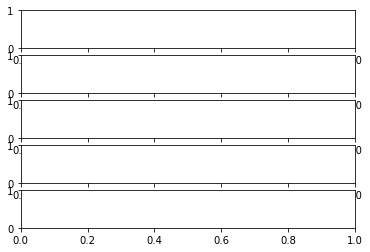

In [35]:
print(results.solver.status) 
print(results.solver.termination_condition) 

# Plotting the stuff --------------------------------------------------
fig, axs = plt.subplots(5)

print(f"theta z: {m.q0[1,'theta_bz'].value}")


# Time stuff ----------------------------------------------------------
duration=m.tt0[N].value-m.tt0[1].value
print(f"tt0[1]: {m.tt0[1].value}")
print(f"tt0[N]: {m.tt0[N].value}")
print(f"duration: {duration}s")
print(f"final distance covered: {m.q0[N,'x'].value}s")
print(f"average velocity: {m.q0[N,'x'].value/duration}")
print(f"hm: {hm}s") 
# print(f"foot 1 starting position: {m.foot_1_x}")

time = np.zeros(N)
tt0 = np.zeros(N)
sum_z_vel = 0
min_z_vel = 100
max_z_vel = 0

for i in range(1,N+1):
    time[i-1]=m.h[i].value
    tt0[i-1]=m.tt0[i].value
    sum_z_vel=sum_z_vel+m.dq0[i,'x'].value
    print(f"node {i} duration: {m.h[i].value}")
    if m.dq0[i,'x'].value < min_z_vel:
        min_z_vel=m.dq0[i,'x'].value
    if m.dq0[i,'x'].value > max_z_vel:
        max_z_vel=m.dq0[i,'x'].value

avg_z_vel=sum_z_vel/N
print(f"average z velocity: {avg_z_vel}")
print(f"minimum z velocity: {min_z_vel}")
print(f"maximum z velocity: {max_z_vel}")
    
# axs[0].plot(tt0, time)
# axs[0].set_title("time per node")

# # GRF z ps -------------------------------------------------------------
# GRF_1z = np.zeros(N) 
# GRF_2z = np.zeros(N) 
# GRF_3z = np.zeros(N) 
# GRF_4z = np.zeros(N) 
# for i in range(1,N+1):
#     GRF_1z[i-1]=m.GRF1[i,3,'Z','ps'].value
#     GRF_2z[i-1]=m.GRF2[i,3,'Z','ps'].value
#     GRF_3z[i-1]=m.GRF3[i,3,'Z','ps'].value
#     GRF_4z[i-1]=m.GRF4[i,3,'Z','ps'].value
    
# axs[1].plot(tt0, GRF_1z)
# axs[1].plot(tt0, GRF_2z)
# axs[1].plot(tt0, GRF_3z)
# axs[1].plot(tt0, GRF_4z)
# axs[1].set_title("GRF in positive z direction")
# axs[1].legend(["GRF_1z", "GRF_2z","GRF_3z", "GRF_4z"])

# # Torques --------------------------------------------------------------
# tau_h1 = np.zeros(N) 
# tau_k1 = np.zeros(N) 
# tau_h2 = np.zeros(N) 
# tau_k2 = np.zeros(N) 
# tau_h3 = np.zeros(N) 
# tau_k3 = np.zeros(N) 
# tau_h4 = np.zeros(N) 
# tau_k4 = np.zeros(N)
# for i in range(1,N+1):
#     tau_h1[i-1]=m.tau_h1[i].value
#     tau_k1[i-1]=m.tau_k1[i].value
#     tau_h2[i-1]=m.tau_h2[i].value
#     tau_k2[i-1]=m.tau_k2[i].value
#     tau_h3[i-1]=m.tau_h3[i].value
#     tau_k3[i-1]=m.tau_k3[i].value
#     tau_h4[i-1]=m.tau_h4[i].value
#     tau_k4[i-1]=m.tau_k4[i].value
    
# axs[2].plot(tt0, tau_h1)
# axs[2].plot(tt0, tau_k1)
# axs[2].plot(tt0, tau_h2)
# axs[2].plot(tt0, tau_k2)
# axs[2].plot(tt0, tau_h3)
# axs[2].plot(tt0, tau_k3)
# axs[2].plot(tt0, tau_h4)
# axs[2].plot(tt0, tau_k4)
# axs[2].set_title("Torques")
# # axs[2].legend(["tau_h1", "tau_k1","tau_h2", "tau_k2","tau_h3", "tau_k3","tau_h4", "tau_k4"],loc='upper right')

# # Velocities --------------------------------------------------------------
# v_x = np.zeros(N) 

# for i in range(1,N+1):
#     v_x[i-1]=m.dq0[i,'x'].value
    
# axs[3].plot(tt0, v_x)
# axs[3].set_title("Velocities")

# # Angular Velocity --------------------------------------------------------------
# w_h1 = np.zeros(N) 
# w_k1 = np.zeros(N) 
# w_h2 = np.zeros(N) 
# w_k2 = np.zeros(N) 
# w_h3 = np.zeros(N) 
# w_k3 = np.zeros(N) 
# w_h4 = np.zeros(N) 
# w_k4 = np.zeros(N)
# for i in range(1,N+1):
#     w_h1[i-1]=m.dq0[i,'theta_h1'].value
#     w_k1[i-1]=m.dq0[i,'theta_k1'].value
#     w_h2[i-1]=m.dq0[i,'theta_h2'].value
#     w_k2[i-1]=m.dq0[i,'theta_k2'].value
#     w_h3[i-1]=m.dq0[i,'theta_h3'].value
#     w_k3[i-1]=m.dq0[i,'theta_k3'].value
#     w_h4[i-1]=m.dq0[i,'theta_h4'].value
#     w_k4[i-1]=m.dq0[i,'theta_k4'].value
    
# axs[4].plot(tt0, w_h1)
# axs[4].plot(tt0, w_k1)
# axs[4].plot(tt0, w_h2)
# axs[4].plot(tt0, w_k2)
# axs[4].plot(tt0, w_h3)
# axs[4].plot(tt0, w_k3)
# axs[4].plot(tt0, w_h4)
# axs[4].plot(tt0, w_k4)
# axs[4].set_title("Angular velocities")
# # axs[4].legend(["h1", "k1","h2", "k2","h3", "k3","h4", "k4"],loc='upper right')


MovieWriter PillowWriter unavailable; using Pillow instead.


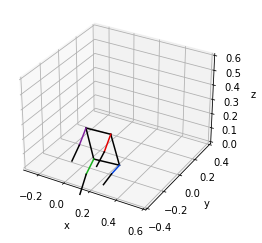

In [36]:
# Animation stuff -------------------------------------------------------
#-----------Print 3D---------------------
fig1 = plt.figure()
ax1 = plt.axes(projection='3d') #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-0.3, 0.6) 
    ax.set_ylim(-0.4, 0.4)
    ax.set_zlim(-0.0, 0.6);

    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)

    #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = m.h[i-1].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
animate.save(r'C:'+path+'3D_Quad.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())


MovieWriter PillowWriter unavailable; using Pillow instead.


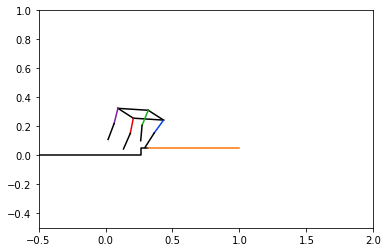

In [37]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - X-Z ---------------------
fig2,ax2= plt.subplots(1,1) #create axes

foot1x=np.array([])
foot1z=np.array([])


def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,2])
    ax.set_ylim([-0.5,1.0])
    
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
   #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     print(foot1[0,0])
    
#     foot1x = np.append(foot1x,foot1[0,0])
    
#     Ground
    ax.plot([-0.5,0.5*BodyLength+distance_from_step,0.5*BodyLength+distance_from_step,0.5*BodyLength+distance_from_step+step_length],[0, 0, stair_height, stair_height],color='xkcd:black')
    ax.plot([0.5*BodyLength+distance_from_step+step_length,0.5*BodyLength+distance_from_step+step_length*2,1.0],[stair_height,stair_height, stair_height],color='xkcd:orange')
       
update = lambda i: plot_robot(i,m,ax2) #lambdify update function

animate = ani.FuncAnimation(fig2,update,range(1,N+1),interval = m.h[i].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
animate.save('XZ_Quad.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())
# print(f"BodyLength/2+distance_from_Step = {BodyLength/2+distance_from_step}")

MovieWriter PillowWriter unavailable; using Pillow instead.


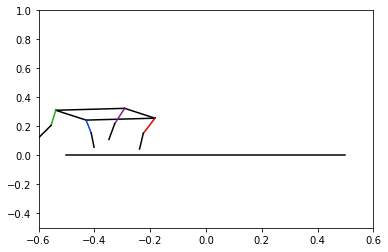

In [38]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - Y-Z ---------------------
fig3,ax3= plt.subplots(1,1) #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.5,1.0])
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
    #plot body
    ax.plot([h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     Ground
    ax.plot([-0.5,0.5],[0,0],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax3) #lambdify update function

animate = ani.FuncAnimation(fig3,update,range(1,N+1),interval = m.h[i].value*hm*1000,repeat=False)
# m.h[i].value*hm*100000
animate.save(r'C:'+path+'XZ_Quad.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

In [39]:
foot1x = np.array([])
foot1y = np.array([])
foot1z = np.array([])
foot2x = np.array([])
foot2y = np.array([])
foot2z = np.array([])
foot3x = np.array([])
foot3y = np.array([])
foot3z = np.array([])
foot4x = np.array([])
foot4y = np.array([])
foot4z = np.array([])

for i in range(1,N+1):
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
    foot1x = np.append(foot1x, foot1[0,0])
    foot1y = np.append(foot1y, foot1[1,0])
    foot1z = np.append(foot1z, foot1[2,0])
    foot2x = np.append(foot2x, foot2[0,0])
    foot2y = np.append(foot2y, foot2[1,0])
    foot2z = np.append(foot2z, foot2[2,0])
    foot3x = np.append(foot3x, foot3[0,0])
    foot3y = np.append(foot3y, foot3[1,0])
    foot3z = np.append(foot3z, foot3[2,0])
    foot4x = np.append(foot4x, foot4[0,0])
    foot4y = np.append(foot4y, foot4[1,0])
    foot4z = np.append(foot4z, foot4[2,0])
    

In [40]:
#SAVING PARAMETERS
import pandas as pd
#Physical properties -----------------------------------------------------------------------------------------------
properties = {'N':[N],'Body Mass':[m.m[('body',1)]],'Femur 1 Mass':[m.m[('femur',1)]],'Tibia 1 Mass':[m.m[('tibia',1)]],'Femur 2 Mass':[m.m[('femur',2)]],
                                    'Tibia 2 Mass':[m.m[('tibia',2)]],'Femur 3 Mass':[m.m[('femur',3)]],'Tibia 3 Mass':[m.m[('tibia',3)]],'Femur 4 Mass':[m.m[('femur',4)]],'Tibia 4 Mass':[m.m[('tibia',4)]],
                                    'Body Length':[m.l[('body',1)]],'Body Width':[m.l[('bodyWidth',1)]],'Femur 1 Length':[m.l[('femur',1)]],'Tibia 1 Length':[m.l[('tibia',1)]],'Femur 2 Length':[m.l[('femur',2)]],'Tibia 2 Length':[m.l[('tibia',2)]],
                                    'Femur 3 Length':[m.l[('femur',3)]],'Tibia 3 Length':[m.l[('tibia',3)]],'Femur 4 Length':[m.l[('femur',4)]],'Tibia 4 Length':[m.l[('tibia',4)]]}
Properties = pd.DataFrame(properties)
Properties.to_csv (r'C:'+path+'3D_Properties.csv', index = False, header=True)

#Torques, node time steps ------------------------------------------------------------------------------------------------------------
torques = {'Node timesteps':[m.h[n].value for n in range (1, N+1)],'Torque Hip 1':[m.tau_h1[n].value for n in range (1, N+1)],'Torque Knee 1':[m.tau_k1[n].value for n in range (1, N+1)],'Torque Hip 2':[m.tau_h2[n].value for n in range (1, N+1)],'Torque Knee 2':[m.tau_k2[n].value for n in range (1, N+1)],
                                    'Torque Hip 3':[m.tau_h3[n].value for n in range (1, N+1)],'Torque Knee 3':[m.tau_k3[n].value for n in range (1, N+1)],'Torque Hip 4':[m.tau_h4[n].value for n in range (1, N+1)],'Torque Knee 4':[m.tau_k4[n].value for n in range (1, N+1)]}
Torques = pd.DataFrame(torques)
Torques.to_csv (r'C:'+path+'3D_Nodal.csv', index = False, header=True)

#Trajectories per collocation point - Angles, Velocities and GRFs - unaltered ----------------------------------------------------------------------------------------
qx = [0 for x in range(N*3)]
qy = [0 for x in range(N*3)]
qz = [0 for x in range(N*3)]
qthx = [0 for x in range(N*3)]
qthy = [0 for x in range(N*3)]
qthz = [0 for x in range(N*3)]
qh1 = [0 for x in range(N*3)]
qk1 = [0 for x in range(N*3)]
qh2 = [0 for x in range(N*3)]
qk2 = [0 for x in range(N*3)]
qh3 = [0 for x in range(N*3)]
qk3 = [0 for x in range(N*3)]
qh4 = [0 for x in range(N*3)]
qk4 = [0 for x in range(N*3)]

dqx = [0 for x in range(N*3)]
dqy = [0 for x in range(N*3)]
dqz = [0 for x in range(N*3)]
dqthx = [0 for x in range(N*3)]
dqthy = [0 for x in range(N*3)]
dqthz = [0 for x in range(N*3)]
dqh1 = [0 for x in range(N*3)]
dqk1 = [0 for x in range(N*3)]
dqh2 = [0 for x in range(N*3)]
dqk2 = [0 for x in range(N*3)]
dqh3 = [0 for x in range(N*3)]
dqk3 = [0 for x in range(N*3)]
dqh4 = [0 for x in range(N*3)]
dqk4 = [0 for x in range(N*3)]

grf1x = [0 for x in range(N*3)]
grf1y = [0 for x in range(N*3)]
grf1z = [0 for x in range(N*3)]
grf2x = [0 for x in range(N*3)]
grf2y = [0 for x in range(N*3)]
grf2z = [0 for x in range(N*3)]
grf3x = [0 for x in range(N*3)]
grf3y = [0 for x in range(N*3)]
grf3z = [0 for x in range(N*3)]
grf4x = [0 for x in range(N*3)]
grf4y = [0 for x in range(N*3)]
grf4z = [0 for x in range(N*3)]

for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        qx[i] = m.q[n,c+1,'x'].value
        qy[i] = m.q[n,c+1,'x'].value
        qz[i] = m.q[n,c+1,'z'].value
        qthx[i] = m.q[n,c+1,'theta_bx'].value
        qthy[i] = m.q[n,c+1,'theta_by'].value
        qthz[i] = m.q[n,c+1,'theta_bz'].value
        qh1[i] = m.q[n,c+1,'theta_h1'].value
        qk1[i] = m.q[n,c+1,'theta_k1'].value
        qh2[i] = m.q[n,c+1,'theta_h2'].value
        qk2[i] = m.q[n,c+1,'theta_k2'].value
        qh3[i] = m.q[n,c+1,'theta_h3'].value
        qk3[i] = m.q[n,c+1,'theta_k3'].value
        qh4[i] = m.q[n,c+1,'theta_h4'].value
        qk4[i] = m.q[n,c+1,'theta_k4'].value
        
        dqx[i] = m.dq[n,c+1,'x'].value
        dqy[i] = m.dq[n,c+1,'x'].value
        dqz[i] = m.dq[n,c+1,'z'].value
        dqthx[i] = m.dq[n,c+1,'theta_bx'].value
        dqthy[i] = m.dq[n,c+1,'theta_by'].value
        dqthz[i] = m.dq[n,c+1,'theta_bz'].value
        dqh1[i] = m.dq[n,c+1,'theta_h1'].value
        dqk1[i] = m.dq[n,c+1,'theta_k1'].value
        dqh2[i] = m.dq[n,c+1,'theta_h2'].value
        dqk2[i] = m.dq[n,c+1,'theta_k2'].value
        dqh3[i] = m.dq[n,c+1,'theta_h3'].value
        dqk3[i] = m.dq[n,c+1,'theta_k3'].value
        dqh4[i] = m.dq[n,c+1,'theta_h4'].value
        dqk4[i] = m.dq[n,c+1,'theta_k4'].value
        
        grf1x[i] = m.GRF1[n,c+1,'X','ps'].value-m.GRF1[n,c+1,'X','ng'].value
        grf1y[i] = m.GRF1[n,c+1,'Y','ps'].value-m.GRF1[n,c+1,'Y','ng'].value
        grf1z[i] = m.GRF1[n,c+1,'Z','ps'].value
        grf2x[i] = m.GRF2[n,c+1,'X','ps'].value-m.GRF2[n,c+1,'X','ng'].value
        grf2y[i] = m.GRF2[n,c+1,'Y','ps'].value-m.GRF2[n,c+1,'Y','ng'].value
        grf2z[i] = m.GRF2[n,c+1,'Z','ps'].value
        grf3x[i] = m.GRF3[n,c+1,'X','ps'].value-m.GRF3[n,c+1,'X','ng'].value
        grf3y[i] = m.GRF3[n,c+1,'Y','ps'].value-m.GRF3[n,c+1,'Y','ng'].value
        grf3z[i] = m.GRF3[n,c+1,'Z','ps'].value
        grf4x[i] = m.GRF4[n,c+1,'X','ps'].value-m.GRF4[n,c+1,'X','ng'].value
        grf4y[i] = m.GRF4[n,c+1,'Y','ps'].value-m.GRF4[n,c+1,'Y','ng'].value
        grf4z[i] = m.GRF4[n,c+1,'Z','ps'].value

movement_traj = {'X Position':[qx[i] for i in range (len(qx))],'Y Position':[qy[i] for i in range (len(qy))],'Z Position':[qz[i] for i in range (len(qz))],'Body Angle x':[qthx[i] for i in range (len(qthx))],'Body Angle y':[qthy[i] for i in range (len(qthy))],'Body Angle z':[qthz[i] for i in range (len(qthz))],'Hip 1 Angle':[qh1[i] for i in range (len(qh1))],'Knee 1 Angle':[qk1[i] for i in range (len(qk1))],'Hip 2 Angle':[qh2[i] for i in range (len(qh2))],'Knee 2 Angle':[qk2[i] for i in range (len(qk2))],
           'Hip 3 Angle':[qh3[i] for i in range (len(qh3))],'Knee 3 Angle':[qk3[i] for i in range (len(qk3))],'Hip 4 Angle':[qh4[i] for i in range (len(qh4))],'Knee 4 Angle':[qk4[i] for i in range (len(qk4))],
           'X Velocity':[dqx[i] for i in range (len(dqx))],'Z Velocity':[dqz[i] for i in range (len(dqz))],'Body Velocity x':[dqthx[i] for i in range (len(dqthx))],'Body Velocity y':[dqthy[i] for i in range (len(dqthy))],'Body Velocity z':[dqthz[i] for i in range (len(dqthz))],'Hip 1 Velocity':[dqh1[i] for i in range (len(dqh1))],'Knee 1 Velocity':[dqk1[i] for i in range (len(dqk1))],'Hip 2 Velocity':[dqh2[i] for i in range (len(dqh2))],'Knee 2 Velocity':[dqk2[i] for i in range (len(dqk2))],
           'Hip 3 Velocity':[dqh3[i] for i in range (len(dqh3))],'Knee 3 Velocity':[dqk3[i] for i in range (len(dqk3))],'Hip 4 Velocity':[dqh4[i] for i in range (len(dqh4))],'Knee 4 Velocity':[dqk4[i] for i in range (len(dqk4))],
           'GRF 1x':[grf1x[i] for i in range (len(grf1x))],'GRF 2x':[grf2x[i] for i in range (len(grf2x))],'GRF 3x':[grf3x[i] for i in range (len(grf3x))],'GRF 4x':[grf4x[i] for i in range (len(grf4x))],
           'GRF 1y':[grf1y[i] for i in range (len(grf1y))],'GRF 2y':[grf2y[i] for i in range (len(grf2y))],'GRF 3y':[grf3y[i] for i in range (len(grf3y))],'GRF 4y':[grf4y[i] for i in range (len(grf4y))],
           'GRF 1z':[grf1z[i] for i in range (len(grf1z))],'GRF 2z':[grf2z[i] for i in range (len(grf2z))],'GRF 3z':[grf3z[i] for i in range (len(grf3z))],'GRF 4z':[grf4z[i] for i in range (len(grf4z))]}

Movement_traj = pd.DataFrame(movement_traj)
Movement_traj.to_csv (r'C:'+path+'3D_col_traj.csv', index = False, header=True)

#ROS trajectories per collocation point  - Angles, Velocities and GRFs - altered ----------------------------------------------------------------------------------------
r_qx = [0 for x in range(N*3)]
r_qy = [0 for x in range(N*3)]
r_qz = [0 for x in range(N*3)]
r_qthx = [0 for x in range(N*3)]
r_qthy = [0 for x in range(N*3)]
r_qthz = [0 for x in range(N*3)]
r_qh1 = [0 for x in range(N*3)]
r_qk1 = [0 for x in range(N*3)]
r_qh2 = [0 for x in range(N*3)]
r_qk2 = [0 for x in range(N*3)]
r_qh3 = [0 for x in range(N*3)]
r_qk3 = [0 for x in range(N*3)]
r_qh4 = [0 for x in range(N*3)]
r_qk4 = [0 for x in range(N*3)]
t = [0 for x in range(N*3)]
t_new = [0 for x in range(N*3)]


for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        r_qx[i] = m.q[n,c+1,'x'].value
        r_qy[i] = m.q[n,c+1,'y'].value
        r_qz[i] = m.q[n,c+1,'z'].value
        r_qthx[i] = m.q[n,c+1,'theta_bx'].value
        r_qthy[i] = m.q[n,c+1,'theta_by'].value
        r_qthz[i] = m.q[n,c+1,'theta_bz'].value
        r_qh1[i] = m.q[n,c+1,'theta_h1'].value
        r_qk1[i] = m.q[n,c+1,'theta_k1'].value
        r_qh2[i] = m.q[n,c+1,'theta_h2'].value
        r_qk2[i] = m.q[n,c+1,'theta_k2'].value
        r_qh3[i] = m.q[n,c+1,'theta_h3'].value
        r_qk3[i] = m.q[n,c+1,'theta_k3'].value
        r_qh4[i] = m.q[n,c+1,'theta_h4'].value
        r_qk4[i] = m.q[n,c+1,'theta_k4'].value
        t[i] = m.tt[n,c+1].value
 
for n in range (1,len(t)):
    t_new[n]=t[n]-t[n-1]
t_new[0]=m.h[1].value/3

movement_ros = {'X Position':[r_qx[i] for i in range (len(r_qx))],'Y Position':[r_qy[i] for i in range (len(r_qy))],'Z Position':[r_qz[i] for i in range (len(r_qz))],'Body Angle x':[r_qthx[i] for i in range (len(r_qthx))],'Body Angle y':[r_qthy[i] for i in range (len(r_qthy))],'Body Angle z':[r_qthz[i] for i in range (len(r_qthz))],'Hip 1 Angle':[r_qh1[i] for i in range (len(r_qh1))],'Knee 1 Angle':[r_qk1[i] for i in range (len(r_qk1))],'Hip 2 Angle':[r_qh2[i] for i in range (len(r_qh2))],'Knee 2 Angle':[r_qk2[i] for i in range (len(r_qk2))],
           'Hip 3 Angle':[r_qh3[i] for i in range (len(r_qh3))],'Knee 3 Angle':[r_qk3[i] for i in range (len(r_qk3))],'Hip 4 Angle':[r_qh4[i] for i in range (len(r_qh4))],'Knee 4 Angle':[r_qk4[i] for i in range (len(r_qk4))],'m.tt':[t_new[i] for i in range (len(t))]}

Movement_ros = pd.DataFrame(movement_ros)
Movement_ros.to_csv (r'C:'+path+'3D_col_ros.csv', index = False, header=True)

print('done')

done


In [41]:
logger.info(f"Distance travelled: {m.q0[N,'x'].value}m")
logger.info(f"Travel duration: {duration}s")
logger.info(f"Travel velocity: {m.q0[N,'x'].value/duration}m/s")
logger.info("Finito")

[2023-09-19T04:11:15+0200.0416][INFO ][<ipython-input-41-311d0ff009e8>] - Distance travelled: 0.2630289894617102m
[2023-09-19T04:11:15+0200.0418][INFO ][<ipython-input-41-311d0ff009e8>] - Travel duration: 2.049052758197528s
[2023-09-19T04:11:15+0200.0420][INFO ][<ipython-input-41-311d0ff009e8>] - Travel velocity: 0.12836613816282924m/s
[2023-09-19T04:11:15+0200.0421][INFO ][<ipython-input-41-311d0ff009e8>] - Finito
